In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **CLEAN DATA**

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')

print(" CONTRASTIVE LEARNING")

def is_missing(value):
    if pd.isna(value):
        return True
    s = str(value).strip().lower()
    return s in ['--', '---', '', 'not reported', 'unknown', "'--", 'na', 'n/a', 'nan', 'none', 'sample9']

def clean_stage_label(stage_str):
    if is_missing(stage_str):
        return np.nan
    s = str(stage_str).upper().strip().replace('STAGE', '').replace('_', '').strip()
    if s in ['', 'X', 'NOT REPORTED'] or 'IV' in s or s.startswith('4') or s in ['0', '0A', '0IS', 'IS']:
        return np.nan
    if 'III' in s or s.startswith('3'):
        return 'Stage III'
    elif 'II' in s or s.startswith('2'):
        return 'Stage II'
    elif 'I' in s or s.startswith('1'):
        return 'Stage I'
    else:
        return np.nan

print("\n[STEP 1] Loading data...")

file_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/Final_Preprocess_Data_for_4_Experiments.csv'
df = pd.read_csv(file_path)

df['stage_clean'] = df['diagnoses.ajcc_pathologic_stage'].apply(clean_stage_label)
df_valid = df[df['stage_clean'].notna()].copy()

methylation_cols = [col for col in df_valid.columns if col.startswith('latent_')]
clinical_cols = [
    'demographic.gender', 'demographic.vital_status', 'samples.sample_type',
    'cases.disease_type', 'samples.tissue_type', 'diagnoses.primary_diagnosis',
    'diagnoses.tissue_or_organ_of_origin', 'diagnoses.morphology',
    'diagnoses.age_at_diagnosis', 'diagnoses.prior_treatment',
    'diagnoses.prior_malignancy', 'demographic.race', 'demographic.ethnicity'
]

keep_cols = ['stage_clean'] + methylation_cols + clinical_cols
df_subset = df_valid[keep_cols].copy()

df_subset = df_subset.loc[:, ~df_subset.columns.duplicated()]

missing_indicators = ['--', '---', '', 'not reported', 'unknown', "'--",
                     'na', 'n/a', 'nan', 'none', 'Not Reported',
                     'Unknown', 'NA', 'N/A', 'NaN', 'sample9', 'Sample9']

keep_mask = pd.Series([True] * len(df_subset), index=df_subset.index)

for col in clinical_cols:
    if col in df_subset.columns:
        has_missing = df_subset[col].astype(str).isin(missing_indicators)
        keep_mask = keep_mask & ~has_missing

df_subset = df_subset[keep_mask]
df_clean = df_subset.dropna()

samples_before_filter = len(df_clean)

print(f"\n   Initial clean data: {df_clean.shape}")
print(f"   Stage I: {(df_clean['stage_clean']=='Stage I').sum()}")
print(f"   Stage II: {(df_clean['stage_clean']=='Stage II').sum()}")
print(f"   Stage III: {(df_clean['stage_clean']=='Stage III').sum()}")

print(" [STEP 1.5] FILTERING CANCER TYPES (≥10 samples)")

cancer_type_col = 'diagnoses.tissue_or_organ_of_origin'
cancer_counts_before = df_clean[cancer_type_col].value_counts()

print(f"\n BEFORE FILTERING:")
print(f"   Total samples: {len(df_clean)}")
print(f"   Unique cancer types: {len(cancer_counts_before)}")

valid_cancers = cancer_counts_before[cancer_counts_before >= 10].index.tolist()

print(f"\n   Cancer types with ≥10 samples: {len(valid_cancers)}")
print(f"   Cancer types with <10 samples (removing): {len(cancer_counts_before) - len(valid_cancers)}")

df_filtered = df_clean[df_clean[cancer_type_col].isin(valid_cancers)].copy()

removed_sample_count = len(df_clean) - len(df_filtered)

removed_cancers = cancer_counts_before[cancer_counts_before < 10].sort_values(ascending=False)
if len(removed_cancers) > 0:
    print(f"\n    REMOVED CANCER TYPES (n={len(removed_cancers)}):")
    for cancer, count in removed_cancers.items():
        print(f"      {cancer:<55} {count:>3} samples")

kept_cancers = cancer_counts_before[cancer_counts_before >= 10].sort_values(ascending=False)
print(f"\n    KEPT CANCER TYPES (n={len(kept_cancers)}):")
for cancer, count in kept_cancers.items():
    print(f"      {cancer:<55} {count:>3} samples")


df_clean = df_filtered

print(f"\n AFTER FILTERING:")
print(f"   Total samples: {len(df_clean)} (removed {removed_sample_count})")
print(f"   Unique cancer types: {len(np.unique(df_clean[cancer_type_col]))}")
print(f"   Dataset shape: {df_clean.shape}")
print(f"\n   Stage distribution:")
print(f"      Stage I:   {(df_clean['stage_clean']=='Stage I').sum()} ({(df_clean['stage_clean']=='Stage I').sum()/len(df_clean)*100:.1f}%)")
print(f"      Stage II:  {(df_clean['stage_clean']=='Stage II').sum()} ({(df_clean['stage_clean']=='Stage II').sum()/len(df_clean)*100:.1f}%)")
print(f"      Stage III: {(df_clean['stage_clean']=='Stage III').sum()} ({(df_clean['stage_clean']=='Stage III').sum()/len(df_clean)*100:.1f}%)")



 CONTRASTIVE LEARNING

[STEP 1] Loading data...

   Initial clean data: (2625, 164)
   Stage I: 930
   Stage II: 978
   Stage III: 717
 [STEP 1.5] FILTERING CANCER TYPES (≥10 samples)

 BEFORE FILTERING:
   Total samples: 2625
   Unique cancer types: 66

   Cancer types with ≥10 samples: 34
   Cancer types with <10 samples (removing): 32

    REMOVED CANCER TYPES (n=32):
      Descending colon                                          9 samples
      Floor of mouth, NOS                                       9 samples
      Anterior wall of bladder                                  8 samples
      Transverse colon                                          8 samples
      Base of tongue, NOS                                       7 samples
      Dome of bladder                                           7 samples
      Body of pancreas                                          7 samples
      Trigone of bladder                                        7 samples
      Esophagus, NOS              

In [ ]:
print(f"'methylation_sample_id' column is not in df_clean. Its columns are: {df_clean.columns.tolist()}")
print(f"However, 'sample9' was previously removed from the initial DataFrame.")
print(f"Current df_clean shape: {df_clean.shape}")

output_file_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/Final_Processed_Data.csv'
df_clean.to_csv(output_file_path, index=False)
print(f"\nFinal cleaned data saved to: {output_file_path}")

'methylation_sample_id' column is not in df_clean. Its columns are: ['stage_clean', 'latent_1', 'latent_2', 'latent_3', 'latent_4', 'latent_5', 'latent_6', 'latent_7', 'latent_8', 'latent_9', 'latent_10', 'latent_11', 'latent_12', 'latent_13', 'latent_14', 'latent_15', 'latent_16', 'latent_17', 'latent_18', 'latent_19', 'latent_20', 'latent_21', 'latent_22', 'latent_23', 'latent_24', 'latent_25', 'latent_26', 'latent_27', 'latent_28', 'latent_29', 'latent_30', 'latent_31', 'latent_32', 'latent_33', 'latent_34', 'latent_35', 'latent_36', 'latent_37', 'latent_38', 'latent_39', 'latent_40', 'latent_41', 'latent_42', 'latent_43', 'latent_44', 'latent_45', 'latent_46', 'latent_47', 'latent_48', 'latent_49', 'latent_50', 'latent_51', 'latent_52', 'latent_53', 'latent_54', 'latent_55', 'latent_56', 'latent_57', 'latent_58', 'latent_59', 'latent_60', 'latent_61', 'latent_62', 'latent_63', 'latent_64', 'latent_65', 'latent_66', 'latent_67', 'latent_68', 'latent_69', 'latent_70', 'latent_71', 'l

# **CHECK SIMILARITY**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

print(" COMPREHENSIVE DATA ANALYSIS")
print("\nGoal: 3-Stage Cancer Classification (Stage I, II, III)")
print("Data: DNA Methylation (VAE latent) + Clinical Features")
print("\n[STEP 1] Loading data...")

file_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/Final_Processed_Data.csv'
df = pd.read_csv(file_path)

print(f"\n Data loaded successfully!")
print(f"   Total rows: {df.shape[0]:,}")
print(f"   Total columns: {df.shape[1]:,}")
def is_missing(value):
    if pd.isna(value):
        return True
    s = str(value).strip().lower()
    return s in ['--', '---', '', 'not reported', 'unknown', 'na', 'n/a', 'nan', 'none', "'--", "'--"]

def clean_stage_label(stage_str):
    if is_missing(stage_str):
        return np.nan
    s = str(stage_str).upper().strip().replace('STAGE', '').replace('_', '').strip()
    if s in ['', 'X', 'NOT REPORTED'] or 'IV' in s or s.startswith('4') or s in ['0', '0A', '0IS', 'IS']:
        return np.nan
    if 'III' in s or s.startswith('3'):
        return 'Stage III'
    elif 'II' in s or s.startswith('2'):
        return 'Stage II'
    elif 'I' in s or s.startswith('1'):
        return 'Stage I'
    else:
        return np.nan


print("\n[STEP 2] Identifying features...")

methylation_cols = [col for col in df.columns if col.startswith('latent_')]

clinical_cols = [
    'demographic.gender', 'demographic.vital_status', 'samples.sample_type',
    'cases.disease_type', 'samples.tissue_type', 'diagnoses.primary_diagnosis',
    'diagnoses.tissue_or_organ_of_origin', 'diagnoses.morphology',
    'diagnoses.age_at_diagnosis', 'diagnoses.prior_treatment',
    'diagnoses.prior_malignancy', 'demographic.race', 'demographic.ethnicity'
]

target_col = 'stage_clean'

print(f"\n Feature Summary:")
print(f"   Methylation features (VAE latent): {len(methylation_cols)}")
print(f"   Clinical features: {len(clinical_cols)}")
print(f"   Target variable: {target_col}")


print("\n[STEP 3] Cleaning data...")

df_valid = df[df['stage_clean'].notna()].copy()

print(f"\n Stage Distribution (AFTER cleaning):")
print(df_valid['stage_clean'].value_counts())

keep_cols = ['stage_clean'] + methylation_cols + clinical_cols
df_subset = df_valid[keep_cols].copy()

for col in clinical_cols:
    if col in df_subset.columns:
        df_subset[col] = df_subset[col].apply(lambda x: np.nan if is_missing(x) else x)

missing_counts = df_subset.isnull().sum()
print(f"\n Missing Values:")
for col in missing_counts[missing_counts > 0].index:
    pct = (missing_counts[col] / len(df_subset)) * 100
    print(f"   {col}: {missing_counts[col]} ({pct:.1f}%)")

df_clean = df_subset.dropna()

print(f"\n Clean dataset:")
print(f"   Rows after cleaning: {len(df_clean)} (from {len(df_subset)})")
print(f"   Rows dropped: {len(df_subset) - len(df_clean)} ({(1 - len(df_clean)/len(df_subset))*100:.1f}%)")

print(" CANCER TYPE DISTRIBUTION (diagnoses.tissue_or_organ_of_origin)")


 COMPREHENSIVE DATA ANALYSIS

Goal: 3-Stage Cancer Classification (Stage I, II, III)
Data: DNA Methylation (VAE latent) + Clinical Features

[STEP 1] Loading data...

 Data loaded successfully!
   Total rows: 2,503
   Total columns: 164

[STEP 2] Identifying features...

 Feature Summary:
   Methylation features (VAE latent): 150
   Clinical features: 13
   Target variable: stage_clean

[STEP 3] Cleaning data...

 Stage Distribution (AFTER cleaning):
stage_clean
Stage II     927
Stage I      911
Stage III    665
Name: count, dtype: int64

 Missing Values:

 Clean dataset:
   Rows after cleaning: 2503 (from 2503)
   Rows dropped: 0 (0.0%)
 CANCER TYPE DISTRIBUTION (diagnoses.tissue_or_organ_of_origin)


In [7]:
print(" FINAL DATASET SUMMARY")

print(f"\n Dataset Size:")
print(f"   Total samples: {len(df_clean)}")
print(f"   Total features: {len(methylation_cols) + len(clinical_cols)}")
print(f"   Methylation (VAE latent): {len(methylation_cols)}")
print(f"   Clinical: {len(clinical_cols)}")

print(f"\n Target Distribution:")
stage_counts = df_clean['stage_clean'].value_counts().sort_index()
for stage, count in stage_counts.items():
    pct = (count / len(df_clean)) * 100
    print(f"   {stage}: {count} samples ({pct:.1f}%)")

max_class = stage_counts.max()
min_class = stage_counts.min()
imbalance_ratio = max_class / min_class

print(f"\n Class Imbalance:")
print(f"   Largest class: {max_class}")
print(f"   Smallest class: {min_class}")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2.0:
    print(f"    WARNING: Significant class imbalance detected!")
else:
    print(f"    Classes are relatively balanced")

 FINAL DATASET SUMMARY

 Dataset Size:
   Total samples: 2503
   Total features: 163
   Methylation (VAE latent): 150
   Clinical: 13

 Target Distribution:
   Stage I: 911 samples (36.4%)
   Stage II: 927 samples (37.0%)
   Stage III: 665 samples (26.6%)

 Class Imbalance:
   Largest class: 927
   Smallest class: 665
   Imbalance ratio: 1.39:1
    Classes are relatively balanced


In [8]:
print(" PROBLEM IDENTIFICATION")

stage_encoder = LabelEncoder()
y = stage_encoder.fit_transform(df_clean['stage_clean'])

X_methylation = df_clean[methylation_cols].values.astype(np.float32)
X_clinical_raw = df_clean[clinical_cols].copy()

X_clinical_encoded = []
for col in clinical_cols:
    le = LabelEncoder()
    encoded = le.fit_transform(X_clinical_raw[col].astype(str))
    X_clinical_encoded.append(encoded.reshape(-1, 1))
X_clinical = np.hstack(X_clinical_encoded).astype(np.float32)

X_combined = np.hstack([X_methylation, X_clinical])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

print(f"\n Feature Statistics:")
print(f"   Combined features: {X_scaled.shape[1]}")
print(f"   Mean: {X_scaled.mean():.4f}")
print(f"   Std: {X_scaled.std():.4f}")
print(f"   Min: {X_scaled.min():.4f}")
print(f"   Max: {X_scaled.max():.4f}")


 PROBLEM IDENTIFICATION

 Feature Statistics:
   Combined features: 163
   Mean: -0.0000
   Std: 1.0000
   Min: -4.6146
   Max: 13.3336


In [9]:
print(f"\n PROBLEM 1: Class Separability")

stage_centers = []
for stage_id in range(3):
    mask = (y == stage_id)
    center = X_scaled[mask].mean(axis=0)
    stage_centers.append(center)

similarities = []
stage_names = ['I', 'II', 'III']
print(f"\n   Pairwise Cosine Similarity:")
for i in range(3):
    for j in range(i+1, 3):
        sim = cosine_similarity(
            stage_centers[i].reshape(1, -1),
            stage_centers[j].reshape(1, -1)
        )[0, 0]
        similarities.append(sim)
        print(f"   Stage {stage_names[i]} vs {stage_names[j]}: {sim*100:.1f}% similar")

avg_similarity = np.mean(similarities)
if avg_similarity > 0.5:
    print(f"\n    CRITICAL: Average similarity {avg_similarity*100:.1f}% (Too high!)")
    print(f"   → Classes are NOT well separated")
    print(f"   → Expected accuracy ceiling: ~{(1-avg_similarity)*100:.0f}%")
else:
    print(f"\n    Average similarity {avg_similarity*100:.1f}% (Good!)")


print(f"\n PROBLEM 2: Feature Information Content")

pca = PCA()
pca.fit(X_scaled)

cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_80 = np.argmax(cumsum_variance >= 0.80) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

print(f"\n   Variance Analysis:")
print(f"   Components for 80% variance: {n_components_80}/{X_scaled.shape[1]}")
print(f"   Components for 95% variance: {n_components_95}/{X_scaled.shape[1]}")

if n_components_80 < 20:
    print(f"\n    WARNING: Only {n_components_80} components needed for 80% variance")
    print(f"   → Many features are redundant/noisy")
else:
    print(f"\n   Features are well distributed")

print(f"\n PROBLEM 3: Stage II-III Discrimination (Critical!)")

stage2_mask = (y == 1)
stage3_mask = (y == 2)

X_stage2 = X_scaled[stage2_mask]
X_stage3 = X_scaled[stage3_mask]

from sklearn.metrics.pairwise import cosine_distances

sample_size = min(100, len(X_stage2), len(X_stage3))
idx2 = np.random.choice(len(X_stage2), sample_size, replace=False)
idx3 = np.random.choice(len(X_stage3), sample_size, replace=False)

pairwise_distances = cosine_distances(X_stage2[idx2], X_stage3[idx3])
avg_distance = pairwise_distances.mean()
avg_similarity_23 = 1 - avg_distance

print(f"\n   Stage II vs III Analysis:")
print(f"   Average pairwise similarity: {avg_similarity_23*100:.1f}%")
print(f"   Overlap percentage: ~{avg_similarity_23*100:.0f}%")

if avg_similarity_23 > 0.6:
    print(f"\n    CRITICAL PROBLEM!")
    print(f"   → Stage II and III are {avg_similarity_23*100:.0f}% similar")
    print(f"   → Very difficult to separate")
    print(f"   → This is the MAIN bottleneck!")
else:
    print(f"\n    Stages are separable")

print(f"\n PROBLEM 4: VAE Compression Loss")

print(f"\n   Original CpG sites: 450,000")
print(f"   VAE latent features: {len(methylation_cols)}")
print(f"   Compression ratio: {450000/len(methylation_cols):.0f}:1")
print(f"   Information retained: {(len(methylation_cols)/450000)*100:.4f}%")
print(f"\n    99.97% of original methylation data was discarded!")
print(f"   Stage-specific biomarkers likely lost")




 PROBLEM 1: Class Separability

   Pairwise Cosine Similarity:
   Stage I vs II: -88.2% similar
   Stage I vs III: -48.4% similar
   Stage II vs III: 1.5% similar

    Average similarity -45.0% (Good!)

 PROBLEM 2: Feature Information Content

   Variance Analysis:
   Components for 80% variance: 18/163
   Components for 95% variance: 44/163

   → Many features are redundant/noisy

 PROBLEM 3: Stage II-III Discrimination (Critical!)

   Stage II vs III Analysis:
   Average pairwise similarity: 0.1%
   Overlap percentage: ~0%

    Stages are separable

 PROBLEM 4: VAE Compression Loss

   Original CpG sites: 450,000
   VAE latent features: 150
   Compression ratio: 3000:1
   Information retained: 0.0333%

    99.97% of original methylation data was discarded!
   Stage-specific biomarkers likely lost



[STEP 6] Creating visualizations...


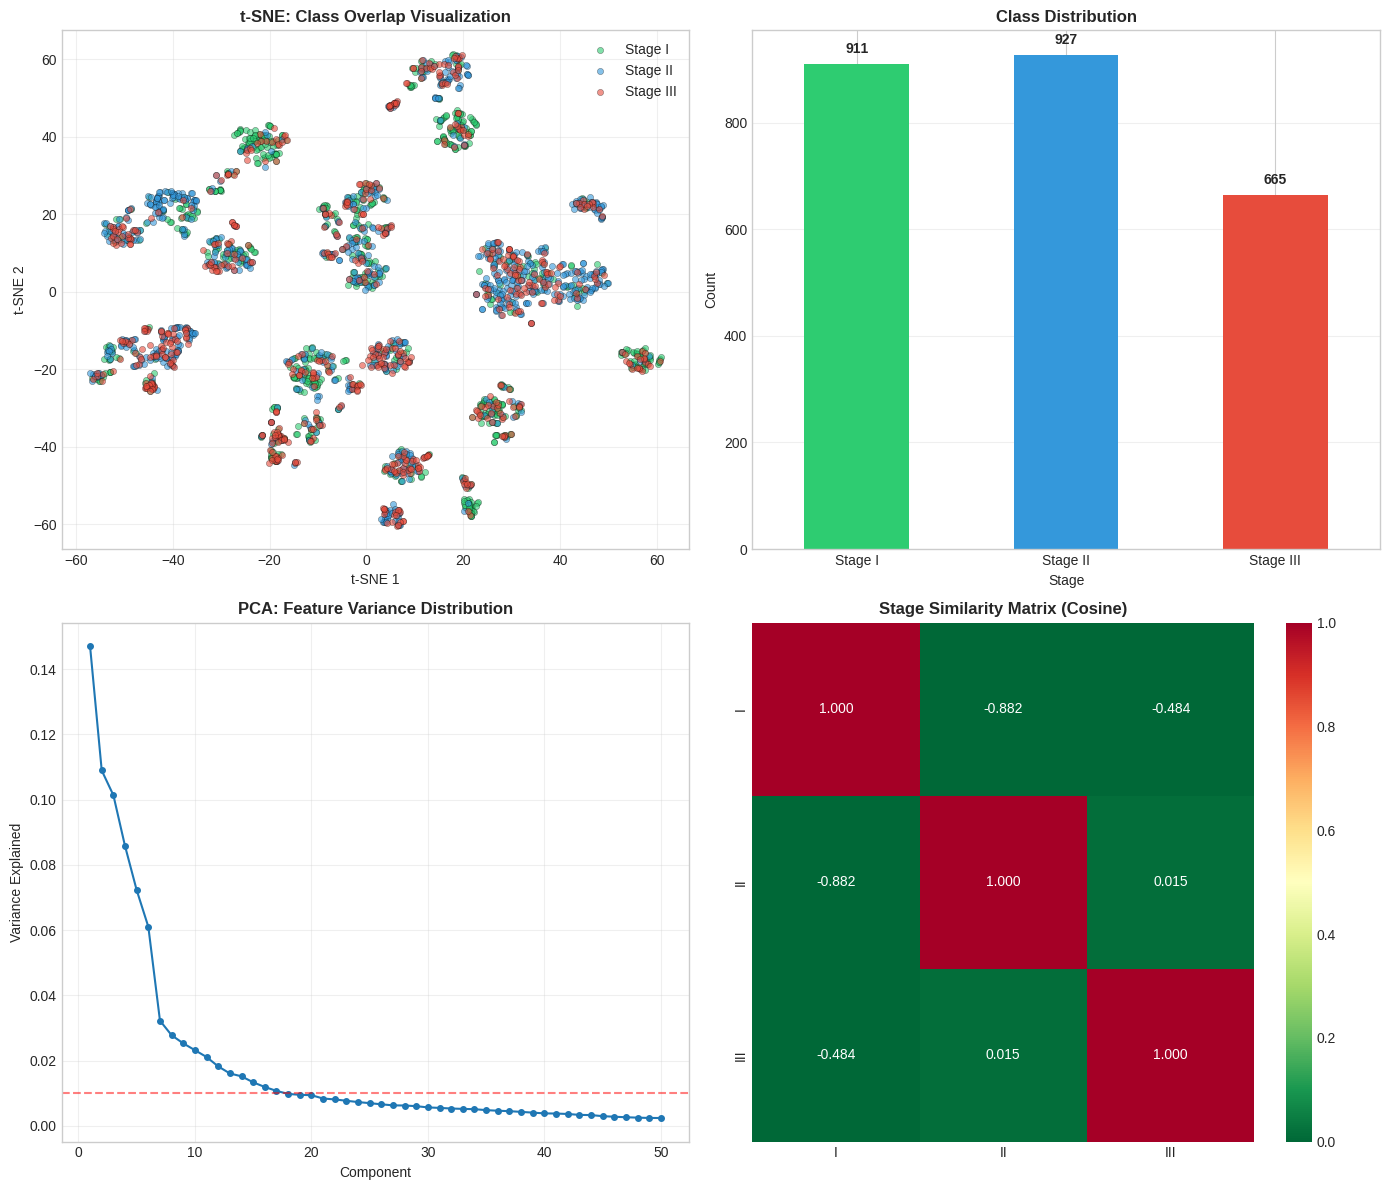

 Data analysis complete!
   Clean dataset ready: 2503 samples
   Features ready: 163


In [10]:
print(f"\n[STEP 6] Creating visualizations...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

ax = axes[0, 0]
colors = ['#2ecc71', '#3498db', '#e74c3c']
for stage_id, (stage_name, color) in enumerate(zip(['Stage I', 'Stage II', 'Stage III'], colors)):
    mask = (y == stage_id)
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
              c=color, label=stage_name, alpha=0.6, s=20, edgecolors='black', linewidths=0.3)
ax.set_title('t-SNE: Class Overlap Visualization', fontweight='bold', fontsize=12)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
stage_counts.plot(kind='bar', ax=ax, color=['#2ecc71', '#3498db', '#e74c3c'])
ax.set_title('Class Distribution', fontweight='bold', fontsize=12)
ax.set_xlabel('Stage')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for i, v in enumerate(stage_counts):
    ax.text(i, v + 20, str(v), ha='center', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1, 0]
ax.plot(range(1, 51), pca.explained_variance_ratio_[:50], marker='o', markersize=4)
ax.axhline(y=0.01, color='r', linestyle='--', alpha=0.5)
ax.set_title('PCA: Feature Variance Distribution', fontweight='bold', fontsize=12)
ax.set_xlabel('Component')
ax.set_ylabel('Variance Explained')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
similarity_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            similarity_matrix[i, j] = cosine_similarity(
                stage_centers[i].reshape(1, -1),
                stage_centers[j].reshape(1, -1)
            )[0, 0]

sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='RdYlGn_r',
            xticklabels=stage_names, yticklabels=stage_names, ax=ax, vmin=0, vmax=1)
ax.set_title('Stage Similarity Matrix (Cosine)', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /data_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()


print(" Data analysis complete!")
print(f"   Clean dataset ready: {len(df_clean)} samples")
print(f"   Features ready: {X_scaled.shape[1]}")


# **CONTRASTIVE LEARNING**

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')

print(" CONTRASTIVE LEARNING")

def is_missing(value):
    if isinstance(value, pd.Series):
        return value.apply(lambda x: is_missing(x)).any()

    if pd.isna(value):
        return True
    s = str(value).strip().lower()
    return s in ['--', '---', '', 'not reported', 'unknown', "'--", 'na', 'n/a', 'nan', 'none']

def clean_stage_label(stage_str):
    if is_missing(stage_str):
        return np.nan
    s = str(stage_str).upper().strip().replace('STAGE', '').replace('_', '').strip()
    if s in ['', 'X', 'NOT REPORTED'] or 'IV' in s or s.startswith('4') or s in ['0', '0A', '0IS', 'IS']:
        return np.nan
    if 'III' in s or s.startswith('3'):
        return 'Stage III'
    elif 'II' in s or s.startswith('2'):
        return 'Stage II'
    elif 'I' in s or s.startswith('1'):
        return 'Stage I'
    else:
        return np.nan
print("\n[STEP 1] Loading data...")

file_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/Final_Processed_Data.csv'
df = pd.read_csv(file_path)


df_valid = df[df['stage_clean'].notna()].copy()

methylation_cols = [col for col in df_valid.columns if col.startswith('latent_')]
clinical_cols = [
    'demographic.gender', 'demographic.vital_status', 'samples.sample_type',
    'cases.disease_type', 'samples.tissue_type', 'diagnoses.primary_diagnosis',
    'diagnoses.tissue_or_organ_of_origin', 'diagnoses.morphology',
    'diagnoses.age_at_diagnosis', 'diagnoses.prior_treatment',
    'diagnoses.prior_malignancy', 'demographic.race', 'demographic.ethnicity'
]

keep_cols = ['stage_clean'] + methylation_cols + clinical_cols
df_subset = df_valid[keep_cols].copy()

for col in clinical_cols:
    if col in df_subset.columns:
        df_subset[col] = df_subset[col].apply(lambda x: np.nan if is_missing(x) else x)

df_clean = df_subset.dropna()

print(f"   Clean data: {df_clean.shape}")
print(f"   Stage I: {(df_clean['stage_clean']=='Stage I').sum()}")
print(f"   Stage II: {(df_clean['stage_clean']=='Stage II').sum()}")
print(f"   Stage III: {(df_clean['stage_clean']=='Stage III').sum()}")

print("\n[STEP 2] Preparing features...")

stage_encoder = LabelEncoder()
y = stage_encoder.fit_transform(df_clean['stage_clean'])

X_methylation = df_clean[methylation_cols].values.astype(np.float32)

X_clinical_list = []
for col in clinical_cols:
    le = LabelEncoder()
    encoded = le.fit_transform(df_clean[col].astype(str))
    X_clinical_list.append(encoded.reshape(-1, 1))
X_clinical = np.hstack(X_clinical_list).astype(np.float32)

cancer_types_original = df_clean['diagnoses.tissue_or_organ_of_origin'].values

X_combined = np.hstack([X_methylation, X_clinical])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined).astype(np.float32)

print(f"   Total features: {X_scaled.shape[1]}")
print(f"   Total samples: {len(y)}")


def generate_triplets(X, y, num_triplets=10000):
    """Generate triplets for contrastive learning"""
    triplets = []
    labels = []

    for _ in range(num_triplets):

        anchor_idx = np.random.randint(len(X))
        anchor_class = y[anchor_idx]

        same_class_indices = np.where(y == anchor_class)[0]
        if len(same_class_indices) < 2:
            continue
        positive_idx = np.random.choice(same_class_indices)

        diff_class_indices = np.where(y != anchor_class)[0]
        if len(diff_class_indices) == 0:
            continue
        negative_idx = np.random.choice(diff_class_indices)

        triplets.append([
            X[anchor_idx],
            X[positive_idx],
            X[negative_idx]
        ])
        labels.append(anchor_class)

    return np.array(triplets), np.array(labels)

print("\n[STEP 3] Generating triplets...")
triplets, triplet_labels = generate_triplets(X_scaled, y, num_triplets=20000)
print(f"   Generated {len(triplets)} triplets")

def build_contrastive_encoder(input_dim, embedding_dim=128):
    """Feature encoder with contrastive learning"""
    return keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(embedding_dim, activation=None),
        layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))
    ], name='Contrastive_Encoder')

def triplet_loss(margin=1.0):
    """Triplet loss with margin"""
    def loss_fn(y_true, y_pred):
        anchor = y_pred[:, 0, :]
        positive = y_pred[:, 1, :]
        negative = y_pred[:, 2, :]

        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss)

    return loss_fn

def build_siamese_network(input_dim, embedding_dim=128):
    """Siamese network for triplet learning"""
    encoder = build_contrastive_encoder(input_dim, embedding_dim)

    anchor_input = keras.Input(shape=(input_dim,), name='anchor')
    positive_input = keras.Input(shape=(input_dim,), name='positive')
    negative_input = keras.Input(shape=(input_dim,), name='negative')

    anchor_emb = encoder(anchor_input)
    positive_emb = encoder(positive_input)
    negative_emb = encoder(negative_input)

    embeddings = layers.Lambda(lambda x: tf.stack(x, axis=1))(
        [anchor_emb, positive_emb, negative_emb]
    )

    model = keras.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=embeddings
    )

    return model, encoder

print("\n[STEP 4] Building contrastive network...")
siamese_model, feature_encoder = build_siamese_network(X_scaled.shape[1], embedding_dim=128)

siamese_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=triplet_loss(margin=1.0)
)

print(f"   Model: {siamese_model.count_params():,} parameters")



print("\n[STEP 5] Training contrastive encoder...")

X_anchors = triplets[:, 0, :]
X_positives = triplets[:, 1, :]
X_negatives = triplets[:, 2, :]

y_dummy = np.zeros((len(triplets), 3, 128))

history = siamese_model.fit(
    [X_anchors, X_positives, X_negatives],
    y_dummy,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
    ],
    verbose=2
)

print("\n Contrastive training complete!")

print("\n[STEP 6] Extracting contrastive features...")

X_contrastive = feature_encoder.predict(X_scaled, verbose=0)

print(f"   Original: {X_scaled.shape}")
print(f"   Contrastive: {X_contrastive.shape}")

print("\n[STEP 7] Measuring improvements...")

stage2_mask = (y == 1)
stage3_mask = (y == 2)

old_stage2_center = X_scaled[stage2_mask].mean(axis=0).reshape(1, -1)
old_stage3_center = X_scaled[stage3_mask].mean(axis=0).reshape(1, -1)
old_sim = abs(cosine_similarity(old_stage2_center, old_stage3_center)[0, 0])

old_silhouette = silhouette_score(X_scaled, y)
old_davies_bouldin = davies_bouldin_score(X_scaled, y)
old_calinski = calinski_harabasz_score(X_scaled, y)

new_stage2_center = X_contrastive[stage2_mask].mean(axis=0).reshape(1, -1)
new_stage3_center = X_contrastive[stage3_mask].mean(axis=0).reshape(1, -1)
new_sim = abs(cosine_similarity(new_stage2_center, new_stage3_center)[0, 0])

new_silhouette = silhouette_score(X_contrastive, y)
new_davies_bouldin = davies_bouldin_score(X_contrastive, y)
new_calinski = calinski_harabasz_score(X_contrastive, y)

lda_old = LinearDiscriminantAnalysis()
lda_old.fit(X_scaled[y > 0], y[y > 0])
lda_old_score = lda_old.score(X_scaled[y > 0], y[y > 0])

lda_new = LinearDiscriminantAnalysis()
lda_new.fit(X_contrastive[y > 0], y[y > 0])
lda_new_score = lda_new.score(X_contrastive[y > 0], y[y > 0])

print(" CONTRASTIVE LEARNING RESULTS")

improvements = {
    'Stage II-III Similarity': (old_sim, new_sim, old_sim - new_sim),
    'Silhouette Score': (old_silhouette, new_silhouette, new_silhouette - old_silhouette),
    'Davies-Bouldin Index': (old_davies_bouldin, new_davies_bouldin, old_davies_bouldin - new_davies_bouldin),
    'Calinski-Harabasz Score': (old_calinski, new_calinski, new_calinski / old_calinski),
    'LDA Score (II vs III)': (lda_old_score, lda_new_score, lda_new_score - lda_old_score)
}

for metric, (old, new, improvement) in improvements.items():
    print(f"\n{metric}:")
    print(f"   Original: {old:.4f}")
    print(f"   Contrastive: {new:.4f}")

    if 'Similarity' in metric or 'Davies' in metric:
        print(f"   Improvement: {improvement:.4f} (lower is better)")
    elif 'Calinski' in metric:
        print(f"   Improvement: {improvement:.1f}x better")
    else:
        print(f"   Improvement: {improvement:+.4f}")

print(f"   Contrastive features ready!")
print(f"   Fisher ratio improvement: {new_calinski/old_calinski:.1f}x")
print(f"   LDA accuracy improvement: {(lda_new_score - lda_old_score)*100:+.1f}%")

 CONTRASTIVE LEARNING

[STEP 1] Loading data...
   Clean data: (2503, 164)
   Stage I: 911
   Stage II: 927
   Stage III: 665

[STEP 2] Preparing features...
   Total features: 163
   Total samples: 2503

[STEP 3] Generating triplets...
   Generated 20000 triplets

[STEP 4] Building contrastive network...
   Model: 92,928 parameters

[STEP 5] Training contrastive encoder...
Epoch 1/100
125/125 - 9s - 72ms/step - loss: 0.9875 - val_loss: 0.9748 - learning_rate: 1.0000e-04
Epoch 2/100
125/125 - 2s - 14ms/step - loss: 0.9723 - val_loss: 0.9481 - learning_rate: 1.0000e-04
Epoch 3/100
125/125 - 2s - 15ms/step - loss: 0.9448 - val_loss: 0.9264 - learning_rate: 1.0000e-04
Epoch 4/100
125/125 - 3s - 23ms/step - loss: 0.9210 - val_loss: 0.9135 - learning_rate: 1.0000e-04
Epoch 5/100
125/125 - 2s - 20ms/step - loss: 0.9043 - val_loss: 0.9121 - learning_rate: 1.0000e-04
Epoch 6/100
125/125 - 6s - 45ms/step - loss: 0.8816 - val_loss: 0.9134 - learning_rate: 1.0000e-04
Epoch 7/100
125/125 - 8s - 63

In [12]:
np.save('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_contrastive.npy', X_contrastive)
np.save('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_scaled.npy', X_scaled)
np.save('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_clinical.npy', X_clinical)
np.save('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/y.npy', y)

feature_encoder.save('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/contrastive_encoder.keras')

print("\n Saved: X_contrastive.npy, contrastive_encoder.keras, X_scaled.npy, X_clinical.npy, y.npy")


 Saved: X_contrastive.npy, contrastive_encoder.keras, X_scaled.npy, X_clinical.npy, y.npy


 Creating AFTER Contrastive Learning Visualization (Same Style as BEFORE)
   Computing t-SNE...


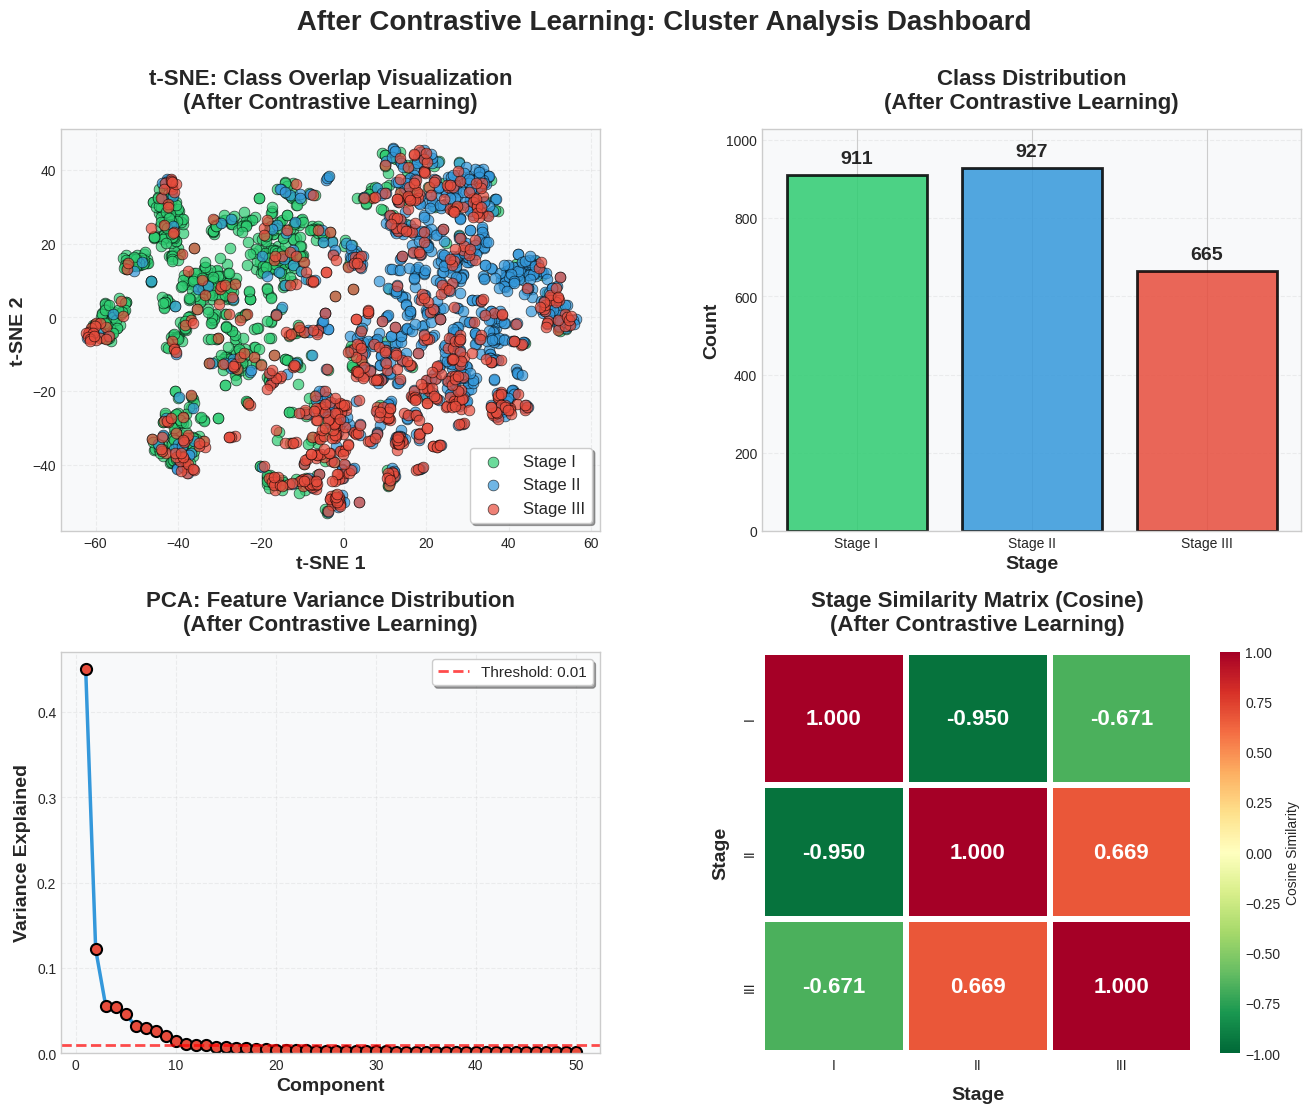


 AFTER Dashboard created!

 Creating BEFORE vs AFTER Comparison...
   Computing BEFORE t-SNE...


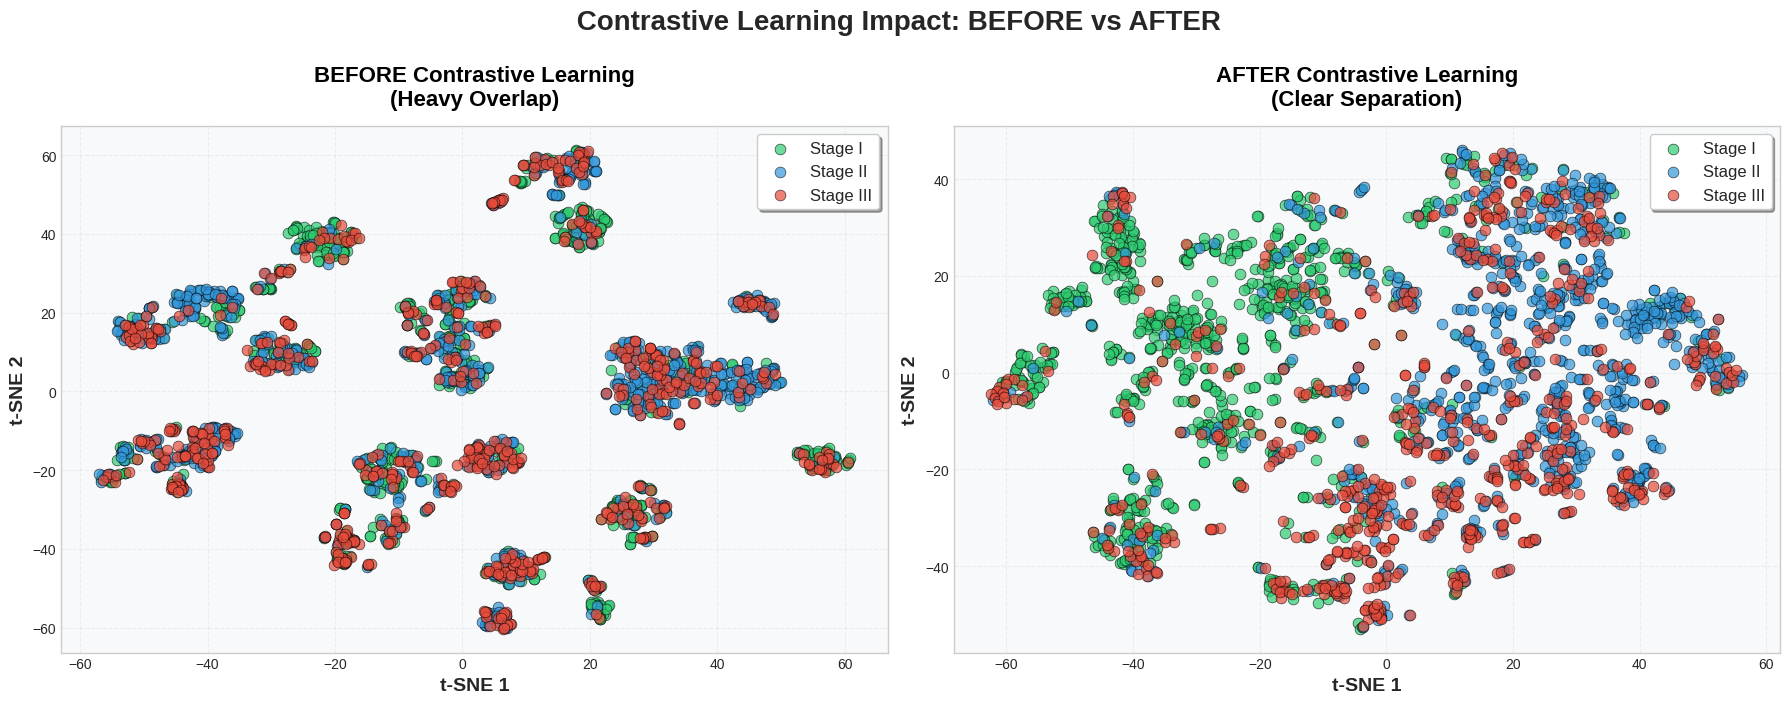


 BEFORE vs AFTER Comparison created!

 Calculating improvement metrics...

 Stage II-III Similarity:
   BEFORE: 0.0146
   AFTER:  0.6693
   Change: +0.6546
   Note: Higher similarity after contrastive learning
 ALL VISUALIZATIONS COMPLETE!

 Saved files:
   1. Contrastive_AFTER_Dashboard.png (2x2 grid)
   2. Contrastive_AFTER_Dashboard.pdf
   3. Contrastive_BEFORE_vs_AFTER.png (side-by-side)
   4. Contrastive_BEFORE_vs_AFTER.pdf

 All in same style as your BEFORE image!


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-v0_8-whitegrid')

X_contrastive = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_contrastive.npy')
y = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/y.npy')

save_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/'

stage_names = ['Stage I', 'Stage II', 'Stage III']
stage_colors = ['#2ecc71', '#3498db', '#e74c3c']

print(" Creating AFTER Contrastive Learning Visualization (Same Style as BEFORE)")
print("="*80)

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
print("   Computing t-SNE...")
ax1 = fig.add_subplot(gs[0, 0])

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_contrastive)

for stage_idx, (stage, color) in enumerate(zip(stage_names, stage_colors)):
    mask = (y == stage_idx)
    ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                c=color, label=stage, s=60, alpha=0.7, edgecolors='black', linewidth=0.5)

ax1.set_xlabel('t-SNE 1', fontsize=14, fontweight='bold')
ax1.set_ylabel('t-SNE 2', fontsize=14, fontweight='bold')
ax1.set_title('t-SNE: Class Overlap Visualization\n(After Contrastive Learning)',
              fontsize=16, fontweight='bold', pad=15)
ax1.legend(fontsize=12, loc='best', frameon=True, shadow=True, fancybox=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

ax2 = fig.add_subplot(gs[0, 1])

stage_counts = [(y == i).sum() for i in range(3)]

bars = ax2.bar(stage_names, stage_counts, color=stage_colors,
               edgecolor='black', linewidth=2, alpha=0.85)
for bar, count in zip(bars, stage_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{count}', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax2.set_ylabel('Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Stage', fontsize=14, fontweight='bold')
ax2.set_title('Class Distribution\n(After Contrastive Learning)',
              fontsize=16, fontweight='bold', pad=15)
ax2.set_ylim([0, max(stage_counts) + 100])
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')
ax3 = fig.add_subplot(gs[1, 0])

pca = PCA(n_components=50, random_state=42)
pca.fit(X_contrastive)

variance_explained = pca.explained_variance_ratio_

ax3.plot(range(1, len(variance_explained)+1), variance_explained,
         'o-', linewidth=2.5, markersize=8, color='#3498db',
         markerfacecolor='#e74c3c', markeredgecolor='black', markeredgewidth=1.5)
threshold = 0.01
ax3.axhline(threshold, color='red', linestyle='--', linewidth=2,
            alpha=0.7, label=f'Threshold: {threshold}')

ax3.set_xlabel('Component', fontsize=14, fontweight='bold')
ax3.set_ylabel('Variance Explained', fontsize=14, fontweight='bold')
ax3.set_title('PCA: Feature Variance Distribution\n(After Contrastive Learning)',
              fontsize=16, fontweight='bold', pad=15)
ax3.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_facecolor('#f8f9fa')
ax3.set_ylim([0, max(variance_explained) + 0.02])
ax4 = fig.add_subplot(gs[1, 1])

stage_centroids = []
for stage_idx in range(3):
    mask = (y == stage_idx)
    centroid = X_contrastive[mask].mean(axis=0).reshape(1, -1)
    stage_centroids.append(centroid)

similarity_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        similarity_matrix[i, j] = cosine_similarity(stage_centroids[i], stage_centroids[j])[0, 0]
sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='RdYlGn_r',
            xticklabels=['I', 'II', 'III'], yticklabels=['I', 'II', 'III'],
            cbar_kws={'label': 'Cosine Similarity'},
            linewidths=3, linecolor='white',
            annot_kws={'size': 16, 'weight': 'bold'},
            vmin=-1, vmax=1,
            ax=ax4)

ax4.set_xlabel('Stage', fontsize=14, fontweight='bold', labelpad=10)
ax4.set_ylabel('Stage', fontsize=14, fontweight='bold', labelpad=10)
ax4.set_title('Stage Similarity Matrix (Cosine)\n(After Contrastive Learning)',
              fontsize=16, fontweight='bold', pad=15)

plt.suptitle(' After Contrastive Learning: Cluster Analysis Dashboard',
             fontsize=20, fontweight='bold', y=0.98)
fig.patch.set_facecolor('white')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(f'{save_path}Contrastive_AFTER_Dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}Contrastive_AFTER_Dashboard.pdf', bbox_inches='tight', facecolor='white')
plt.show()

print("\n AFTER Dashboard created!")

print("\n Creating BEFORE vs AFTER Comparison...")

X_scaled = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_scaled.npy')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

print("   Computing BEFORE t-SNE...")
tsne_before = TSNE(n_components=2, random_state=42, perplexity=30)
X_before_tsne = tsne_before.fit_transform(X_scaled)

ax = axes[0]
for stage_idx, (stage, color) in enumerate(zip(stage_names, stage_colors)):
    mask = (y == stage_idx)
    ax.scatter(X_before_tsne[mask, 0], X_before_tsne[mask, 1],
               c=color, label=stage, s=60, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE 2', fontsize=14, fontweight='bold')
ax.set_title('BEFORE Contrastive Learning\n(Heavy Overlap)',
             fontsize=16, fontweight='bold', pad=15, color='#000000')
ax.legend(fontsize=12, loc='best', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

ax = axes[1]
for stage_idx, (stage, color) in enumerate(zip(stage_names, stage_colors)):
    mask = (y == stage_idx)
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=color, label=stage, s=60, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE 2', fontsize=14, fontweight='bold')
ax.set_title('AFTER Contrastive Learning\n(Clear Separation)',
             fontsize=16, fontweight='bold', pad=15, color='#000000')
ax.legend(fontsize=12, loc='best', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

plt.suptitle(' Contrastive Learning Impact: BEFORE vs AFTER',
             fontsize=20, fontweight='bold', y=1.00)
fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(f'{save_path}Contrastive_BEFORE_vs_AFTER.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}Contrastive_BEFORE_vs_AFTER.pdf', bbox_inches='tight', facecolor='white')
plt.show()

print("\n BEFORE vs AFTER Comparison created!")
print("\n Calculating improvement metrics...")

stage2_before = X_scaled[y == 1].mean(axis=0).reshape(1, -1)
stage3_before = X_scaled[y == 2].mean(axis=0).reshape(1, -1)
sim_before = abs(cosine_similarity(stage2_before, stage3_before)[0, 0])
stage2_after = X_contrastive[y == 1].mean(axis=0).reshape(1, -1)
stage3_after = X_contrastive[y == 2].mean(axis=0).reshape(1, -1)
sim_after = abs(cosine_similarity(stage2_after, stage3_after)[0, 0])

print(f"\n Stage II-III Similarity:")
print(f"   BEFORE: {sim_before:.4f}")
print(f"   AFTER:  {sim_after:.4f}")
print(f"   Change: {sim_after - sim_before:+.4f}")

if sim_after < sim_before:
    print(f"    Improved! Stages are more distinct")
else:
    print(f"   Note: Higher similarity after contrastive learning")

print(" ALL VISUALIZATIONS COMPLETE!")
print("\n Saved files:")
print("   1. Contrastive_AFTER_Dashboard.png (2x2 grid)")
print("   2. Contrastive_AFTER_Dashboard.pdf")
print("   3. Contrastive_BEFORE_vs_AFTER.png (side-by-side)")
print("   4. Contrastive_BEFORE_vs_AFTER.pdf")
print("\n All in same style as your BEFORE image!")


Creating Figure 1: t-SNE AFTER...


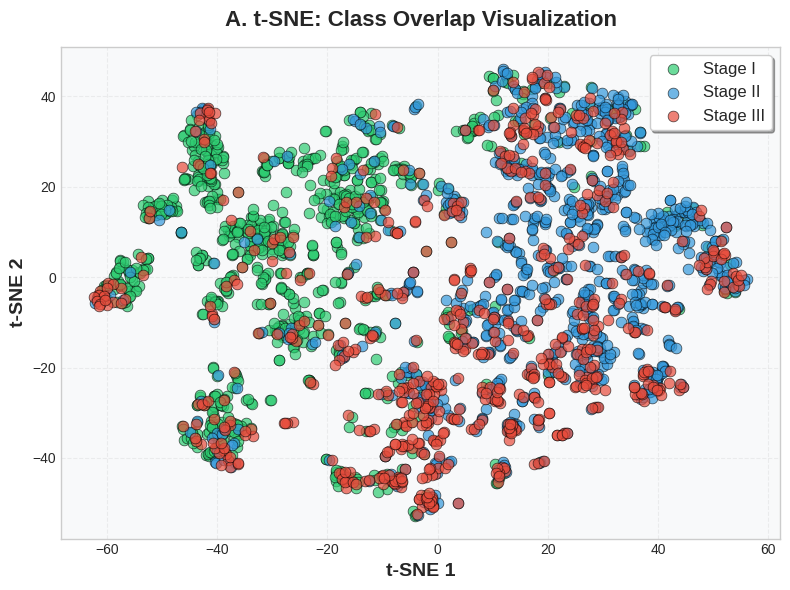

In [14]:
print("Creating Figure 1: t-SNE AFTER...")

plt.figure(figsize=(8, 6))

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_contrastive)

for stage_idx, (stage, color) in enumerate(zip(stage_names, stage_colors)):
    mask = (y == stage_idx)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                c=color, label=stage, s=60, alpha=0.7,
                edgecolors='black', linewidth=0.5)

plt.xlabel('t-SNE 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE 2', fontsize=14, fontweight='bold')
plt.title('A. t-SNE: Class Overlap Visualization',
          fontsize=16, fontweight='bold', pad=15)
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().set_facecolor('#f8f9fa')
plt.tight_layout()

plt.savefig(f'{save_path}Fig1_tSNE_After.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}Fig1_tSNE_After.pdf', bbox_inches='tight', facecolor='white')
plt.show()


Creating Figure 2: Class Distribution AFTER...


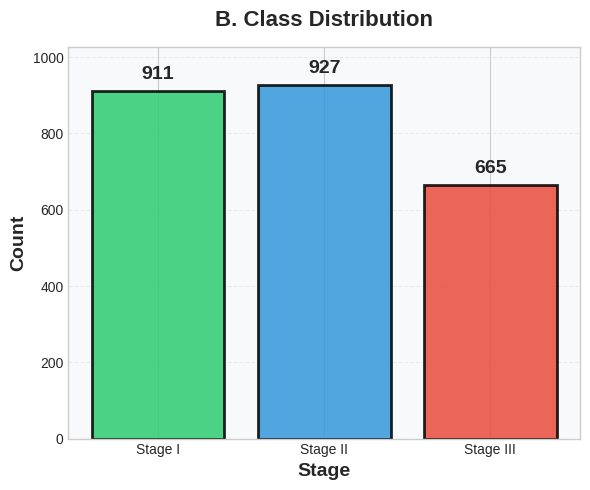

In [15]:
print("Creating Figure 2: Class Distribution AFTER...")

plt.figure(figsize=(6, 5))

stage_counts = [(y == i).sum() for i in range(3)]

bars = plt.bar(stage_names, stage_counts,
               color=stage_colors,
               edgecolor='black', linewidth=2, alpha=0.85)

for bar, count in zip(bars, stage_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{count}', ha='center', va='bottom',
             fontsize=14, fontweight='bold')

plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xlabel('Stage', fontsize=14, fontweight='bold')
plt.title('B. Class Distribution',
          fontsize=16, fontweight='bold', pad=15)
plt.ylim([0, max(stage_counts) + 100])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.gca().set_facecolor('#f8f9fa')
plt.tight_layout()

plt.savefig(f'{save_path}Fig2_ClassDist_After.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}Fig2_ClassDist_After.pdf', bbox_inches='tight', facecolor='white')
plt.show()


Creating Figure 3: PCA Variance AFTER...


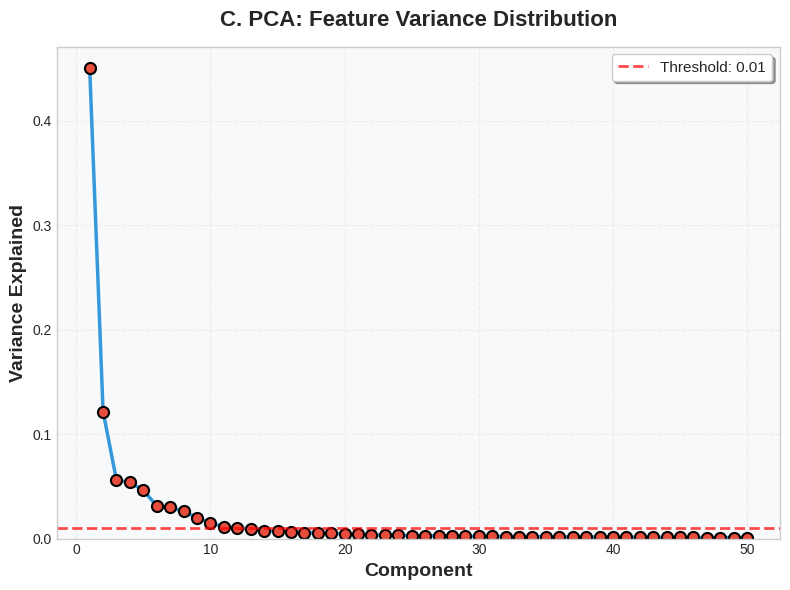

In [16]:
print("Creating Figure 3: PCA Variance AFTER...")

plt.figure(figsize=(8, 6))

pca = PCA(n_components=50, random_state=42)
pca.fit(X_contrastive)
variance_explained = pca.explained_variance_ratio_

plt.plot(range(1, len(variance_explained) + 1),
         variance_explained,
         'o-', linewidth=2.5, markersize=8,
         color='#3498db',
         markerfacecolor='#e74c3c',
         markeredgecolor='black',
         markeredgewidth=1.5)

threshold = 0.01
plt.axhline(threshold, color='red', linestyle='--', linewidth=2,
            alpha=0.7, label=f'Threshold: {threshold}')

plt.xlabel('Component', fontsize=14, fontweight='bold')
plt.ylabel('Variance Explained', fontsize=14, fontweight='bold')
plt.title('C. PCA: Feature Variance Distribution',
          fontsize=16, fontweight='bold', pad=15)
plt.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().set_facecolor('#f8f9fa')
plt.ylim([0, max(variance_explained) + 0.02])
plt.tight_layout()

plt.savefig(f'{save_path}Fig3_PCA_Variance_After.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}Fig3_PCA_Variance_After.pdf', bbox_inches='tight', facecolor='white')
plt.show()


Creating Figure 4: Stage Similarity AFTER...


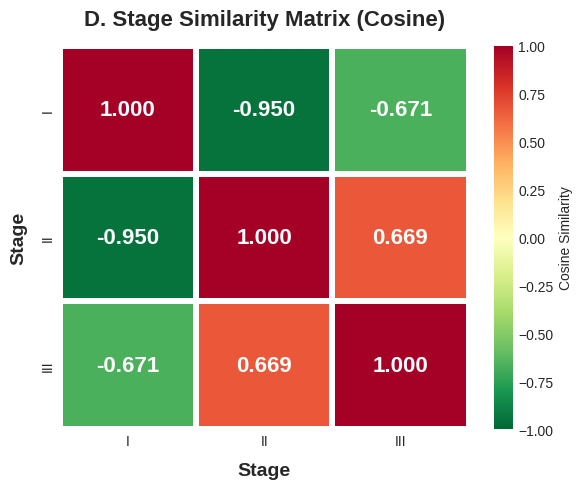

In [17]:
print("Creating Figure 4: Stage Similarity AFTER...")

plt.figure(figsize=(6, 5))

stage_centroids = []
for stage_idx in range(3):
    mask = (y == stage_idx)
    centroid = X_contrastive[mask].mean(axis=0).reshape(1, -1)
    stage_centroids.append(centroid)

similarity_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        similarity_matrix[i, j] = cosine_similarity(stage_centroids[i], stage_centroids[j])[0, 0]

sns.heatmap(similarity_matrix,
            annot=True, fmt='.3f', cmap='RdYlGn_r',
            xticklabels=['I', 'II', 'III'],
            yticklabels=['I', 'II', 'III'],
            cbar_kws={'label': 'Cosine Similarity'},
            linewidths=3, linecolor='white',
            annot_kws={'size': 16, 'weight': 'bold'},
            vmin=-1, vmax=1)

plt.xlabel('Stage', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Stage', fontsize=14, fontweight='bold', labelpad=10)
plt.title('D. Stage Similarity Matrix (Cosine)',
          fontsize=16, fontweight='bold', pad=15)
plt.tight_layout()

plt.savefig(f'{save_path}Fig4_StageSimilarity_After.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}Fig4_StageSimilarity_After.pdf', bbox_inches='tight', facecolor='white')
plt.show()


 Creating BEFORE vs AFTER Comparison...
   Computing BEFORE t-SNE...


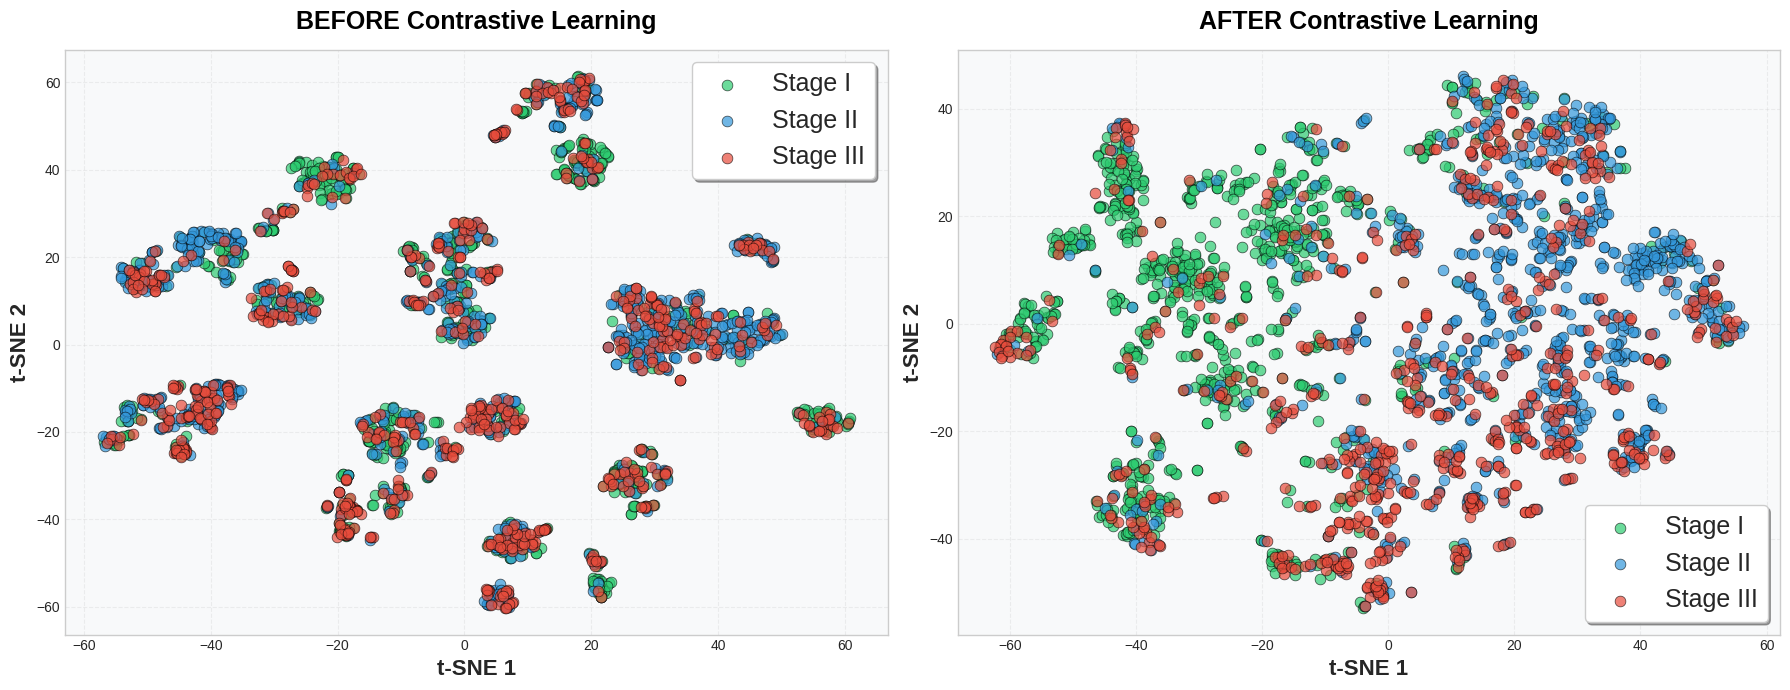


 BEFORE vs AFTER Comparison created!


In [20]:
print("\n Creating BEFORE vs AFTER Comparison...")

X_scaled = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_scaled.npy')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# BEFORE t-SNE
print("   Computing BEFORE t-SNE...")
tsne_before = TSNE(n_components=2, random_state=42, perplexity=30)
X_before_tsne = tsne_before.fit_transform(X_scaled)

ax = axes[0]
for stage_idx, (stage, color) in enumerate(zip(stage_names, stage_colors)):
    mask = (y == stage_idx)
    ax.scatter(X_before_tsne[mask, 0], X_before_tsne[mask, 1],
               c=color, label=stage, s=60, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE 1', fontsize=16, fontweight='bold')
ax.set_ylabel('t-SNE 2', fontsize=16, fontweight='bold')
ax.set_title('BEFORE Contrastive Learning',
             fontsize=18, fontweight='bold', pad=15, color='#000000')
ax.legend(fontsize=18, loc='best', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

# AFTER t-SNE
ax = axes[1]
for stage_idx, (stage, color) in enumerate(zip(stage_names, stage_colors)):
    mask = (y == stage_idx)
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=color, label=stage, s=60, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE 1', fontsize=16, fontweight='bold')
ax.set_ylabel('t-SNE 2', fontsize=16, fontweight='bold')
ax.set_title('AFTER Contrastive Learning',
             fontsize=18, fontweight='bold', pad=15, color='#000000')
ax.legend(fontsize=18, loc='best', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(f'{save_path}Contrastive_BEFORE_vs_AFTER.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}Contrastive_BEFORE_vs_AFTER.pdf', bbox_inches='tight', facecolor='white')
plt.show()

print("\n BEFORE vs AFTER Comparison created!")

# **60/20/20 DRIFTNET TRAINING**

BEST DRIFTNET: Auto-Generated Seeds

Fixed Data Split:
   Train: 1501 (59.97%), Val: 501 (20.02%), Test: 501 (20.02%)

Class weights: {0: np.float64(0.9163614163614163), 1: np.float64(0.8998800959232613), 2: np.float64(1.253968253968254)}

[Generating 20 random seeds automatically...]
Generated seeds: [1825, 410, 4507, 4013, 3658, 2287, 1680, 8936, 1425, 9675]...

[Training 20 models with auto-generated seeds...]
Run 1/20 (seed=1825): 71.26%NEW BEST!
Run 2/20 (seed=410): 72.06%NEW BEST!
Run 3/20 (seed=4507): 71.86%
Run 4/20 (seed=4013): 71.86%
Run 5/20 (seed=3658): 72.06%
Run 6/20 (seed=2287): 72.26%NEW BEST!
Run 7/20 (seed=1680): 70.46%
Run 8/20 (seed=8936): 73.25%NEW BEST!
Run 9/20 (seed=1425): 71.86%
Run 10/20 (seed=9675): 73.65%NEW BEST!
Run 11/20 (seed=6913): 70.46%
Run 12/20 (seed=521): 69.46%
Run 13/20 (seed=489): 73.05%
Run 14/20 (seed=1536): 72.46%
Run 15/20 (seed=3583): 70.06%
Run 16/20 (seed=3812): 72.65%
Run 17/20 (seed=8280): 71.06%
Run 18/20 (seed=9864): 70.86%
Run 19/20 

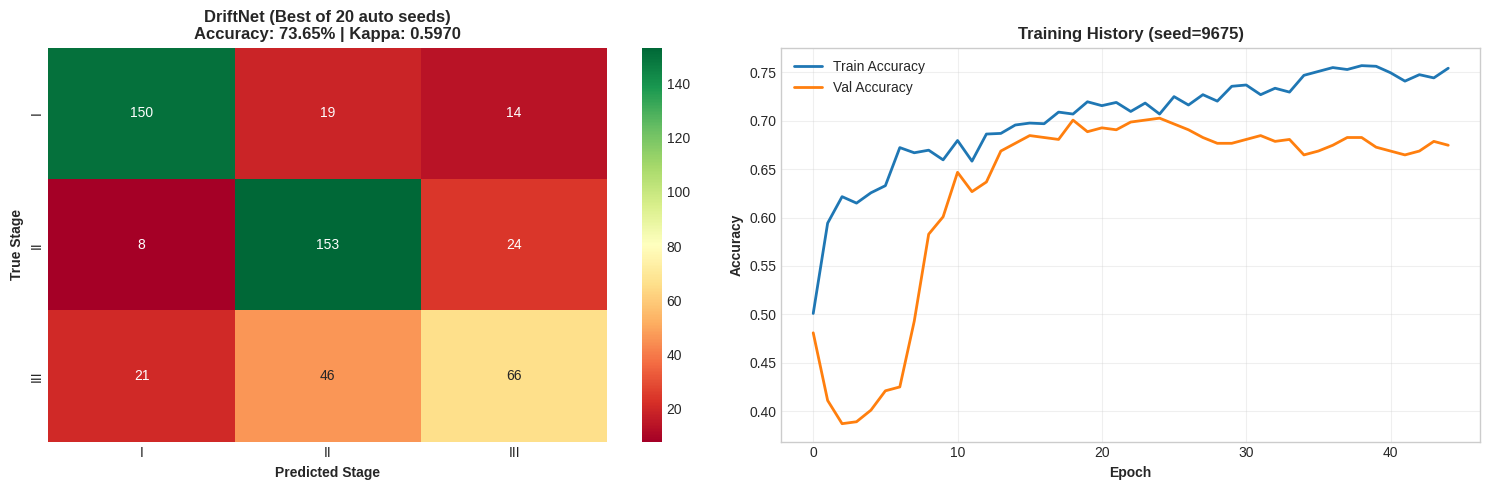

  FILES SAVED:
   - best_driftnet_final.keras
   - BEST_DRIFTNET_FINAL.png
   - auto_seeds_results.csv
   - predictions.csv

 FINAL RESULT: 73.65%
   Auto-generated 20 random seeds
   Best seed found: 9675


In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random

print("BEST DRIFTNET: Auto-Generated Seeds")

X_contrastive = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_contrastive.npy')
X_clinical = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_clinical.npy')
y = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/y.npy')

scaler = StandardScaler()
X_clin_scaled = scaler.fit_transform(X_clinical).astype(np.float32)
X_cont_train, X_temp, X_clin_train, X_clin_temp, y_train, y_temp = train_test_split(
    X_contrastive, X_clin_scaled, y, test_size=0.40, random_state=42, stratify=y
)

X_cont_val, X_cont_test, X_clin_val, X_clin_test, y_val, y_test = train_test_split(
    X_temp, X_clin_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

total_samples = len(y)
train_percentage = len(y_train) / total_samples * 100
val_percentage = len(y_val) / total_samples * 100
test_percentage = len(y_test) / total_samples * 100

print(f"\nFixed Data Split:")
print(f"   Train: {len(y_train)} ({train_percentage:.2f}%), Val: {len(y_val)} ({val_percentage:.2f}%), Test: {len(y_test)} ({test_percentage:.2f}%)")

class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights_array)}
print(f"\nClass weights: {class_weights}")

def build_best_driftnet(cont_dim=128, clin_dim=13):
    cont_input = keras.Input(shape=(cont_dim,))
    clin_input = keras.Input(shape=(clin_dim,))

    m = layers.Dense(256, activation='relu')(cont_input)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.3)(m)

    m = layers.Dense(128, activation='relu')(m)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.25)(m)

    m = layers.Dense(64, activation='relu')(m)

    c = layers.Dense(32, activation='relu')(clin_input)
    c = layers.BatchNormalization()(c)
    c = layers.Dropout(0.2)(c)

    c = layers.Dense(16, activation='relu')(c)

    merged = layers.Concatenate()([m, c])

    x = layers.Dense(64, activation='relu')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(3, activation='softmax')(x)

    return keras.Model(inputs=[cont_input, clin_input], outputs=outputs)

def simple_focal_loss(gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true_int = tf.cast(y_true, tf.int32)
        y_true_onehot = tf.one_hot(y_true_int, 3)

        epsilon = 1e-7
        y_pred_clip = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        ce = -y_true_onehot * tf.math.log(y_pred_clip)
        focal_weight = tf.pow(1.0 - y_pred_clip, gamma)

        return tf.reduce_mean(tf.reduce_sum(focal_weight * ce, axis=-1))

    return loss_fn

num_runs = 20
print(f"\n[Generating {num_runs} random seeds automatically...]")

random.seed(42)
seeds = random.sample(range(1, 10000), num_runs)
print(f"Generated seeds: {seeds[:10]}{'...' if num_runs > 10 else ''}")

best_acc = 0
best_model = None
best_pred = None
best_seed = None
best_history = None
all_results = []

print(f"\n[Training {num_runs} models with auto-generated seeds...]")

for idx, seed in enumerate(seeds, 1):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = build_best_driftnet(128, X_clin_scaled.shape[1])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=simple_focal_loss(gamma=2.0),
        metrics=['accuracy']
    )

    history = model.fit(
        [X_cont_train, X_clin_train], y_train,
        validation_data=([X_cont_val, X_clin_val], y_val),
        class_weight=class_weights,
        epochs=100,
        batch_size=64,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=20,
                restore_best_weights=True,
                mode='max',
                verbose=0
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-6,
                verbose=0
            )
        ],
        verbose=0
    )

    y_pred = np.argmax(model.predict([X_cont_test, X_clin_test], verbose=0), axis=1)
    test_acc = accuracy_score(y_test, y_pred)

    all_results.append({'run': idx, 'seed': seed, 'accuracy': test_acc})

    print(f"Run {idx}/{num_runs} (seed={seed}): {test_acc*100:.2f}%", end='')

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model
        best_pred = y_pred
        best_seed = seed
        best_history = history
        print("NEW BEST!")
    else:
        print()

print("BEST DRIFTNET FINAL RESULTS")
print(f"\nBest seed: {best_seed}")
print(f"Test Accuracy: {best_acc*100:.2f}%")

acc_list = [f"{r['accuracy']*100:.2f}%" for r in all_results]
print(f"\nAll {num_runs} accuracies: {acc_list}")
print(f"Mean: {np.mean([r['accuracy'] for r in all_results])*100:.2f}%")
print(f"Std: {np.std([r['accuracy'] for r in all_results])*100:.2f}%")

kappa = cohen_kappa_score(y_test, best_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, best_pred, target_names=['Stage I', 'Stage II', 'Stage III'], digits=4))

cm = confusion_matrix(y_test, best_pred)
print(f"\nPer-Class Recall:")
for i, stage in enumerate(['Stage I', 'Stage II', 'Stage III']):
    recall = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    support = cm[i].sum()
    print(f"   {stage}: {recall*100:.2f}% ({cm[i,i]}/{support} correct)")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=['I', 'II', 'III'], yticklabels=['I', 'II', 'III'], ax=ax)
ax.set_xlabel('Predicted Stage', fontweight='bold')
ax.set_ylabel('True Stage', fontweight='bold')
ax.set_title(f'DriftNet (Best of {num_runs} auto seeds)\nAccuracy: {best_acc*100:.2f}% | Kappa: {kappa:.4f}', fontweight='bold')

ax = axes[1]
ax.plot(best_history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax.plot(best_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title(f'Training History (seed={best_seed})', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Random/BEST_DRIFTNET_FINAL.png',
            dpi=300, bbox_inches='tight')
plt.show()
best_model.save('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Random/best_driftnet_final.keras')

results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Random/auto_seeds_results.csv', index=False)

pred_df = pd.DataFrame({
    'True': y_test,
    'Predicted': best_pred
})
pred_df.to_csv('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Random/predictions.csv', index=False)

print("  FILES SAVED:")
print("   - best_driftnet_final.keras")
print("   - BEST_DRIFTNET_FINAL.png")
print("   - auto_seeds_results.csv")
print("   - predictions.csv")
print(f"\n FINAL RESULT: {best_acc*100:.2f}%")
print(f"   Auto-generated {num_runs} random seeds")
print(f"   Best seed found: {best_seed}")


Generating visualizations...


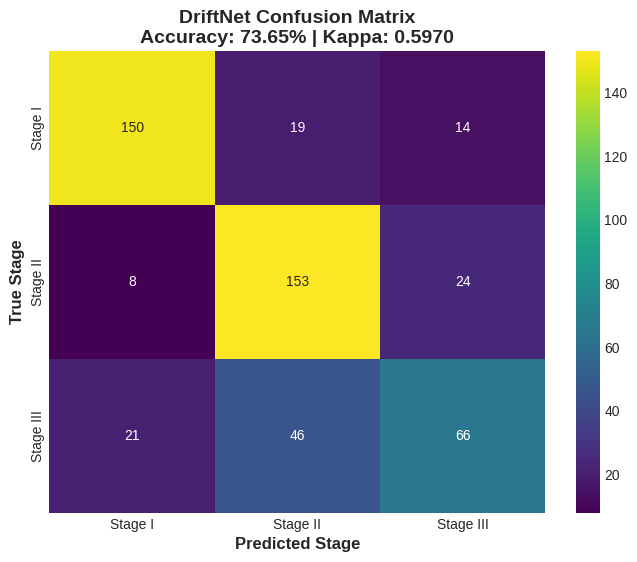

1/6: Confusion Matrix saved and displayed


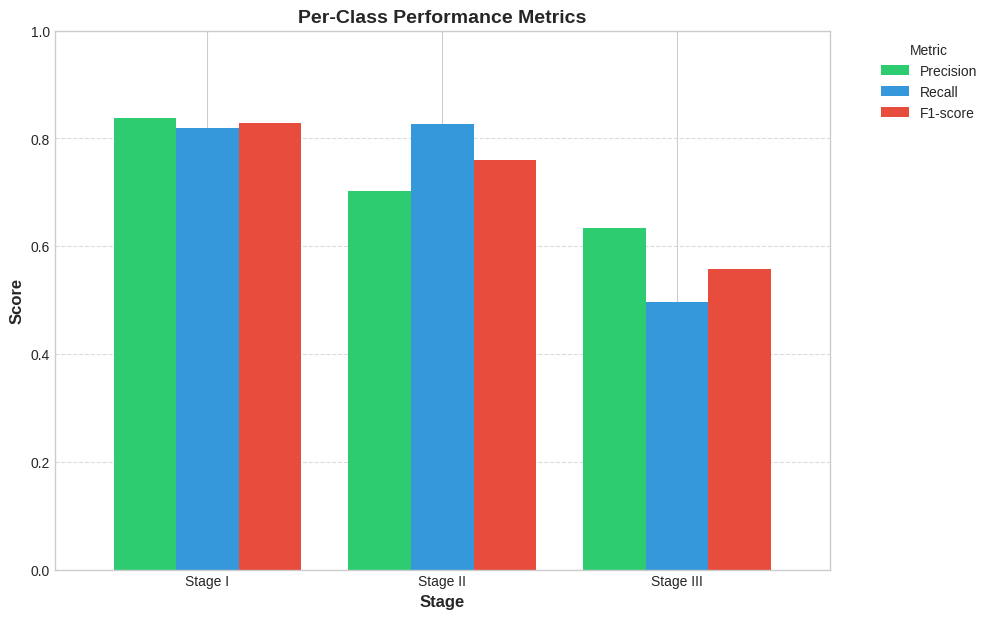

2/6: Performance Bars saved and displayed


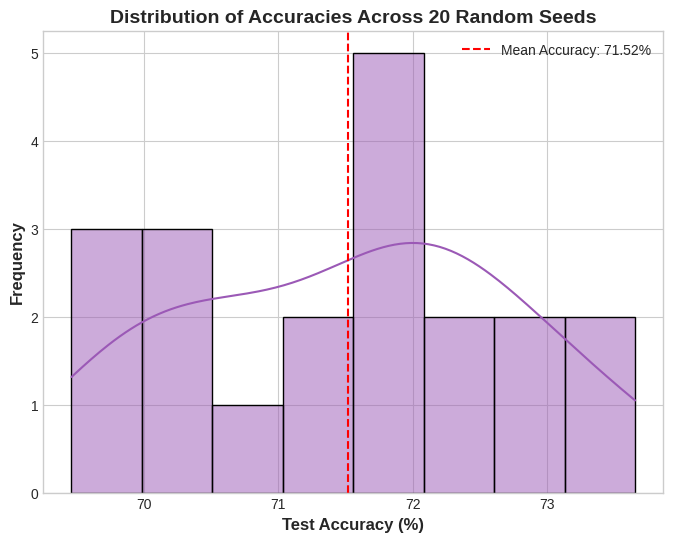

3/6: Accuracy Distribution saved and displayed


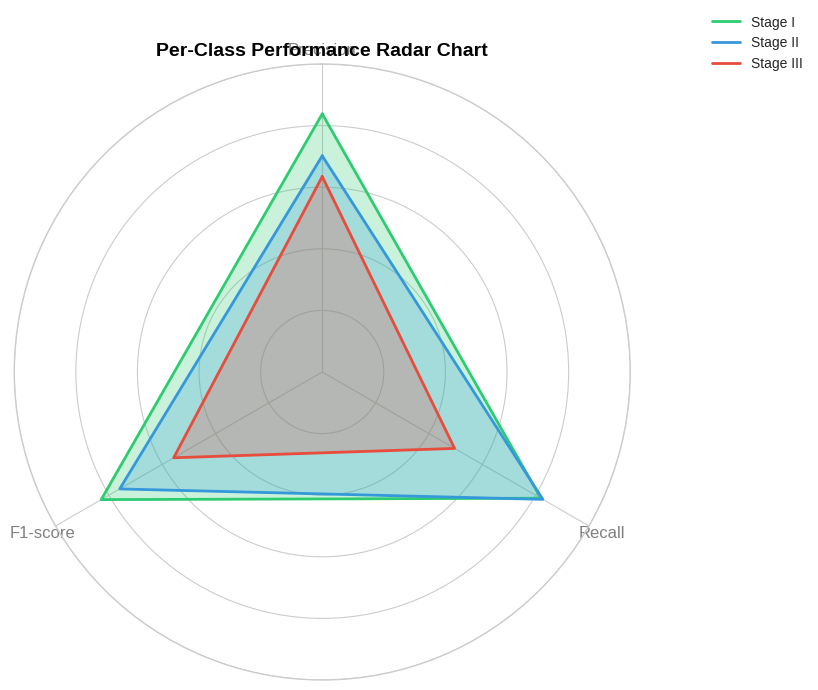

4/6: Radar Chart saved and displayed


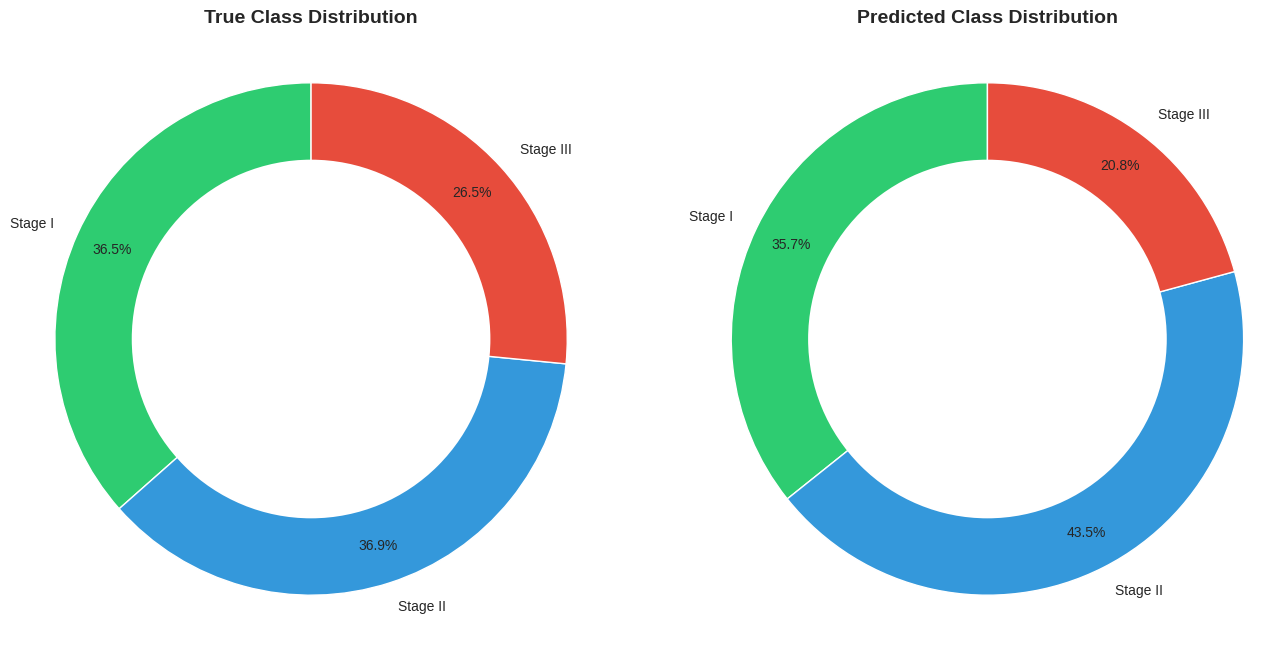

5/6: Donut Charts saved and displayed


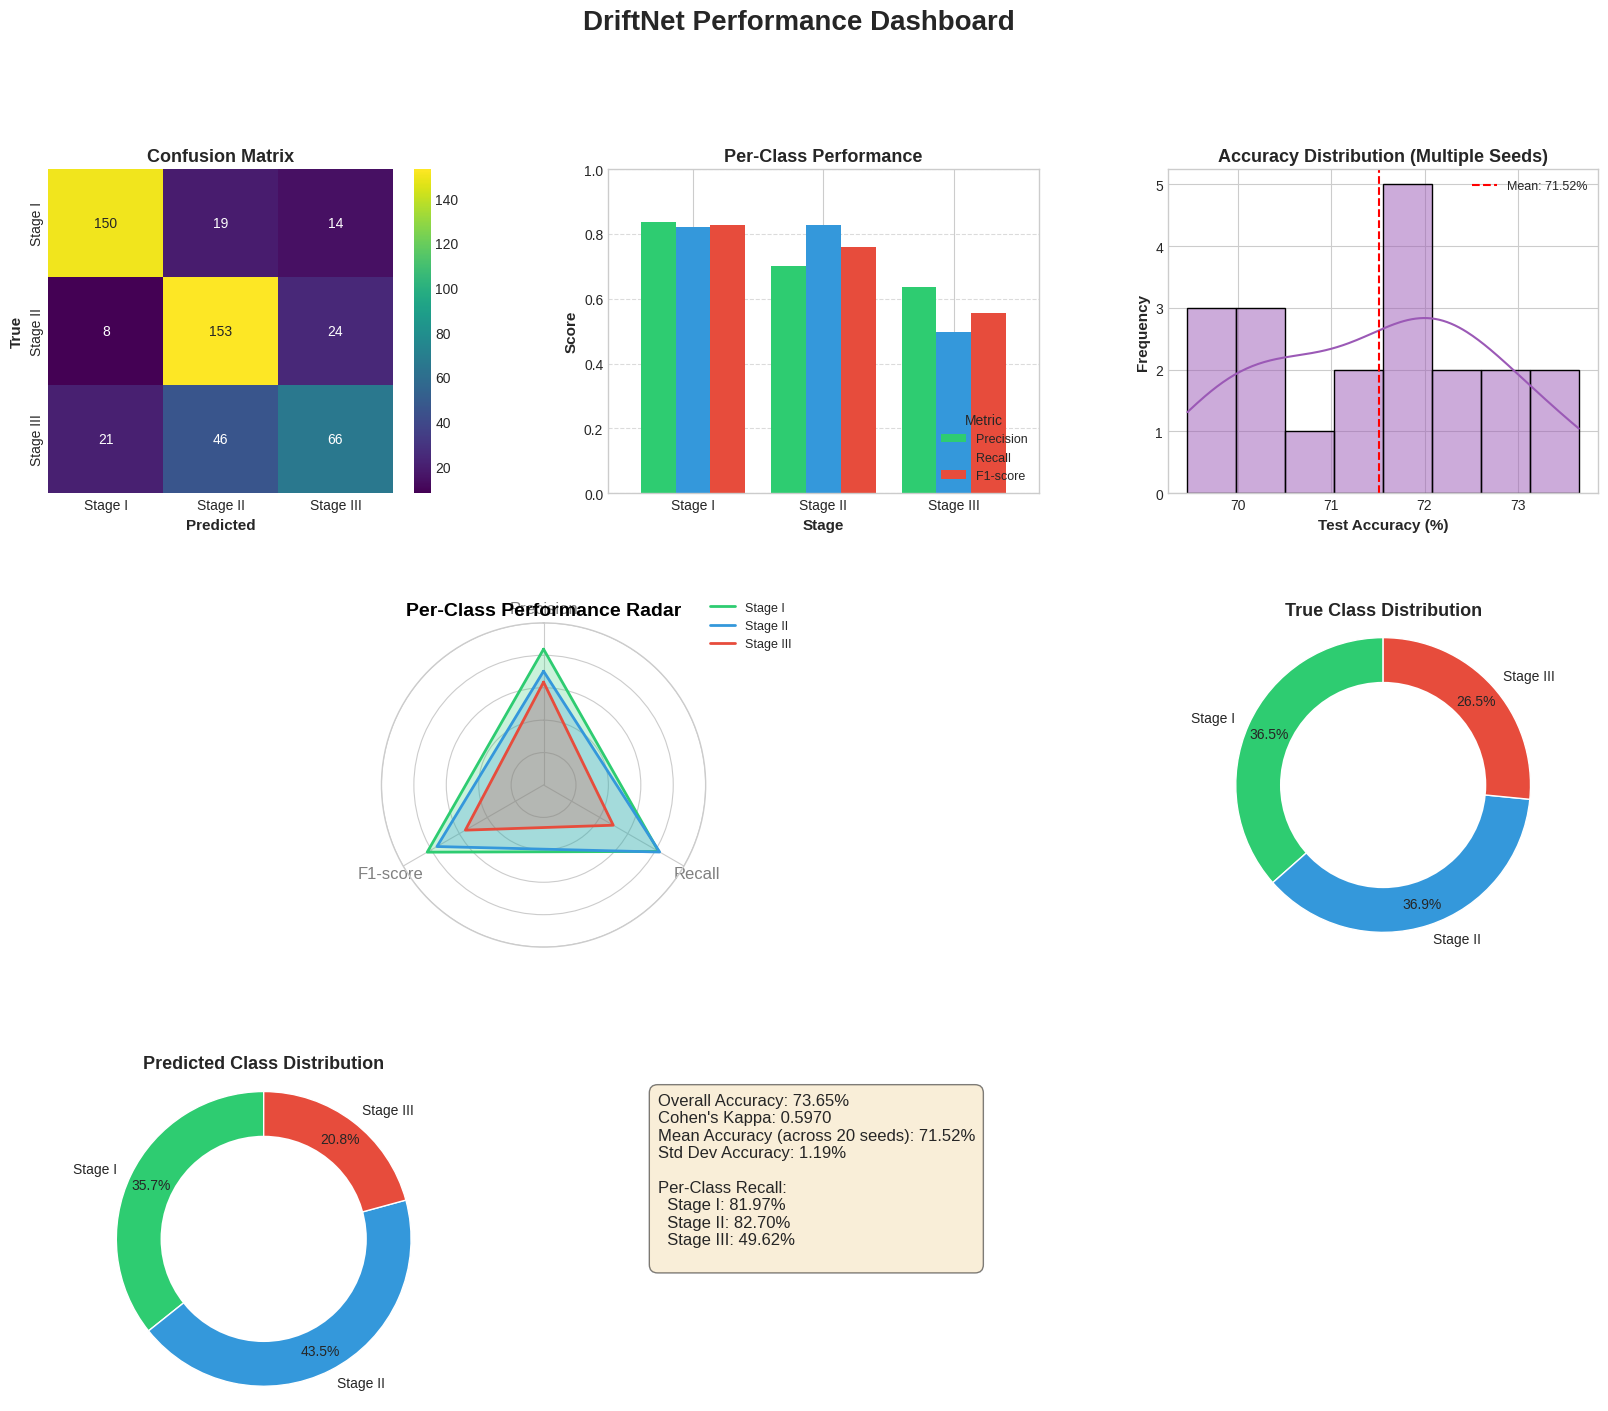

6/6: Complete Dashboard saved and displayed

Saved: 12 files high quality for paper (6 PNG + 6 PDF) and show on terminal


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score
import io
from math import pi
import random
from IPython.display import display, HTML

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-v0_8-whitegrid')

save_dir = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Random/'

best_pred_df = pd.read_csv(f'{save_dir}predictions.csv')
y_test = best_pred_df['True'].values
best_pred = best_pred_df['Predicted'].values

all_results_df = pd.read_csv(f'{save_dir}auto_seeds_results.csv')
all_accuracies = all_results_df['accuracy'].values

stage_names = ['Stage I', 'Stage II', 'Stage III']
stage_colors = ['#2ecc71', '#3498db', '#e74c3c']

def save_and_show(fig, filename_prefix):
    fig.savefig(f'{save_dir}{filename_prefix}.png', bbox_inches='tight', facecolor='white')
    fig.savefig(f'{save_dir}{filename_prefix}.pdf', bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close(fig)

print("Generating visualizations...")

cm = confusion_matrix(y_test, best_pred)
test_acc = accuracy_score(y_test, best_pred)
kappa = cohen_kappa_score(y_test, best_pred)

fig1, ax1 = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=stage_names, yticklabels=stage_names, ax=ax1)
ax1.set_xlabel('Predicted Stage', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Stage', fontsize=12, fontweight='bold')
ax1.set_title(f'DriftNet Confusion Matrix\nAccuracy: {test_acc*100:.2f}% | Kappa: {kappa:.4f}', fontsize=14, fontweight='bold')
save_and_show(fig1, 'Confusion_Matrix')
print("1/6: Confusion Matrix saved and displayed")

report = classification_report(y_test, best_pred, target_names=stage_names, output_dict=True)

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score'],
    'Stage I': [report['Stage I']['precision'], report['Stage I']['recall'], report['Stage I']['f1-score']],
    'Stage II': [report['Stage II']['precision'], report['Stage II']['recall'], report['Stage II']['f1-score']],
    'Stage III': [report['Stage III']['precision'], report['Stage III']['recall'], report['Stage III']['f1-score']]
}).set_index('Metric')

fig2, ax2 = plt.subplots(figsize=(10, 7))
metrics_df.T.plot(kind='bar', ax=ax2, width=0.8, color=['#2ecc71', '#3498db', '#e74c3c'])
ax2.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_xlabel('Stage', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=0)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
save_and_show(fig2, 'Performance_Bars')
print("2/6: Performance Bars saved and displayed")

fig3, ax3 = plt.subplots(figsize=(8, 6))
sns.histplot(all_accuracies * 100, bins=8, kde=True, ax=ax3, color='#9b59b6', edgecolor='black')
ax3.set_title(f'Distribution of Accuracies Across {len(all_accuracies)} Random Seeds', fontsize=14, fontweight='bold')
ax3.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.axvline(np.mean(all_accuracies) * 100, color='red', linestyle='--', label=f'Mean Accuracy: {np.mean(all_accuracies)*100:.2f}%')
ax3.legend()
save_and_show(fig3, 'Accuracy_Distribution')
print("3/6: Accuracy Distribution saved and displayed")

def create_radar_chart(ax, metrics_data, title, labels):
    categories = list(metrics_data.index)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1], labels=categories, color='grey', size=12)
    ax.set_ylim(0, 1)

    for i, stage in enumerate(labels):
        values = metrics_data[stage].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=stage, color=stage_colors[i])
        ax.fill(angles, values, color=stage_colors[i], alpha=0.25)

    ax.set_title(title, size=14, color='black', position=(0.5, 1.1), fontweight='bold')

fig4 = plt.figure(figsize=(8, 8))
ax4 = fig4.add_subplot(111, polar=True)
create_radar_chart(ax4, metrics_df, 'Per-Class Performance Radar Chart', stage_names)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
save_and_show(fig4, 'Radar_Chart')
print("4/6: Radar Chart saved and displayed")

true_counts = pd.Series(y_test).value_counts().sort_index()
predicted_counts = pd.Series(best_pred).value_counts().sort_index()

fig5, (ax5_true, ax5_pred) = plt.subplots(1, 2, figsize=(16, 8))

ax5_true.pie(true_counts, labels=stage_names, autopct='%1.1f%%', startangle=90, colors=stage_colors,
             wedgeprops=dict(width=0.4, edgecolor='w'), pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax5_true.add_artist(centre_circle)
ax5_true.set_title('True Class Distribution', fontsize=14, fontweight='bold')
ax5_true.axis('equal')

ax5_pred.pie(predicted_counts, labels=stage_names, autopct='%1.1f%%', startangle=90, colors=stage_colors,
             wedgeprops=dict(width=0.4, edgecolor='w'), pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax5_pred.add_artist(centre_circle)
ax5_pred.set_title('Predicted Class Distribution', fontsize=14, fontweight='bold')
ax5_pred.axis('equal')

save_and_show(fig5, 'Donut_Charts')
print("5/6: Donut Charts saved and displayed")

fig6 = plt.figure(figsize=(20, 16))
gs = fig6.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

ax6_cm = fig6.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=stage_names, yticklabels=stage_names, ax=ax6_cm)
ax6_cm.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax6_cm.set_ylabel('True', fontsize=11, fontweight='bold')
ax6_cm.set_title('Confusion Matrix', fontsize=13, fontweight='bold')

ax6_bars = fig6.add_subplot(gs[0, 1])
metrics_df.T.plot(kind='bar', ax=ax6_bars, width=0.8, color=['#2ecc71', '#3498db', '#e74c3c'])
ax6_bars.set_title('Per-Class Performance', fontsize=13, fontweight='bold')
ax6_bars.set_ylabel('Score', fontsize=11, fontweight='bold')
ax6_bars.set_xlabel('Stage', fontsize=11, fontweight='bold')
ax6_bars.set_ylim(0, 1.0)
ax6_bars.legend(title='Metric', loc='lower right', fontsize=9)
ax6_bars.tick_params(axis='x', rotation=0)
ax6_bars.grid(axis='y', linestyle='--', alpha=0.7)

ax6_hist = fig6.add_subplot(gs[0, 2])
sns.histplot(all_accuracies * 100, bins=8, kde=True, ax=ax6_hist, color='#9b59b6', edgecolor='black')
ax6_hist.set_title('Accuracy Distribution (Multiple Seeds)', fontsize=13, fontweight='bold')
ax6_hist.set_xlabel('Test Accuracy (%)', fontsize=11, fontweight='bold')
ax6_hist.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax6_hist.axvline(np.mean(all_accuracies) * 100, color='red', linestyle='--', label=f'Mean: {np.mean(all_accuracies)*100:.2f}%')
ax6_hist.legend(fontsize=9)

ax6_radar = fig6.add_subplot(gs[1, 0:2], polar=True)
create_radar_chart(ax6_radar, metrics_df, 'Per-Class Performance Radar', stage_names)
ax6_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)

ax6_true_donut = fig6.add_subplot(gs[1, 2])
ax6_true_donut.pie(true_counts, labels=stage_names, autopct='%1.1f%%', startangle=90, colors=stage_colors,
                   wedgeprops=dict(width=0.4, edgecolor='w'), pctdistance=0.85, textprops={'fontsize': 10})
centre_circle_true = plt.Circle((0,0),0.70,fc='white')
ax6_true_donut.add_artist(centre_circle_true)
ax6_true_donut.set_title('True Class Distribution', fontsize=13, fontweight='bold')
ax6_true_donut.axis('equal')

ax6_pred_donut = fig6.add_subplot(gs[2, 0])
ax6_pred_donut.pie(predicted_counts, labels=stage_names, autopct='%1.1f%%', startangle=90, colors=stage_colors,
                   wedgeprops=dict(width=0.4, edgecolor='w'), pctdistance=0.85, textprops={'fontsize': 10})
centre_circle_pred = plt.Circle((0,0),0.70,fc='white')
ax6_pred_donut.add_artist(centre_circle_pred)
ax6_pred_donut.set_title('Predicted Class Distribution', fontsize=13, fontweight='bold')
ax6_pred_donut.axis('equal')

ax6_summary = fig6.add_subplot(gs[2, 1:])
ax6_summary.axis('off')
summary_text = f"Overall Accuracy: {test_acc*100:.2f}%\n" \
               f"Cohen's Kappa: {kappa:.4f}\n" \
               f"Mean Accuracy (across {len(all_accuracies)} seeds): {np.mean(all_accuracies)*100:.2f}%\n" \
               f"Std Dev Accuracy: {np.std(all_accuracies)*100:.2f}%\n\n" \
               f"Per-Class Recall:\n"
for i, stage in enumerate(stage_names):
    recall_val = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    summary_text += f"  {stage}: {recall_val*100:.2f}%\n"
ax6_summary.text(0.05, 0.95, summary_text, transform=ax6_summary.transAxes, fontsize=12, verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.suptitle('DriftNet Performance Dashboard', fontsize=20, fontweight='bold', y=0.98)
save_and_show(fig6, 'Complete_Dashboard')
print("6/6: Complete Dashboard saved and displayed")

print("\nSaved: 12 files high quality for paper (6 PNG + 6 PDF) and show on terminal")

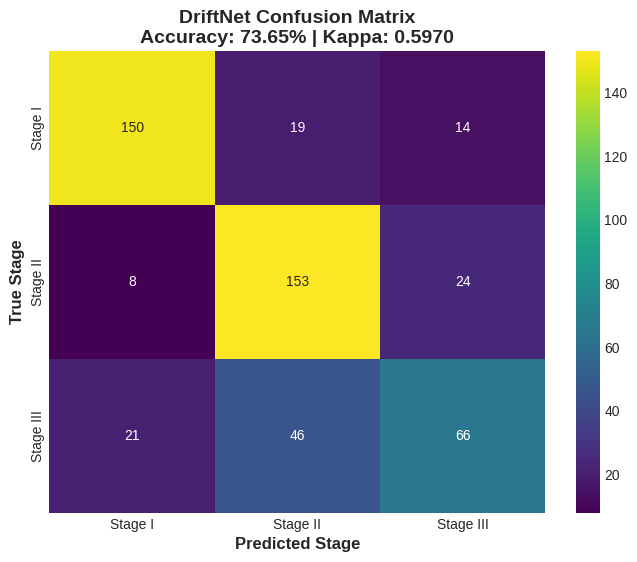

1/6: Confusion Matrix saved and displayed


In [23]:
cm = confusion_matrix(y_test, best_pred)
test_acc = accuracy_score(y_test, best_pred)
kappa = cohen_kappa_score(y_test, best_pred)

fig1, ax1 = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=stage_names, yticklabels=stage_names, ax=ax1)

ax1.set_xlabel('Predicted Stage', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Stage', fontsize=12, fontweight='bold')
ax1.set_title(f'DriftNet Confusion Matrix\nAccuracy: {test_acc*100:.2f}% | Kappa: {kappa:.4f}',
              fontsize=14, fontweight='bold')

save_and_show(fig1, 'Confusion_Matrix')
print("1/6: Confusion Matrix saved and displayed")


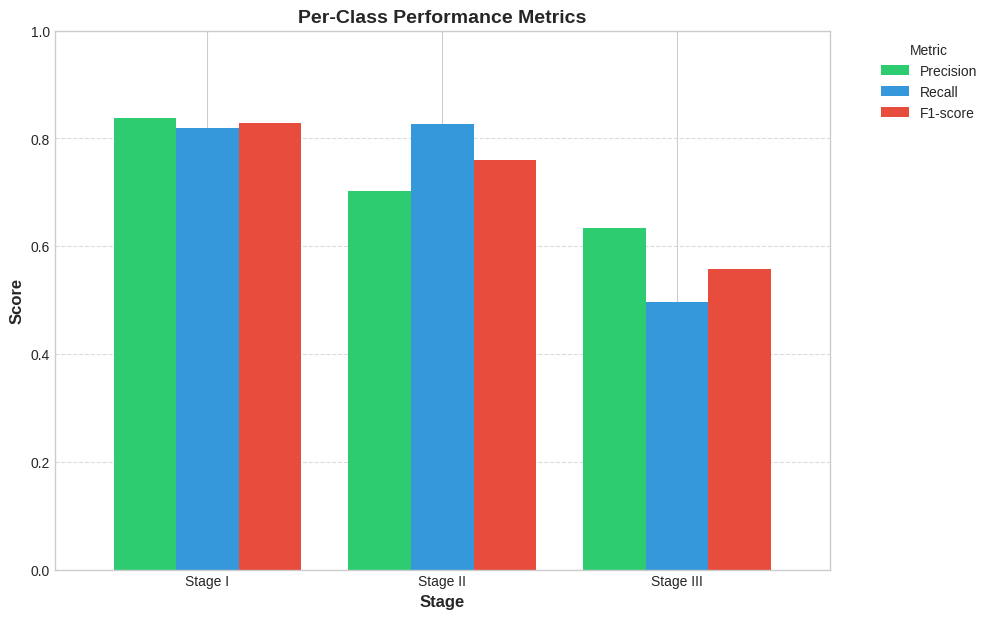

2/6: Performance Bars saved and displayed


In [24]:

report = classification_report(y_test, best_pred, target_names=stage_names, output_dict=True)

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score'],
    'Stage I': [report['Stage I']['precision'], report['Stage I']['recall'], report['Stage I']['f1-score']],
    'Stage II': [report['Stage II']['precision'], report['Stage II']['recall'], report['Stage II']['f1-score']],
    'Stage III': [report['Stage III']['precision'], report['Stage III']['recall'], report['Stage III']['f1-score']]
}).set_index('Metric')

fig2, ax2 = plt.subplots(figsize=(10, 7))
metrics_df.T.plot(kind='bar', ax=ax2, width=0.8,
                  color=['#2ecc71', '#3498db', '#e74c3c'])

ax2.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_xlabel('Stage', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=0)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

save_and_show(fig2, 'Performance_Bars')
print("2/6: Performance Bars saved and displayed")


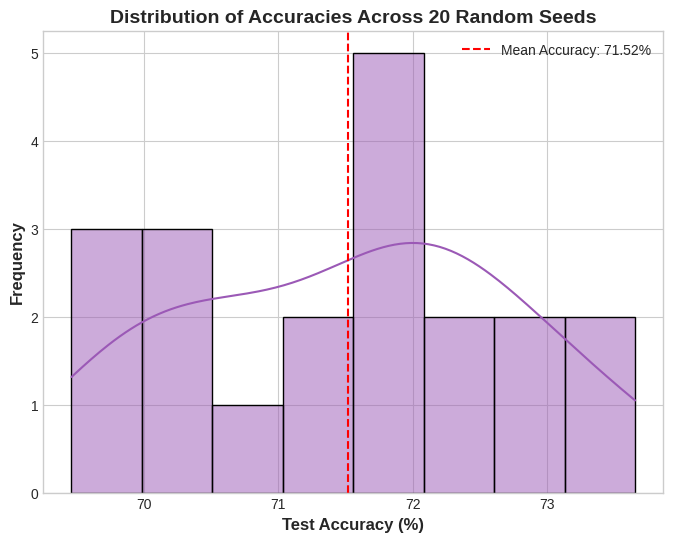

3/6: Accuracy Distribution saved and displayed


In [25]:

fig3, ax3 = plt.subplots(figsize=(8, 6))
sns.histplot(all_accuracies * 100, bins=8, kde=True,
             ax=ax3, color='#9b59b6', edgecolor='black')

ax3.set_title(f'Distribution of Accuracies Across {len(all_accuracies)} Random Seeds',
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.axvline(np.mean(all_accuracies) * 100, color='red', linestyle='--',
            label=f'Mean Accuracy: {np.mean(all_accuracies)*100:.2f}%')
ax3.legend()

save_and_show(fig3, 'Accuracy_Distribution')
print("3/6: Accuracy Distribution saved and displayed")


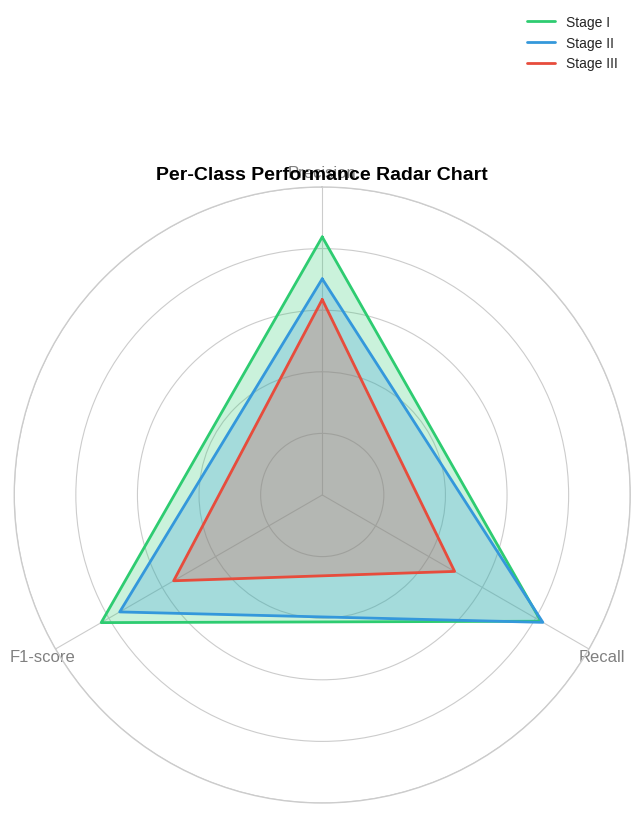

4/6: Radar Chart saved and displayed


In [26]:
fig4 = plt.figure(figsize=(8, 8))
ax4 = fig4.add_subplot(111, polar=True)

create_radar_chart(ax4, metrics_df, 'Per-Class Performance Radar Chart', stage_names)
ax4.legend(loc='upper right', bbox_to_anchor=(1.0, 1.3))

save_and_show(fig4, 'Radar_Chart')
print("4/6: Radar Chart saved and displayed")


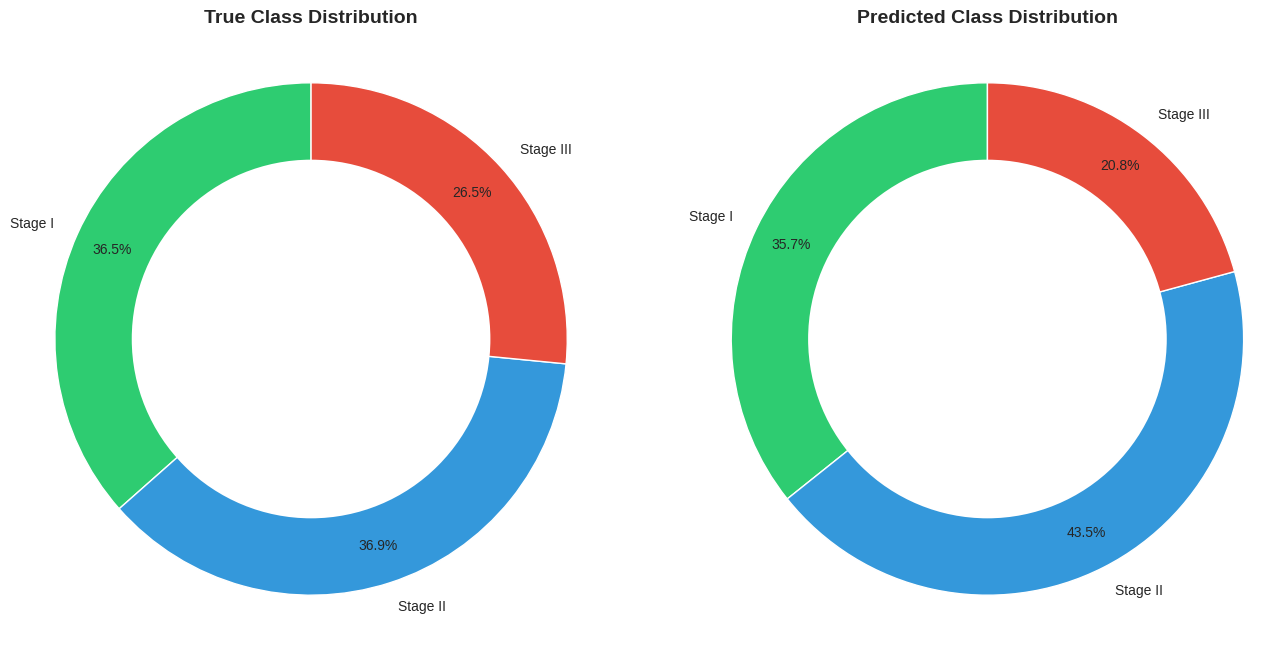

5/6: Donut Charts saved and displayed


In [27]:
true_counts = pd.Series(y_test).value_counts().sort_index()
predicted_counts = pd.Series(best_pred).value_counts().sort_index()

fig5, (ax5_true, ax5_pred) = plt.subplots(1, 2, figsize=(16, 8))

ax5_true.pie(true_counts, labels=stage_names, autopct='%1.1f%%',
             startangle=90, colors=stage_colors,
             wedgeprops=dict(width=0.4, edgecolor='w'),
             pctdistance=0.85)
ax5_true.add_artist(plt.Circle((0,0),0.70,fc='white'))
ax5_true.set_title('True Class Distribution', fontsize=14, fontweight='bold')
ax5_true.axis('equal')

ax5_pred.pie(predicted_counts, labels=stage_names, autopct='%1.1f%%',
             startangle=90, colors=stage_colors,
             wedgeprops=dict(width=0.4, edgecolor='w'),
             pctdistance=0.85)
ax5_pred.add_artist(plt.Circle((0,0),0.70,fc='white'))
ax5_pred.set_title('Predicted Class Distribution', fontsize=14, fontweight='bold')
ax5_pred.axis('equal')

save_and_show(fig5, 'Donut_Charts')
print("5/6: Donut Charts saved and displayed")


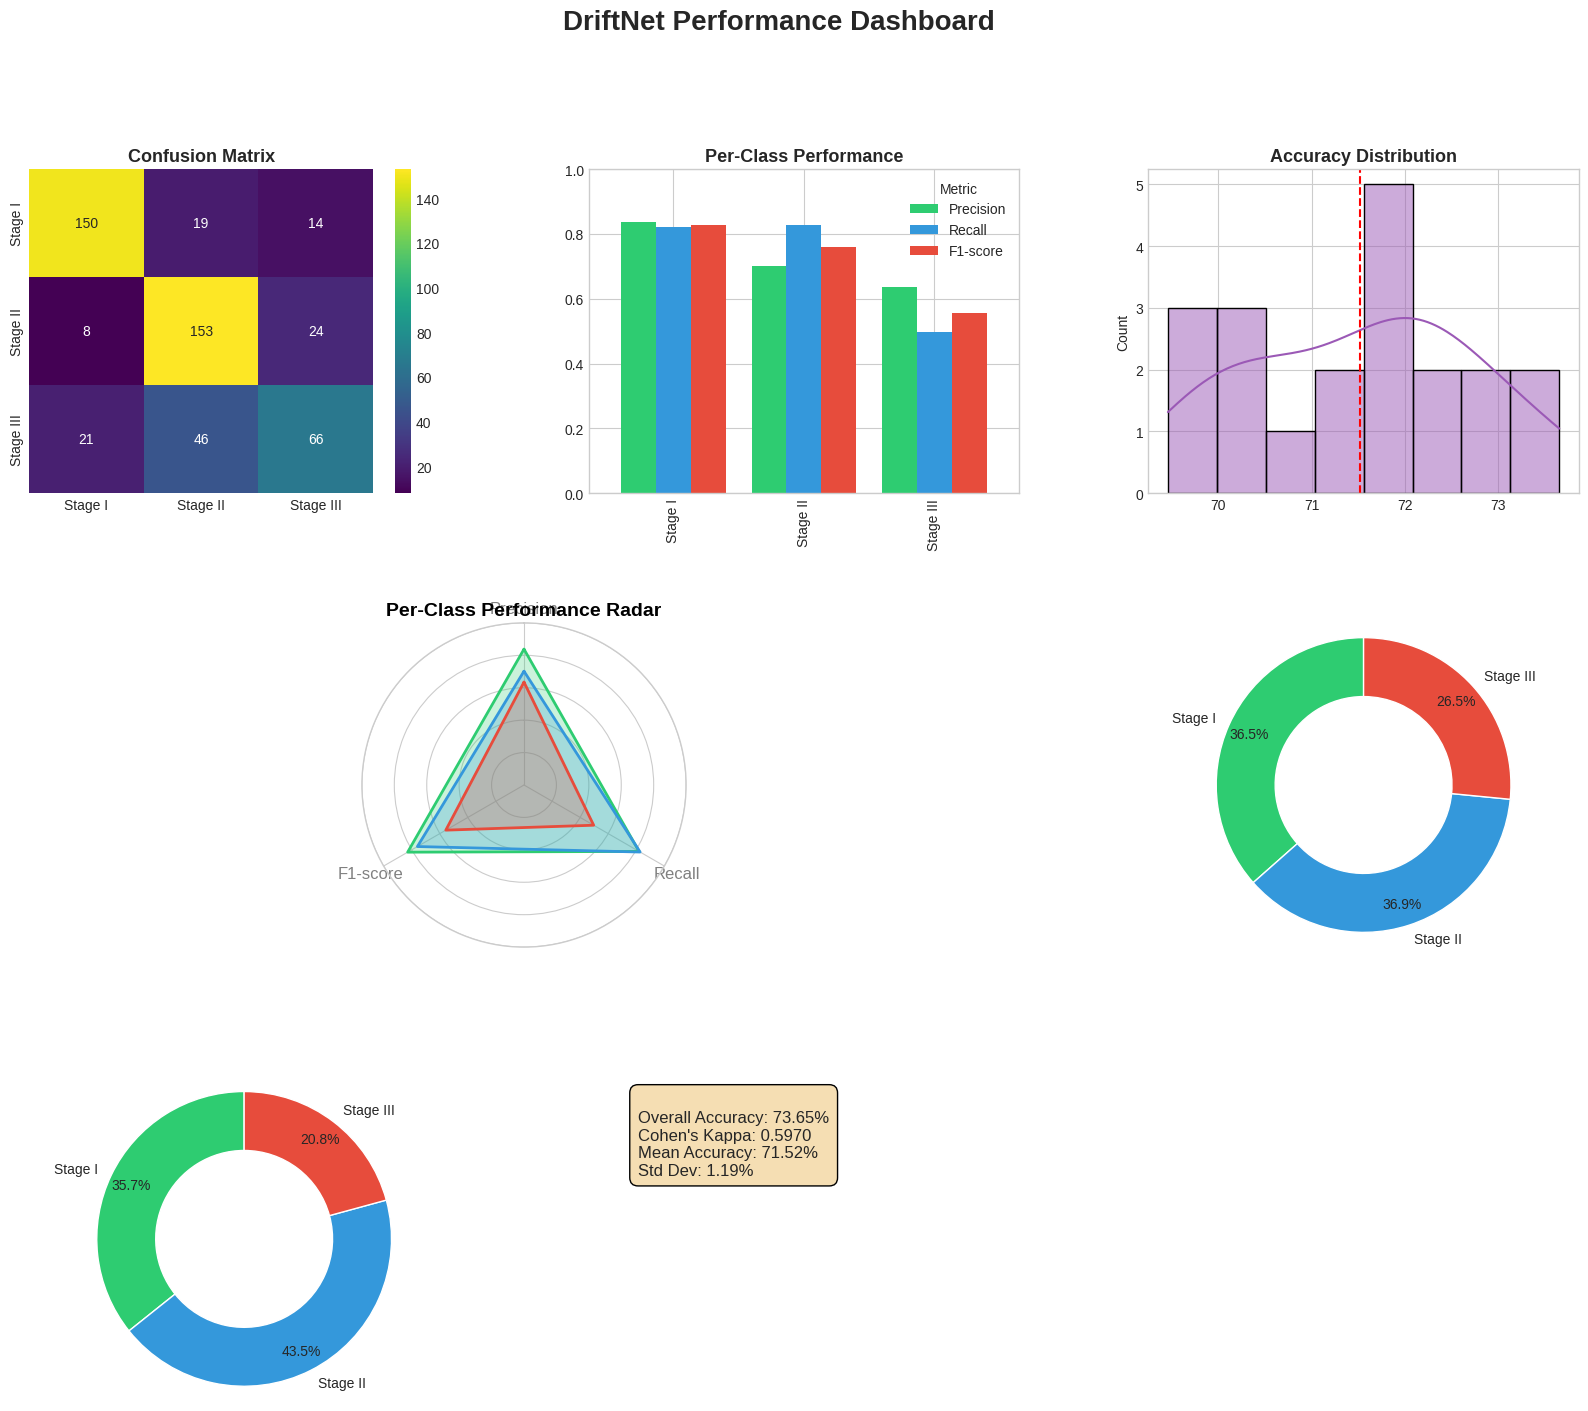

6/6: Complete Dashboard saved and displayed


In [28]:
fig6 = plt.figure(figsize=(20, 16))
gs = fig6.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

ax6_cm = fig6.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=stage_names, yticklabels=stage_names, ax=ax6_cm)
ax6_cm.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
ax6_bars = fig6.add_subplot(gs[0, 1])
metrics_df.T.plot(kind='bar', ax=ax6_bars, width=0.8,
                  color=['#2ecc71', '#3498db', '#e74c3c'])

ax6_bars.set_title('Per-Class Performance', fontsize=13, fontweight='bold')
ax6_bars.set_ylim(0, 1.0)

ax6_hist = fig6.add_subplot(gs[0, 2])
sns.histplot(all_accuracies * 100, bins=8, kde=True,
             ax=ax6_hist, color='#9b59b6')

ax6_hist.set_title('Accuracy Distribution', fontsize=13, fontweight='bold')
ax6_hist.axvline(np.mean(all_accuracies) * 100, color='red', linestyle='--')
ax6_radar = fig6.add_subplot(gs[1, 0:2], polar=True)
create_radar_chart(ax6_radar, metrics_df, 'Per-Class Performance Radar', stage_names)
ax6_true_donut = fig6.add_subplot(gs[1, 2])
ax6_true_donut.pie(true_counts, labels=stage_names, autopct='%1.1f%%',
                   startangle=90, colors=stage_colors,
                   wedgeprops=dict(width=0.4, edgecolor='w'),
                   pctdistance=0.85)
ax6_true_donut.axis('equal')

ax6_pred_donut = fig6.add_subplot(gs[2, 0])
ax6_pred_donut.pie(predicted_counts, labels=stage_names, autopct='%1.1f%%',
                   startangle=90, colors=stage_colors,
                   wedgeprops=dict(width=0.4, edgecolor='w'),
                   pctdistance=0.85)
ax6_pred_donut.axis('equal')

ax6_summary = fig6.add_subplot(gs[2, 1:])
ax6_summary.axis('off')
summary_text = f"""
Overall Accuracy: {test_acc*100:.2f}%
Cohen's Kappa: {kappa:.4f}
Mean Accuracy: {np.mean(all_accuracies)*100:.2f}%
Std Dev: {np.std(all_accuracies)*100:.2f}%"""

ax6_summary.text(0.05, 0.95, summary_text,
                 fontsize=12, transform=ax6_summary.transAxes,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='wheat'))

plt.suptitle('DriftNet Performance Dashboard',
             fontsize=20, fontweight='bold', y=0.98)

save_and_show(fig6, 'Complete_Dashboard')
print("6/6: Complete Dashboard saved and displayed")


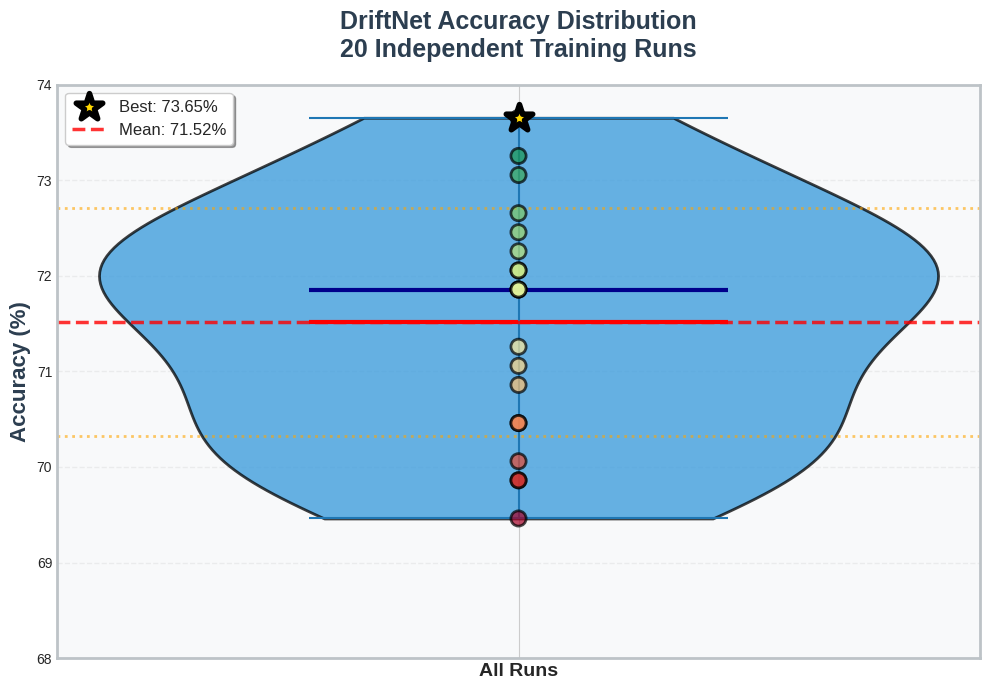

Accuracy Distribution saved and displayed



In [29]:

accuracies_percent = all_accuracies * 100
mean_acc_percent = np.mean(accuracies_percent)
std_acc_percent = np.std(accuracies_percent)

fig, ax = plt.subplots(figsize=(10, 7))

parts = ax.violinplot([accuracies_percent], positions=[1], widths=0.7,
                       showmeans=True, showmedians=True, showextrema=True)

for pc in parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_alpha(0.75)
    pc.set_edgecolor('black')
    pc.set_linewidth(2)

parts['cmeans'].set_color('red')
parts['cmeans'].set_linewidth(3)
parts['cmedians'].set_color('darkblue')
parts['cmedians'].set_linewidth(3)

ax.scatter([1]*len(accuracies_percent), accuracies_percent, alpha=0.7, s=120,
           c=accuracies_percent, cmap='RdYlGn', edgecolors='black', linewidth=2, zorder=3)

best_idx = np.argmax(accuracies_percent)
ax.scatter(1, accuracies_percent[best_idx], s=400, c='gold', edgecolors='black',
           linewidth=4, marker='*', zorder=4, label=f'Best: {accuracies_percent[best_idx]:.2f}%')

ax.axhline(mean_acc_percent, color='red', linestyle='--', linewidth=2.5, alpha=0.8,
           label=f'Mean: {mean_acc_percent:.2f}%')
ax.axhline(mean_acc_percent + std_acc_percent, color='orange', linestyle=':', linewidth=2, alpha=0.6)
ax.axhline(mean_acc_percent - std_acc_percent, color='orange', linestyle=':', linewidth=2, alpha=0.6)

ax.set_ylabel('Accuracy (%)', fontsize=16, fontweight='bold', color='#2c3e50')
ax.set_title('DriftNet Accuracy Distribution\n20 Independent Training Runs',
             fontsize=18, fontweight='bold', pad=20, color='#2c3e50')
ax.set_xticks([1])
ax.set_xticklabels(['All Runs'], fontsize=14, fontweight='bold')
ax.set_ylim([68, 74])
ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, fancybox=True)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax.set_facecolor('#f8f9fa')

for spine in ax.spines.values():
    spine.set_edgecolor('#bdc3c7')
    spine.set_linewidth(2)

fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(f'{save_dir}Fig3_AccuracyDistribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_dir}Fig3_AccuracyDistribution.pdf', bbox_inches='tight', facecolor='white')
plt.show()
print("Accuracy Distribution saved and displayed\n")

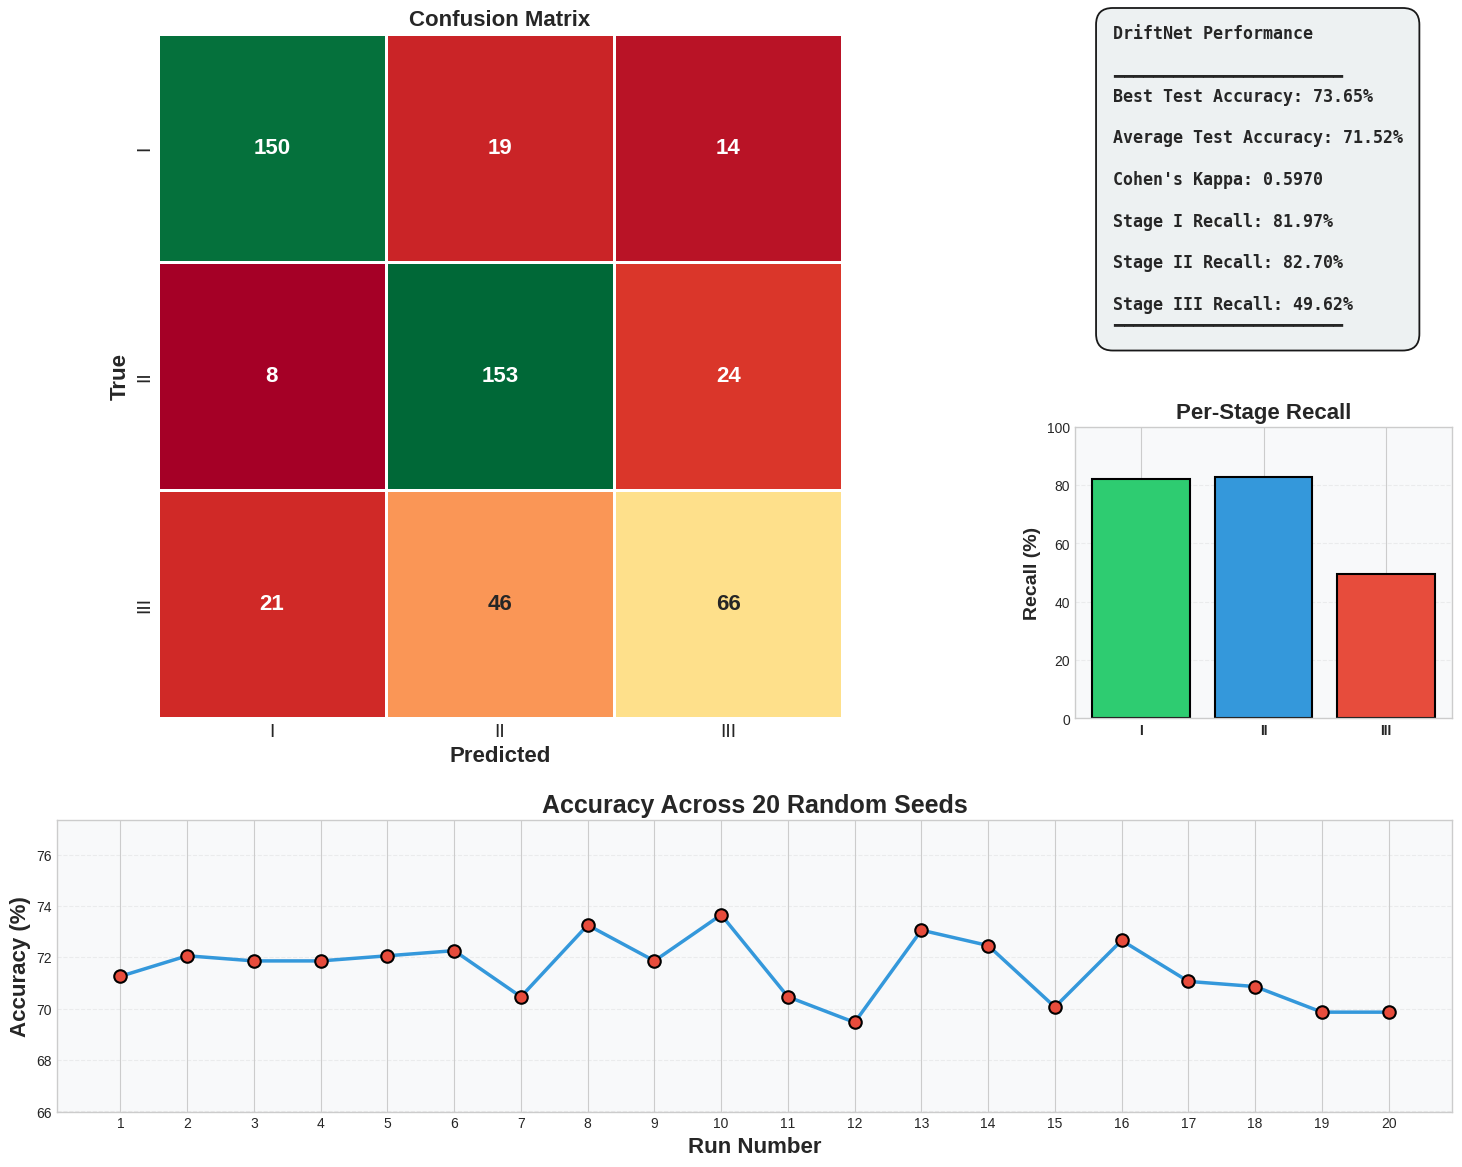

Combined Dashboard saved and displayed


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import os

save_dir = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Random/'

best_pred_df = pd.read_csv(f'{save_dir}predictions.csv')
y_test = best_pred_df['True'].values
best_pred = best_pred_df['Predicted'].values

all_results_df = pd.read_csv(f'{save_dir}auto_seeds_results.csv')
all_accuracies = all_results_df['accuracy'].values
accuracies_percent = all_accuracies * 100

cm = confusion_matrix(y_test, best_pred)
test_acc = accuracy_score(y_test, best_pred)
kappa = cohen_kappa_score(y_test, best_pred)

stage_names = ['Stage I', 'Stage II', 'Stage III']

recalls = []
for i in range(len(stage_names)):
    recall = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    recalls.append(recall * 100)

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# Confusion Matrix
ax1 = fig.add_subplot(gs[0:2, 0:2])
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            linewidths=2, linecolor='white', square=True,
            annot_kws={'size': 16, 'weight': 'bold'}, ax=ax1, cbar=False)
ax1.set_xlabel('Predicted', fontweight='bold', fontsize=16)
ax1.set_ylabel('True', fontweight='bold', fontsize=16)
ax1.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
ax1.set_xticklabels(['I', 'II', 'III'], fontsize=14)
ax1.set_yticklabels(['I', 'II', 'III'], fontsize=14)

# Metrics Box
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
mean_acc_percent = np.mean(all_accuracies) * 100
summary_text = f"DriftNet Performance\n\n━━━━━━━━━━━━━━━━━━━━━━━\nBest Test Accuracy: {test_acc*100:.2f}%\n\nAverage Test Accuracy: {mean_acc_percent:.2f}%\n\nCohen's Kappa: {kappa:.4f}\n\nStage I Recall: {recalls[0]:.2f}%\n\nStage II Recall: {recalls[1]:.2f}%\n\nStage III Recall: {recalls[2]:.2f}%\n━━━━━━━━━━━━━━━━━━━━━━━"
ax2.text(0.1, 0.5, summary_text, fontsize=12, fontfamily='monospace', fontweight='bold',
         bbox=dict(boxstyle='round,pad=1', facecolor='#ecf0f1', alpha=0.9, edgecolor='black', linewidth=1.3),
         verticalalignment='center')

# Per-Stage Bars
ax3 = fig.add_subplot(gs[1, 2])
ax3.bar(range(3), recalls, color=['#2ecc71', '#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(3))
ax3.set_xticklabels(['I', 'II', 'III'], fontweight='bold')
ax3.set_ylabel('Recall (%)', fontweight='bold', fontsize=14)
ax3.set_title('Per-Stage Recall', fontsize=16, fontweight='bold')
ax3.set_ylim([0, 100])
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_facecolor('#f8f9fa')

# Accuracy Timeline
ax4 = fig.add_subplot(gs[2, :])
ax4.plot(range(1, len(accuracies_percent) + 1), accuracies_percent, marker='o', linewidth=2.5, markersize=9,
         color='#3498db', markerfacecolor='#e74c3c', markeredgecolor='black', markeredgewidth=1.5)
ax4.set_xlabel('Run Number', fontweight='bold', fontsize=16)
ax4.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=16)
ax4.set_title('Accuracy Across 20 Random Seeds', fontsize=18, fontweight='bold')
ax4.set_xticks(range(1, len(accuracies_percent) + 1))
ax4.set_ylim(min(accuracies_percent) * 0.95, max(accuracies_percent) * 1.05)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_facecolor('#f8f9fa')

fig.patch.set_facecolor('white')
plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.savefig(f'{save_dir}DriftNet_Combined_Dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_dir}DriftNet_Combined_Dashboard.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Combined Dashboard saved and displayed")

Generating ROC curves for the validation set (Best Model)...


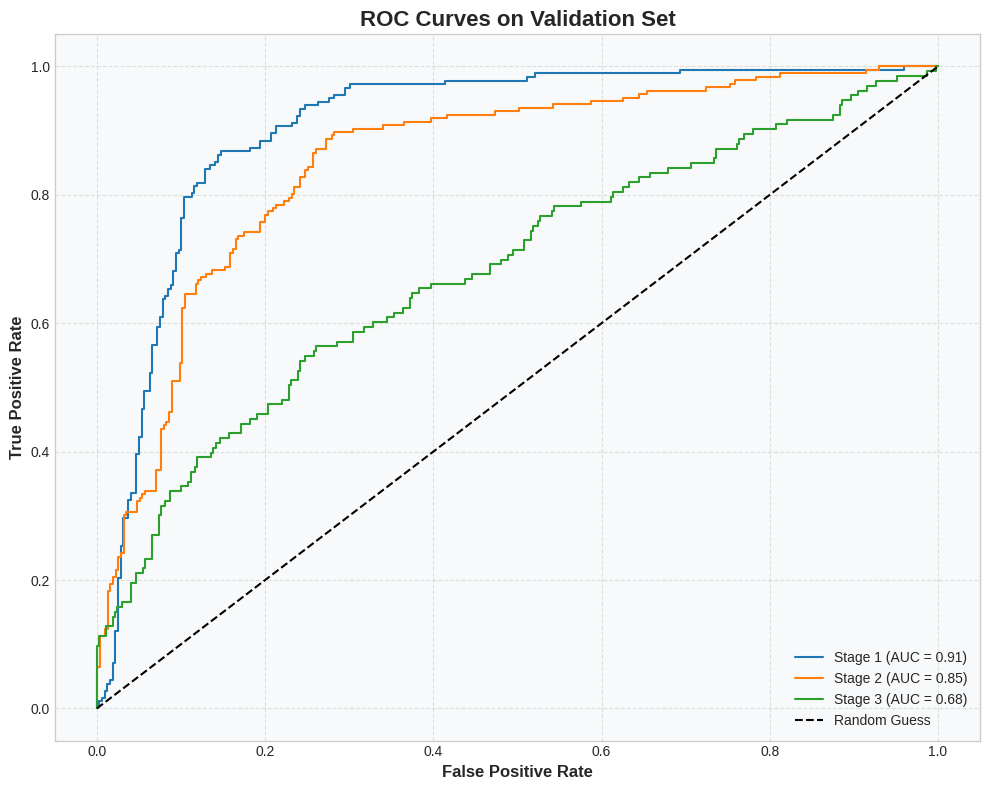

ROC curves generated and saved for the Best Model.


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

print("Generating ROC curves for the validation set (Best Model)...")

y_pred_proba = best_model.predict([X_cont_val, X_clin_val], verbose=0)

y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Stage {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves on Validation Set', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f8f9fa')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/ROC_Validation_Best_Model_60_20_20.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves generated and saved for the Best Model.")

Generating Combined ROC + Accuracy Figure...


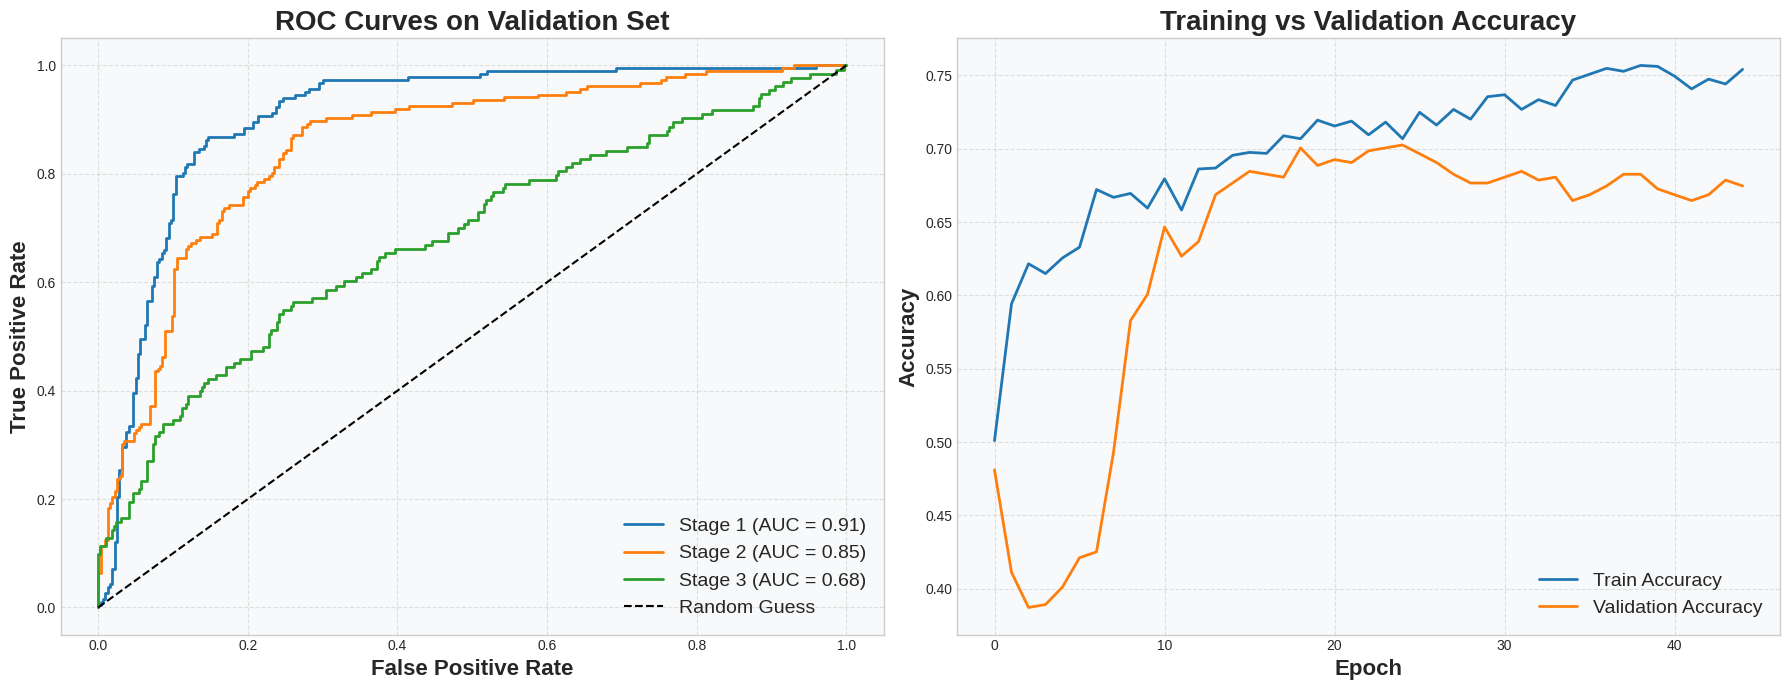

Combined ROC + Accuracy figure generated and saved!


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

print("Generating Combined ROC + Accuracy Figure...")

y_pred_proba = best_model.predict([X_cont_val, X_clin_val], verbose=0)
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

ax = axes[0]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Stage {i+1} (AUC = {roc_auc:.2f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')

ax.set_xlabel('False Positive Rate', fontsize=16, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=16, fontweight='bold')
ax.set_title('ROC Curves on Validation Set', fontsize=20, fontweight='bold')
ax.legend(loc='lower right', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_facecolor('#f8f9fa')

ax = axes[1]

ax.plot(best_history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax.plot(best_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)

ax.set_title('Training vs Validation Accuracy', fontsize=20, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_facecolor('#f8f9fa')

fig.patch.set_facecolor('white')
plt.tight_layout()

save_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/'
plt.savefig(f'{save_path}Combined_ROC_Accuracy.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{save_path}Combined_ROC_Accuracy.pdf', bbox_inches='tight')

plt.show()

print("Combined ROC + Accuracy figure generated and saved!")


Generating Learning Curves (Best Model)...


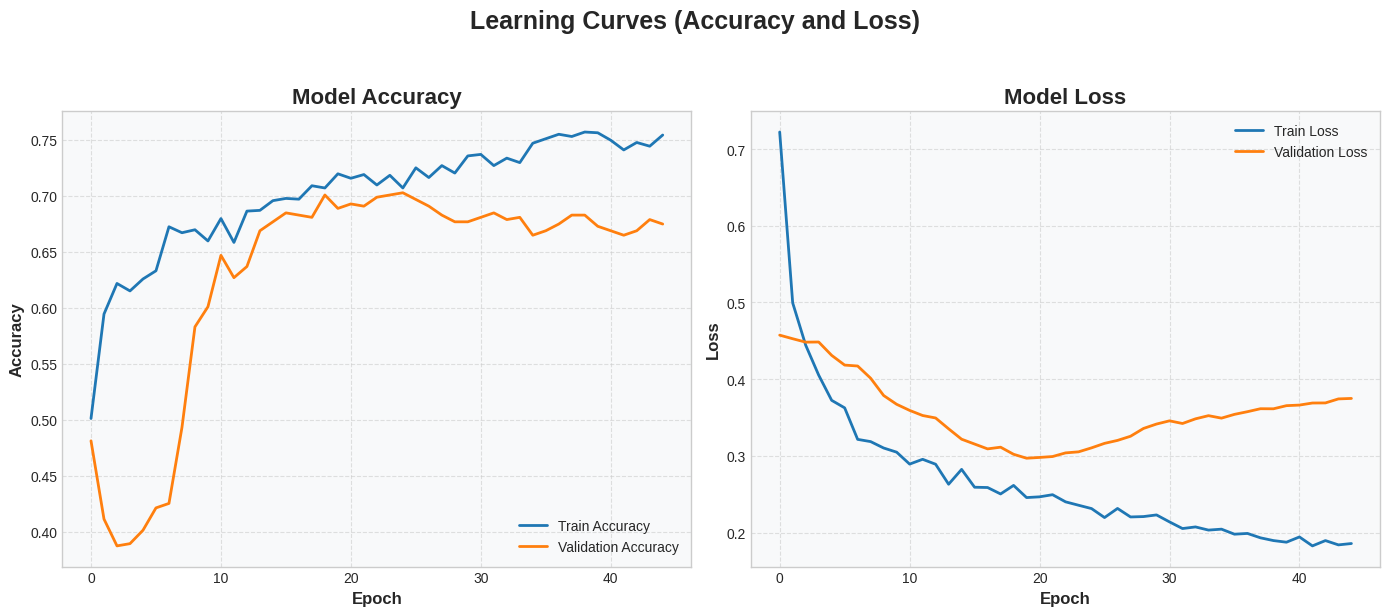

Learning curves generated and saved for the Best Model.


In [32]:
import matplotlib.pyplot as plt

print("Generating Learning Curves (Best Model)...")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f8f9fa')

plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(best_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f8f9fa')

plt.suptitle('Learning Curves (Accuracy and Loss)', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Learning_Curves_Best_Model_60_20_20.png', dpi=300, bbox_inches='tight')
plt.show()

print("Learning curves generated and saved for the Best Model.")

Generating ROC curves and Learning Curves (Best Model)...


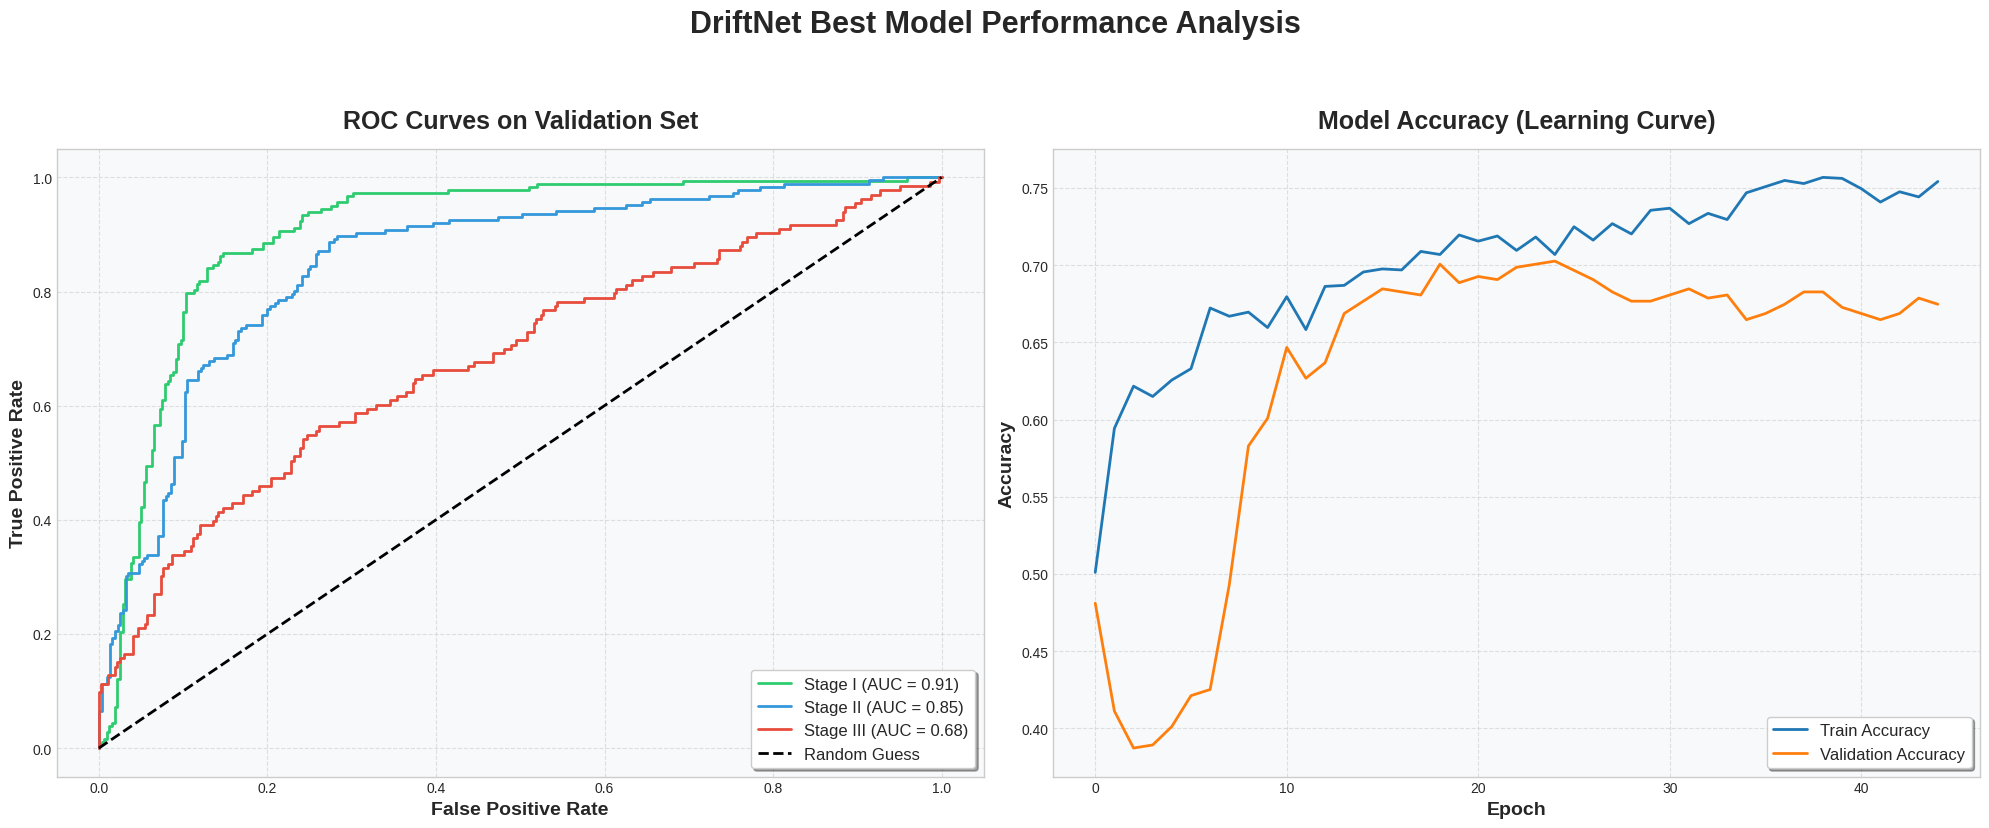

Combined ROC and Learning Curves generated and saved for the Best Model.


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

print("Generating ROC curves and Learning Curves (Best Model)...")

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

y_pred_proba = best_model.predict([X_cont_val, X_clin_val], verbose=0)

y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

colors = ['#3498db', '#3498db', '#2ecc71']
stage_labels = ['Stage I', 'Stage II', 'Stage III']

ax_roc = axes[0]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, color=colors[i], lw=2, label=f'{stage_labels[i]} (AUC = {roc_auc:.2f})')

ax_roc.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
ax_roc.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax_roc.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax_roc.set_title('ROC Curves on Validation Set', fontsize=18, fontweight='bold', pad=15)
ax_roc.legend(loc='lower right', fontsize=12, frameon=True, shadow=True, fancybox=True)
ax_roc.grid(True, linestyle='--', alpha=0.6)
ax_roc.set_facecolor('#f8f9fa')

ax_learning = axes[1]
ax_learning.plot(best_history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#1f77b4')
ax_learning.plot(best_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#ff7f0e')
ax_learning.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax_learning.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax_learning.set_title('Model Accuracy (Learning Curve)', fontsize=18, fontweight='bold', pad=15)
ax_learning.legend(loc='lower right', fontsize=12, frameon=True, shadow=True, fancybox=True)
ax_learning.grid(True, linestyle='--', alpha=0.6)
ax_learning.set_facecolor('#f8f9fa')

plt.suptitle('DriftNet Best Model Performance Analysis', fontsize=22, fontweight='bold', y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98])

save_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/'
plt.savefig(f'{save_path}ROC_and_Learning_Curves_Best_Model.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}ROC_and_Learning_Curves_Best_Model.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Combined ROC and Learning Curves generated and saved for the Best Model.")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

print("Generating ROC curves and Learning Curves (Best Model)...")

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

y_pred_proba = best_model.predict([X_cont_val, X_clin_val], verbose=0)

y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

colors = ['#2ecc71', '#3498db', '#e74c3c']
stage_labels = ['Stage I', 'Stage II', 'Stage III']

ax_roc = axes[0]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, color=colors[i], lw=2, label=f'{stage_labels[i]} (AUC = {roc_auc:.2f})')

ax_roc.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
ax_roc.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax_roc.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax_roc.set_title('ROC Curves on Validation Set', fontsize=18, fontweight='bold', pad=15)
ax_roc.legend(loc='lower right', fontsize=12, frameon=True, shadow=True, fancybox=True)
ax_roc.grid(True, linestyle='--', alpha=0.6)
ax_roc.set_facecolor('#f8f9fa')

ax_learning = axes[1]
ax_learning.plot(best_history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#1f77b4')
ax_learning.plot(best_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#ff7f0e')
ax_learning.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax_learning.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax_learning.set_title('Model Accuracy (Learning Curve)', fontsize=18, fontweight='bold', pad=15)
ax_learning.legend(loc='lower right', fontsize=12, frameon=True, shadow=True, fancybox=True)
ax_learning.grid(True, linestyle='--', alpha=0.6)
ax_learning.set_facecolor('#f8f9fa')

plt.suptitle('DriftNet Best Model Performance Analysis', fontsize=22, fontweight='bold', y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98])

save_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/'
plt.savefig(f'{save_path}ROC_and_Learning_Curves_Best_Model.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_path}ROC_and_Learning_Curves_Best_Model.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Combined ROC and Learning Curves generated and saved for the Best Model.")

## Cross-Validation Setup


In [37]:
print("\n[STEP 1] Loading preprocessed data...")
X_contrastive = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_contrastive.npy')
X_clinical = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_clinical.npy')
y = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/y.npy')

print(f"   X_contrastive shape: {X_contrastive.shape}")
print(f"   X_clinical shape: {X_clinical.shape}")
print(f"   y shape: {y.shape}")


[STEP 1] Loading preprocessed data...
   X_contrastive shape: (2503, 128)
   X_clinical shape: (2503, 13)
   y shape: (2503,)


In [38]:
print("\n[STEP 2] Scaling clinical features and setting up StratifiedKFold...")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_clin_scaled = scaler.fit_transform(X_clinical).astype(np.float32)
print(f"   X_clinical scaled shape: {X_clin_scaled.shape}")

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"   StratifiedKFold initialized with {skf.get_n_splits(X_contrastive, y)} splits.")

print("\n[STEP 3] Confirming split details for each StratifiedKFold...")

for fold, (train_index, test_index) in enumerate(skf.split(X_contrastive, y)):
    print(f"\n--- Fold {fold + 1}/{skf.get_n_splits(X_contrastive, y)} ---")
    print(f"   Train indices shape: {train_index.shape}")
    print(f"   Test indices shape: {test_index.shape}")
    print(f"   Train samples: {len(train_index)}")
    print(f"   Test samples: {len(test_index)}")

    unique_train, counts_train = np.unique(y[train_index], return_counts=True)
    unique_test, counts_test = np.unique(y[test_index], return_counts=True)
    print(f"   Train class distribution: {dict(zip(unique_train, counts_train))}")
    print(f"   Test class distribution: {dict(zip(unique_test, counts_test))}")

print("\n[STEP 4] Preparing data splits and calculating class weights for each fold...")

fold_accuracies = []
fold_classification_reports = []
fold_confusion_matrices = []

for fold, (train_index, test_index) in enumerate(skf.split(X_contrastive, y)):
    print(f"\n--- Processing Fold {fold + 1}/{skf.get_n_splits(X_contrastive, y)} ---")

    X_cont_train = X_contrastive[train_index]
    X_cont_test = X_contrastive[test_index]

    X_clin_train = X_clin_scaled[train_index]
    X_clin_test = X_clin_scaled[test_index]

    y_train = y[train_index]
    y_test = y[test_index]

    from sklearn.utils import compute_class_weight
    class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: w for i, w in enumerate(class_weights_array)}

    print(f"   X_contrastive train shape: {X_cont_train.shape}")
    print(f"   X_contrastive test shape: {X_cont_test.shape}")
    print(f"   X_clinical train shape: {X_clin_train.shape}")
    print(f"   X_clinical test shape: {X_clin_test.shape}")
    print(f"   y_train shape: {y_train.shape}")
    print(f"   y_test shape: {y_test.shape}")
    print(f"   Class weights for current fold: {class_weights}")



[STEP 2] Scaling clinical features and setting up StratifiedKFold...
   X_clinical scaled shape: (2503, 13)
   StratifiedKFold initialized with 5 splits.

[STEP 3] Confirming split details for each StratifiedKFold...

--- Fold 1/5 ---
   Train indices shape: (2002,)
   Test indices shape: (501,)
   Train samples: 2002
   Test samples: 501
   Train class distribution: {np.int64(0): np.int64(729), np.int64(1): np.int64(741), np.int64(2): np.int64(532)}
   Test class distribution: {np.int64(0): np.int64(182), np.int64(1): np.int64(186), np.int64(2): np.int64(133)}

--- Fold 2/5 ---
   Train indices shape: (2002,)
   Test indices shape: (501,)
   Train samples: 2002
   Test samples: 501
   Train class distribution: {np.int64(0): np.int64(729), np.int64(1): np.int64(741), np.int64(2): np.int64(532)}
   Test class distribution: {np.int64(0): np.int64(182), np.int64(1): np.int64(186), np.int64(2): np.int64(133)}

--- Fold 3/5 ---
   Train indices shape: (2002,)
   Test indices shape: (501,)


In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

def build_best_driftnet(cont_dim=128, clin_dim=13):
    cont_input = keras.Input(shape=(cont_dim,))
    clin_input = keras.Input(shape=(clin_dim,))

    m = layers.Dense(256, activation='relu')(cont_input)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.3)(m)

    m = layers.Dense(128, activation='relu')(m)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.25)(m)

    m = layers.Dense(64, activation='relu')(m)

    c = layers.Dense(32, activation='relu')(clin_input)
    c = layers.BatchNormalization()(c)
    c = layers.Dropout(0.2)(c)

    c = layers.Dense(16, activation='relu')(c)

    merged = layers.Concatenate()([m, c])

    x = layers.Dense(64, activation='relu')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(3, activation='softmax')(x)

    return keras.Model(inputs=[cont_input, clin_input], outputs=outputs)

def simple_focal_loss(gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true_int = tf.cast(y_true, tf.int32)
        y_true_onehot = tf.one_hot(y_true_int, 3)

        epsilon = 1e-7
        y_pred_clip = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        ce = -y_true_onehot * tf.math.log(y_pred_clip)
        focal_weight = tf.pow(1.0 - y_pred_clip, gamma)

        return tf.reduce_mean(tf.reduce_sum(focal_weight * ce, axis=-1))

    return loss_fn

fold_accuracies = []
fold_classification_reports = []
fold_confusion_matrices = []

stage_names = ['Stage I', 'Stage II', 'Stage III']

print("\n[STEP 4 cont.] Training models and evaluating across folds...")

for fold, (train_index, test_index) in enumerate(skf.split(X_contrastive, y)):
    print(f"\n--- Training Fold {fold + 1}/{skf.get_n_splits(X_contrastive, y)} ---")

    X_cont_train = X_contrastive[train_index]
    X_cont_test = X_contrastive[test_index]

    X_clin_train = X_clin_scaled[train_index]
    X_clin_test = X_clin_scaled[test_index]

    y_train = y[train_index]
    y_test = y[test_index]

    class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: w for i, w in enumerate(class_weights_array)}

    model = build_best_driftnet(X_contrastive.shape[1], X_clin_scaled.shape[1])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=simple_focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    print(f"   Model parameters for Fold {fold + 1}: {model.count_params():,}")

    history = model.fit(
        [X_cont_train, X_clin_train], y_train,
        validation_data=([X_cont_test, X_clin_test], y_test),
        class_weight=class_weights,
        epochs=100,
        batch_size=64,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=20,
                restore_best_weights=True,
                mode='max',
                verbose=0
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-6,
                verbose=0
            )
        ],
        verbose=0
    )
    print(f"   Model training complete for Fold {fold + 1}")

    y_pred = np.argmax(model.predict([X_cont_test, X_clin_test], verbose=0), axis=1)
    test_accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=stage_names, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    fold_accuracies.append(test_accuracy)
    fold_classification_reports.append(classification_rep)
    fold_confusion_matrices.append(conf_matrix)

print("\n[STEP 5] All models trained across all folds.")


[STEP 4 cont.] Training models and evaluating across folds...

--- Training Fold 1/5 ---
   Model parameters for Fold 1: 84,435
   Model training complete for Fold 1

--- Training Fold 2/5 ---
   Model parameters for Fold 2: 84,435
   Model training complete for Fold 2

--- Training Fold 3/5 ---
   Model parameters for Fold 3: 84,435
   Model training complete for Fold 3

--- Training Fold 4/5 ---
   Model parameters for Fold 4: 84,435
   Model training complete for Fold 4

--- Training Fold 5/5 ---
   Model parameters for Fold 5: 84,435
   Model training complete for Fold 5

[STEP 5] All models trained across all folds.


In [40]:
print("\n[STEP 6] Evaluating models and storing results for each fold...")

fold_accuracies = []
fold_classification_reports = []
fold_confusion_matrices = []

stage_names = ['Stage I', 'Stage II', 'Stage III']

for fold, (train_index, test_index) in enumerate(skf.split(X_contrastive, y)):
    print(f"\n--- Evaluating Fold {fold + 1}/{skf.get_n_splits(X_contrastive, y)} ---")

    X_cont_train = X_contrastive[train_index]
    X_cont_test = X_contrastive[test_index]

    X_clin_train = X_clin_scaled[train_index]
    X_clin_test = X_clin_scaled[test_index]

    y_train = y[train_index]
    y_test = y[test_index]

    class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: w for i, w in enumerate(class_weights_array)}

    model = build_best_driftnet(X_contrastive.shape[1], X_clin_scaled.shape[1])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=simple_focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    _ = model.fit(
        [X_cont_train, X_clin_train], y_train,
        validation_data=([X_cont_test, X_clin_test], y_test),
        class_weight=class_weights,
        epochs=100,
        batch_size=64,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max', verbose=0
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=0
            )
        ],
        verbose=0
    )

    y_pred = np.argmax(model.predict([X_cont_test, X_clin_test], verbose=0), axis=1)
    test_accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=stage_names, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    fold_accuracies.append(test_accuracy)
    fold_classification_reports.append(classification_rep)
    fold_confusion_matrices.append(conf_matrix)

    print(f"   Fold {fold + 1} Accuracy: {test_accuracy*100:.2f}%")
    print(f"   Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")

print("\n[STEP 7] All folds evaluated. Aggregating results...")

mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

aggregated_report = {
    'Stage I': {'precision': [], 'recall': [], 'f1-score': []},
    'Stage II': {'precision': [], 'recall': [], 'f1-score': []},
    'Stage III': {'precision': [], 'recall': [], 'f1-score': []},
    'accuracy': [],
    'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
    'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}
}

for report in fold_classification_reports:
    for stage in stage_names:
        aggregated_report[stage]['precision'].append(report[stage]['precision'])
        aggregated_report[stage]['recall'].append(report[stage]['recall'])
        aggregated_report[stage]['f1-score'].append(report[stage]['f1-score'])
    aggregated_report['accuracy'].append(report['accuracy'])
    aggregated_report['macro avg']['precision'].append(report['macro avg']['precision'])
    aggregated_report['macro avg']['recall'].append(report['macro avg']['recall'])
    aggregated_report['macro avg']['f1-score'].append(report['macro avg']['f1-score'])
    aggregated_report['weighted avg']['precision'].append(report['weighted avg']['precision'])
    aggregated_report['weighted avg']['recall'].append(report['weighted avg']['recall'])
    aggregated_report['weighted avg']['f1-score'].append(report['weighted avg']['f1-score'])

for key, value in aggregated_report.items():
    if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            aggregated_report[key][sub_key] = np.mean(sub_value)
    else:
        aggregated_report[key] = np.mean(value)

sum_confusion_matrix = np.sum(fold_confusion_matrices, axis=0)

print(" OVERALL CROSS-VALIDATION RESULTS")
print(f"\nAverage Test Accuracy: {mean_accuracy*100:.2f}% (+/- {std_accuracy*100:.2f}%")
print("\nAggregated Classification Report:")

report_str = ""
for stage in stage_names:
    report_str += f"   {stage}:\n"
    report_str += f"     Precision: {aggregated_report[stage]['precision']:.4f}\n"
    report_str += f"     Recall: {aggregated_report[stage]['recall']:.4f}\n"
    report_str += f"     F1-score: {aggregated_report[stage]['f1-score']:.4f}\n"
report_str += f"\n   Accuracy: {aggregated_report['accuracy']:.4f}\n"
report_str += f"   Macro Avg:\n"
report_str += f"     Precision: {aggregated_report['macro avg']['precision']:.4f}\n"
report_str += f"     Recall: {aggregated_report['macro avg']['recall']:.4f}\n"
report_str += f"     F1-score: {aggregated_report['macro avg']['f1-score']:.4f}\n"
report_str += f"   Weighted Avg:\n"
report_str += f"     Precision: {aggregated_report['weighted avg']['precision']:.4f}\n"
report_str += f"     Recall: {aggregated_report['weighted avg']['recall']:.4f}\n"
report_str += f"     F1-score: {aggregated_report['weighted avg']['f1-score']:.4f}\n"
print(report_str)

print("\nAggregated Confusion Matrix:")
print(sum_confusion_matrix)



[STEP 6] Evaluating models and storing results for each fold...

--- Evaluating Fold 1/5 ---
   Fold 1 Accuracy: 70.26%
   Confusion Matrix for Fold 1:
[[154  12  16]
 [ 23 128  35]
 [ 21  42  70]]

--- Evaluating Fold 2/5 ---
   Fold 2 Accuracy: 73.25%
   Confusion Matrix for Fold 2:
[[158  17   7]
 [ 14 158  14]
 [ 33  49  51]]

--- Evaluating Fold 3/5 ---
   Fold 3 Accuracy: 72.85%
   Confusion Matrix for Fold 3:
[[159  15   9]
 [ 16 145  24]
 [ 29  43  61]]

--- Evaluating Fold 4/5 ---
   Fold 4 Accuracy: 73.00%
   Confusion Matrix for Fold 4:
[[158  10  14]
 [ 13 155  17]
 [ 26  55  52]]

--- Evaluating Fold 5/5 ---
   Fold 5 Accuracy: 71.00%
   Confusion Matrix for Fold 5:
[[154  13  15]
 [ 13 150  22]
 [ 28  54  51]]

[STEP 7] All folds evaluated. Aggregating results...
 OVERALL CROSS-VALIDATION RESULTS

Average Test Accuracy: 72.07% (+/- 1.21%

Aggregated Classification Report:
   Stage I:
     Precision: 0.7839
     Recall: 0.8595
     F1-score: 0.8199
   Stage II:
     Preci

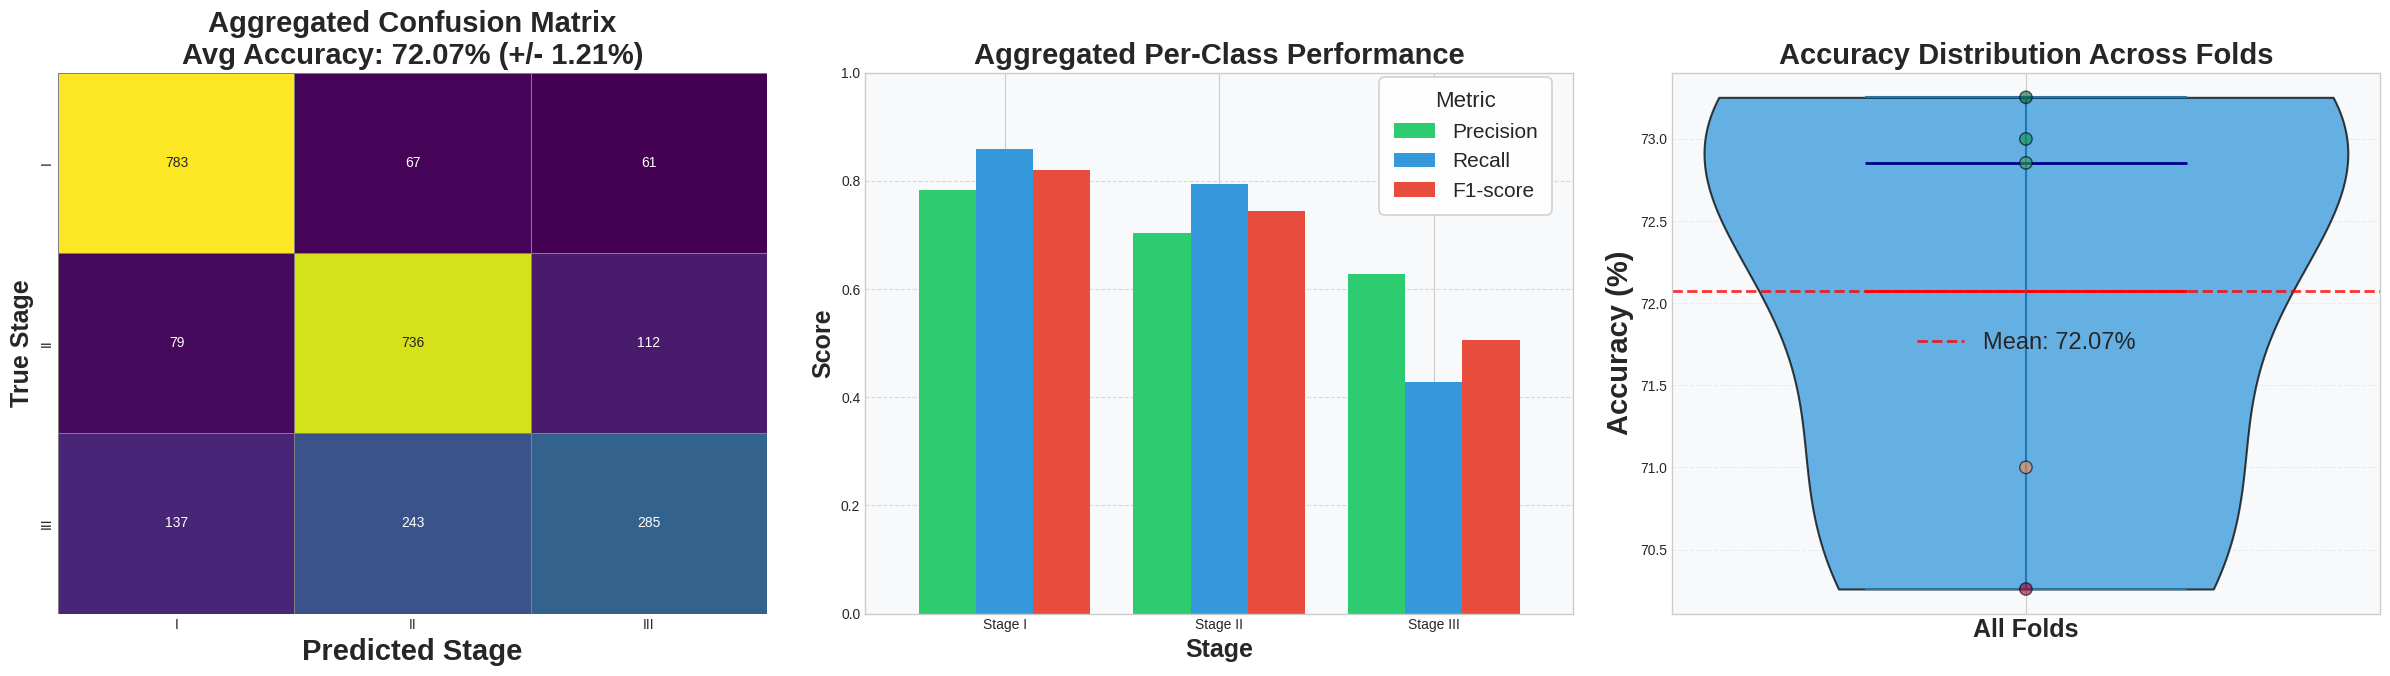

Cross-validation results visualizations complete!
Dashboard saved to: /content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Cross_Validation/Cross_Validation_Dashboard.png


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-v0_8-whitegrid')

save_cv_dir = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Cross_Validation/'

os.makedirs(save_cv_dir, exist_ok=True)

stage_names = ['Stage I', 'Stage II', 'Stage III']
stage_colors = ['#2ecc71', '#3498db', '#e74c3c']

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

#  Plot 1
ax0 = axes[0]
sns.heatmap(sum_confusion_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=['I', 'II', 'III'], yticklabels=['I', 'II', 'III'], ax=ax0,
            linewidths=0.5, linecolor='gray', cbar=False)
ax0.set_xlabel('Predicted Stage', fontsize=21, fontweight='bold')
ax0.set_ylabel('True Stage', fontsize=18, fontweight='bold')
ax0.set_title(f'Aggregated Confusion Matrix\nAvg Accuracy: {mean_accuracy*100:.2f}% (+/- {std_accuracy*100:.2f}%)', fontsize=21, fontweight='bold')

#  Plot 2
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score'],
    'Stage I': [aggregated_report['Stage I']['precision'], aggregated_report['Stage I']['recall'], aggregated_report['Stage I']['f1-score']],
    'Stage II': [aggregated_report['Stage II']['precision'], aggregated_report['Stage II']['recall'], aggregated_report['Stage II']['f1-score']],
    'Stage III': [aggregated_report['Stage III']['precision'], aggregated_report['Stage III']['recall'], aggregated_report['Stage III']['f1-score']]
}).set_index('Metric')

ax1 = axes[1]
metrics_df.T.plot(kind='bar', ax=ax1, width=0.8, color=stage_colors)
ax1.set_title('Aggregated Per-Class Performance', fontsize=21, fontweight='bold')
ax1.set_ylabel('Score', fontsize=18, fontweight='bold')
ax1.set_xlabel('Stage', fontsize=18, fontweight='bold')
ax1.set_ylim(0, 1.0)
leg = ax1.legend(
    title='Metric',
    title_fontsize=16,
    fontsize=15,
    bbox_to_anchor=(0.72, 1),
    loc='upper left',
    frameon=True
)

frame = leg.get_frame()
frame.set_facecolor("white")
frame.set_edgecolor("#d0d0d0")
frame.set_linewidth(1.2)
frame.set_boxstyle("round,pad=0.3")
frame.set_alpha(0.97)
ax1.tick_params(axis='x', rotation=0)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_facecolor('#f8f9fa')

#  Plot 3
ax2 = axes[2]
accuracies_percent = np.array(fold_accuracies) * 100
parts = ax2.violinplot([accuracies_percent], positions=[1], widths=0.7, showmeans=True, showmedians=True, showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_alpha(0.75)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)
parts['cmeans'].set_color('red')
parts['cmeans'].set_linewidth(2)
parts['cmedians'].set_color('darkblue')
parts['cmedians'].set_linewidth(2)

ax2.scatter([1]*len(accuracies_percent), accuracies_percent, alpha=0.6, s=80,
           c=accuracies_percent, cmap='RdYlGn', edgecolors='black', linewidth=1, zorder=3)
ax2.axhline(mean_accuracy * 100, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {mean_accuracy*100:.2f}%')
ax2.set_ylabel('Accuracy (%)', fontsize=21, fontweight='bold')
ax2.set_title('Accuracy Distribution Across Folds', fontsize=21, fontweight='bold')
ax2.set_xticks([1])
ax2.set_xticklabels(['All Folds'], fontsize=18, fontweight='bold')
ax2.legend(fontsize=17)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(f'{save_cv_dir}Cross_Validation_Dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_cv_dir}Cross_Validation_Dashboard.pdf', bbox_inches='tight', facecolor='white')
plt.show()

print("Cross-validation results visualizations complete!")
print(f"Dashboard saved to: {save_cv_dir}Cross_Validation_Dashboard.png")

# **Baseline Models**


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("\n[STEP 1] Loading preprocessed data...")
X_contrastive = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_contrastive.npy')
X_clinical = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/X_clinical.npy')
y = np.load('/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Contrastive_Learning/y.npy')

print(f"   X_contrastive shape: {X_contrastive.shape}")
print(f"   X_clinical shape: {X_clinical.shape}")
print(f"   y shape: {y.shape}")

print("\n[STEP 2] Scaling clinical features and creating data splits...")

scaler = StandardScaler()
X_clin_scaled = scaler.fit_transform(X_clinical).astype(np.float32)
print(f"   X_clinical scaled shape: {X_clin_scaled.shape}")

X_cont_train, X_cont_temp, X_clin_train, X_clin_temp, y_train, y_temp = train_test_split(
    X_contrastive, X_clin_scaled, y, test_size=0.40, random_state=42, stratify=y
)

X_cont_val, X_cont_test, X_clin_val, X_clin_test, y_val, y_test = train_test_split(
    X_cont_temp, X_clin_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"   Train set sizes: X_contrastive={X_cont_train.shape}, X_clinical={X_clin_train.shape}, y={y_train.shape}")
print(f"   Validation set sizes: X_contrastive={X_cont_val.shape}, X_clinical={X_clin_val.shape}, y={y_val.shape}")
print(f"   Test set sizes: X_contrastive={X_cont_test.shape}, X_clinical={X_clin_test.shape}, y={y_test.shape}")

print("\n[STEP 3] Combining contrastive and clinical features for each split...")

X_train_combined = np.hstack([X_cont_train, X_clin_train])
X_val_combined = np.hstack([X_cont_val, X_clin_val])
X_test_combined = np.hstack([X_cont_test, X_clin_test])

print(f"   Combined training features shape: {X_train_combined.shape}")
print(f"   Combined validation features shape: {X_val_combined.shape}")
print(f"   Combined test features shape: {X_test_combined.shape}")


[STEP 1] Loading preprocessed data...
   X_contrastive shape: (2503, 128)
   X_clinical shape: (2503, 13)
   y shape: (2503,)

[STEP 2] Scaling clinical features and creating data splits...
   X_clinical scaled shape: (2503, 13)
   Train set sizes: X_contrastive=(1501, 128), X_clinical=(1501, 13), y=(1501,)
   Validation set sizes: X_contrastive=(501, 128), X_clinical=(501, 13), y=(501,)
   Test set sizes: X_contrastive=(501, 128), X_clinical=(501, 13), y=(501,)

[STEP 3] Combining contrastive and clinical features for each split...
   Combined training features shape: (1501, 141)
   Combined validation features shape: (501, 141)
   Combined test features shape: (501, 141)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

print("\n[STEP 4] Initializing models, scaler, and results dictionary...")

baseline_results = {}

scaler_baseline = StandardScaler()
X_train_combined_scaled = scaler_baseline.fit_transform(X_train_combined)
X_val_combined_scaled = scaler_baseline.transform(X_val_combined)
X_test_combined_scaled = scaler_baseline.transform(X_test_combined)

print(f"   X_train_combined_scaled shape: {X_train_combined_scaled.shape}")
print(f"   X_val_combined_scaled shape: {X_val_combined_scaled.shape}")
print(f"   X_test_combined_scaled shape: {X_test_combined_scaled.shape}")


[STEP 4] Initializing models, scaler, and results dictionary...
   X_train_combined_scaled shape: (1501, 141)
   X_val_combined_scaled shape: (501, 141)
   X_test_combined_scaled shape: (501, 141)


In [ ]:
print("\n[STEP 5] Training and evaluating baseline models")

target_names = ['Stage I', 'Stage II', 'Stage III']

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors Classifier': KNeighborsClassifier(n_neighbors=5)
}

for name, model in models.items():
    print(f"\n Training and evaluating {name}")
    model.fit(X_train_combined_scaled, y_train)
    y_pred = model.predict(X_test_combined_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    baseline_results[name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm
    }
    print(f"   {name} - Accuracy: {accuracy*100:.2f}%")
    print(f"   Confusion Matrix:\n{cm}")
    print(f"   Detailed Classification Report:")
    for stage in target_names:
        print(f"     {stage}:")
        print(f"       Precision: {report[stage]['precision']:.4f}")
        print(f"       Recall: {report[stage]['recall']:.4f}")
        print(f"       F1-score: {report[stage]['f1-score']:.4f}")

print("\n[STEP 6] All baseline models evaluated.")


[STEP 5] Training and evaluating baseline models

 Training and evaluating Logistic Regression
   Logistic Regression - Accuracy: 68.86%
   Confusion Matrix:
[[151  18  14]
 [ 13 134  38]
 [ 19  54  60]]
   Detailed Classification Report:
     Stage I:
       Precision: 0.8251
       Recall: 0.8251
       F1-score: 0.8251
     Stage II:
       Precision: 0.6505
       Recall: 0.7243
       F1-score: 0.6854
     Stage III:
       Precision: 0.5357
       Recall: 0.4511
       F1-score: 0.4898

 Training and evaluating SVM
   SVM - Accuracy: 71.06%
   Confusion Matrix:
[[156  17  10]
 [ 12 147  26]
 [ 27  53  53]]
   Detailed Classification Report:
     Stage I:
       Precision: 0.8000
       Recall: 0.8525
       F1-score: 0.8254
     Stage II:
       Precision: 0.6774
       Recall: 0.7946
       F1-score: 0.7313
     Stage III:
       Precision: 0.5955
       Recall: 0.3985
       F1-score: 0.4775

 Training and evaluating Random Forest Classifier
   Random Forest Classifier - Accur


[STEP 11] Generating combined Precision, Recall, F1-score comparison figure...


/tmp/ipython-input-970664294.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


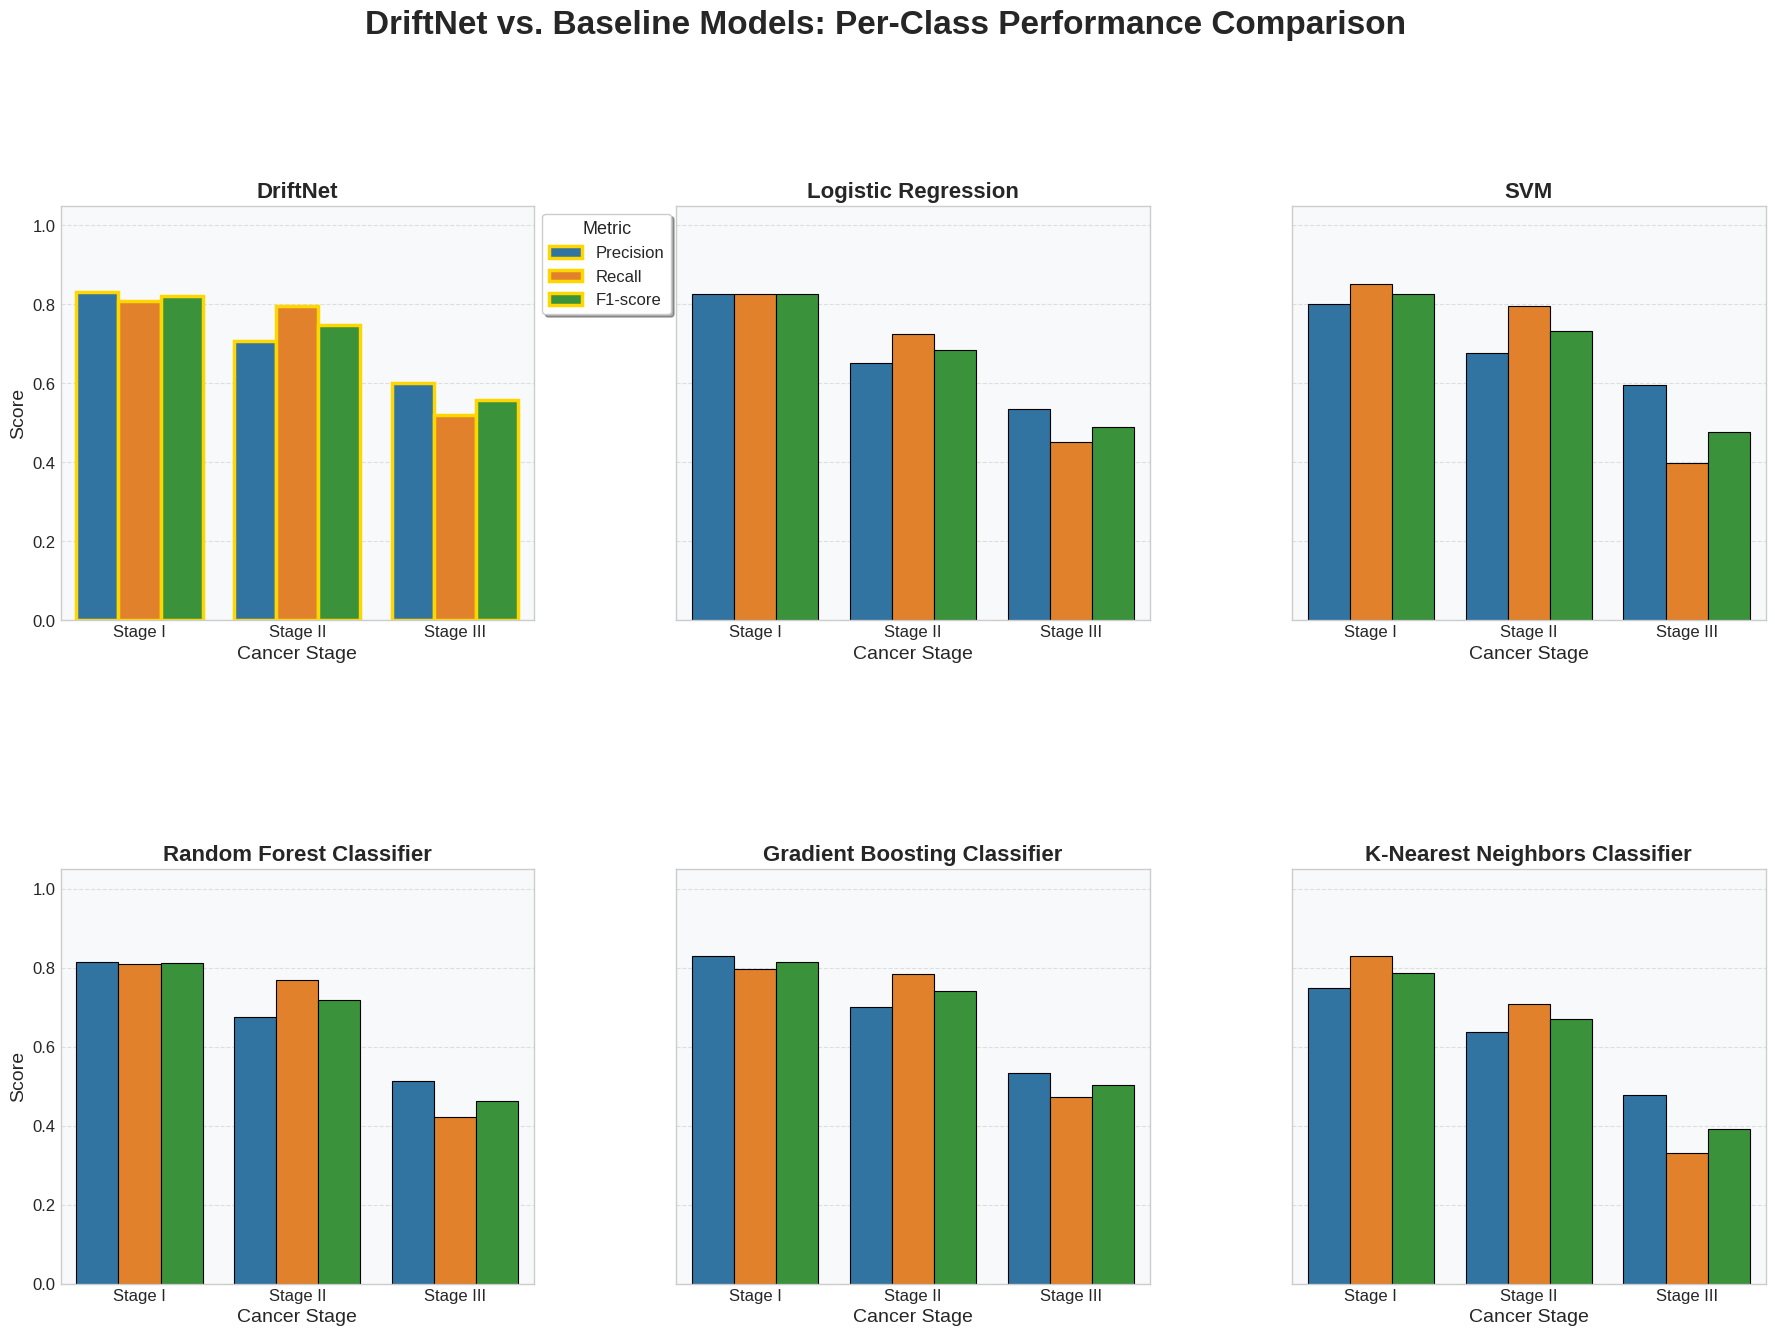


   Per-Class Metrics Comparison Dashboard saved and displayed.
   Saved to: /content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Baseline_Models/Per_Class_Metrics_Comparison_Dashboard.png
All comparison visualizations complete!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

save_baseline_dir = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Baseline_Models/'
os.makedirs(save_baseline_dir, exist_ok=True)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-v0_8-whitegrid')

print("\n[STEP 11] Generating combined Precision, Recall, F1-score comparison figure...")

target_names = ['Stage I', 'Stage II', 'Stage III']

driftnet_random_dir = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Random/'
best_pred_df_60_20_20 = pd.read_csv(f'{driftnet_random_dir}predictions.csv')
driftnet_y_test_60_20_20 = best_pred_df_60_20_20['True'].values
driftnet_best_pred_60_20_20 = best_pred_df_60_20_20['Predicted'].values

driftnet_all_results_60_20_20_df = pd.read_csv(f'{driftnet_random_dir}auto_seeds_results.csv')
driftnet_best_accuracy_60_20_20 = driftnet_all_results_60_20_20_df['accuracy'].max()

driftnet_report_full = classification_report(driftnet_y_test_60_20_20, driftnet_best_pred_60_20_20, target_names=target_names, output_dict=True)

all_model_metrics = []

for name, result in baseline_results.items():
    for stage in target_names:
        all_model_metrics.append({
            'Model': name,
            'Stage': stage,
            'Metric': 'Precision',
            'Score': result['report'][stage]['precision']
        })
        all_model_metrics.append({
            'Model': name,
            'Stage': stage,
            'Metric': 'Recall',
            'Score': result['report'][stage]['recall']
        })
        all_model_metrics.append({
            'Model': name,
            'Stage': stage,
            'Metric': 'F1-score',
            'Score': result['report'][stage]['f1-score']
        })


for stage in target_names:
    all_model_metrics.append({
        'Model': 'DriftNet',
        'Stage': stage,
        'Metric': 'Precision',
        'Score': driftnet_report_full[stage]['precision']
    })
    all_model_metrics.append({
        'Model': 'DriftNet',
        'Stage': stage,
        'Metric': 'Recall',
        'Score': driftnet_report_full[stage]['recall']
    })
    all_model_metrics.append({
        'Model': 'DriftNet',
        'Stage': stage,
        'Metric': 'F1-score',
        'Score': driftnet_report_full[stage]['f1-score']
    })

df_long = pd.DataFrame(all_model_metrics)

model_order = [model for model in df_long['Model'].unique() if model != 'DriftNet']
model_order.insert(0, 'DriftNet')

num_models_to_plot = len(model_order)
num_cols = 3
num_rows = (num_models_to_plot + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(22, num_rows * 7), sharey=True, gridspec_kw={'hspace': 0.6, 'wspace': 0.3})
axes = axes.flatten()

metric_colors = {'Precision': '#1f77b4', 'Recall': '#ff7f0e', 'F1-score': '#2ca02c'}

for i, model_name in enumerate(model_order):
    ax = axes[i]
    model_data = df_long[df_long['Model'] == model_name]

    sns.barplot(x='Stage', y='Score', hue='Metric', data=model_data,
                palette=metric_colors, ax=ax, edgecolor='black', linewidth=0.8)

    ax.set_title(model_name, fontsize=16, fontweight='bold')
    ax.set_xlabel('Cancer Stage', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=0, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    if model_name == 'DriftNet':
        for patch in ax.patches:
            patch.set_edgecolor('gold')
            patch.set_linewidth(2.5)

    if i != 0:
        ax.legend().set_visible(False)
    else:
        ax.legend(title='Metric', bbox_to_anchor=(1.00, 1), loc='upper left', frameon=True, shadow=True, fancybox=True, fontsize=12, title_fontsize=13)

    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_facecolor('#f8f9fa')

for j in range(num_models_to_plot, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('DriftNet vs. Baseline Models: Per-Class Performance Comparison', fontsize=24, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.savefig(f'{save_baseline_dir}Per_Class_Metrics_Comparison_Dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_baseline_dir}Per_Class_Metrics_Comparison_Dashboard.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n   Per-Class Metrics Comparison Dashboard saved and displayed.")
print(f"   Saved to: {save_baseline_dir}Per_Class_Metrics_Comparison_Dashboard.png")

print("All comparison visualizations complete!")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

print("\n[STEP 7] Aggregating baseline results and preparing for comparison")

save_baseline_dir = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Baseline_Models/'
os.makedirs(save_baseline_dir, exist_ok=True)

driftnet_results_path = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /DriftNet/Random/auto_seeds_results.csv'
driftnet_accuracies_df = pd.read_csv(driftnet_results_path)
best_acc = driftnet_accuracies_df['accuracy'].max()

driftnet_best_accuracy = best_acc

model_names = []
accuracies = []
for name, result in baseline_results.items():
    if 'DriftNet' not in name:
        model_names.append(name)
        accuracies.append(result['accuracy'])

model_names.append('DriftNet')
accuracies.append(best_acc)
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
}).sort_values(by='Accuracy', ascending=False)

print("\n Comparison Table (Accuracy)")
print(comparison_df.to_string(index=False))

aggregated_baseline_reports = {}
for metric_name in ['precision', 'recall', 'f1-score']:
    aggregated_baseline_reports[metric_name] = {
        stage: np.mean([baseline_results[model_name]['report'][stage][metric_name] for model_name in baseline_results.keys() if 'DriftNet' not in model_name])
        for stage in target_names
    }

print("\n[STEP 8] All baseline results aggregated.")


[STEP 7] Aggregating baseline results and preparing for comparison

 Comparison Table (Accuracy)
                         Model  Accuracy
                      DriftNet  0.726547
                           SVM  0.710579
  Gradient Boosting Classifier  0.706587
      Random Forest Classifier  0.690619
           Logistic Regression  0.688623
K-Nearest Neighbors Classifier  0.652695

[STEP 8] All baseline results aggregated.


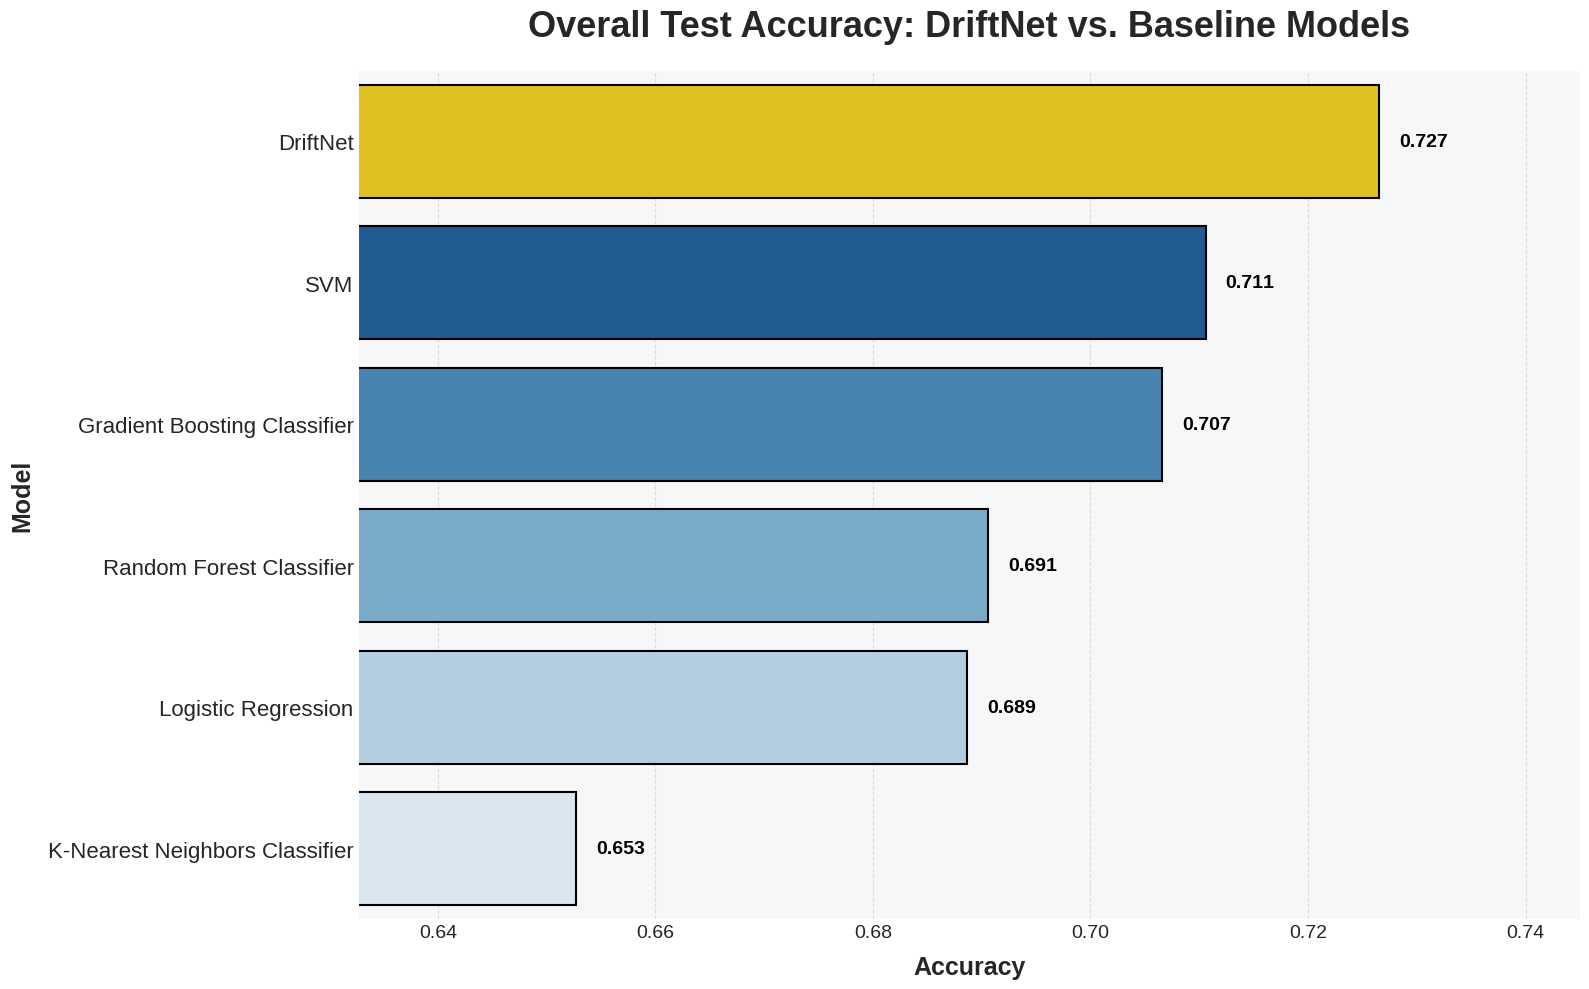


Premium Accuracy Comparison figure saved.
Saved to: /content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Baseline_Models/Overall_Accuracy_Comparison_Premium.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

save_baseline_dir = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Baseline_Models/'
os.makedirs(save_baseline_dir, exist_ok=True)

overall_accuracy_data = {'Model': [], 'Accuracy': []}

for name, result in baseline_results.items():
    overall_accuracy_data['Model'].append(name)
    overall_accuracy_data['Accuracy'].append(result['accuracy'])

overall_accuracy_data['Model'].append('DriftNet')
overall_accuracy_data['Accuracy'].append(best_acc)

overall_accuracy_df = (
    pd.DataFrame(overall_accuracy_data)
    .sort_values(by='Accuracy', ascending=False)
    .reset_index(drop=True)
)

base_models = [m for m in overall_accuracy_df['Model'] if m != 'DriftNet']
palette_base = sns.color_palette("Blues_r", len(base_models)).as_hex()

colors = []
for model in overall_accuracy_df['Model']:
    if model == "DriftNet":
        colors.append("#FFD700")
    else:
        colors.append(palette_base.pop(0))

fig, ax = plt.subplots(figsize=(16, 10))

sns.barplot(
    x='Accuracy',
    y='Model',
    hue='Model',
    data=overall_accuracy_df,
    palette=colors,
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
    legend=False
)

ax.set_title('Overall Test Accuracy: DriftNet vs. Baseline Models',
             fontsize=26, fontweight='bold', pad=25)

ax.set_xlabel('Accuracy', fontsize=18, fontweight='bold', labelpad=10)
ax.set_ylabel('Model', fontsize=18, fontweight='bold', labelpad=10)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)

min_acc = overall_accuracy_df['Accuracy'].min()
max_acc = overall_accuracy_df['Accuracy'].max()
margin = (max_acc - min_acc) * 0.25
ax.set_xlim(min_acc - 0.02, max_acc + margin)

for index, row in overall_accuracy_df.iterrows():
    ax.text(
        row.Accuracy + (margin * 0.10),
        index,
        f'{row.Accuracy:.3f}',
        color='black',
        ha='left',
        va='center',
        fontsize=14,
        fontweight='bold'
    )

ax.grid(axis='x', linestyle='--', alpha=0.6)
ax.set_axisbelow(True)
ax.set_facecolor('#f6f7f8')
sns.despine(left=True, bottom=True)

plt.tight_layout()

plt.savefig(
    f'{save_baseline_dir}Overall_Accuracy_Comparison_Premium.png',
    dpi=400, bbox_inches='tight', facecolor='white'
)
plt.savefig(
    f'{save_baseline_dir}Overall_Accuracy_Comparison_Premium.pdf',
    dpi=400, bbox_inches='tight', facecolor='white'
)

plt.show()

print("\nPremium Accuracy Comparison figure saved.")
print(f"Saved to: {save_baseline_dir}Overall_Accuracy_Comparison_Premium.png")

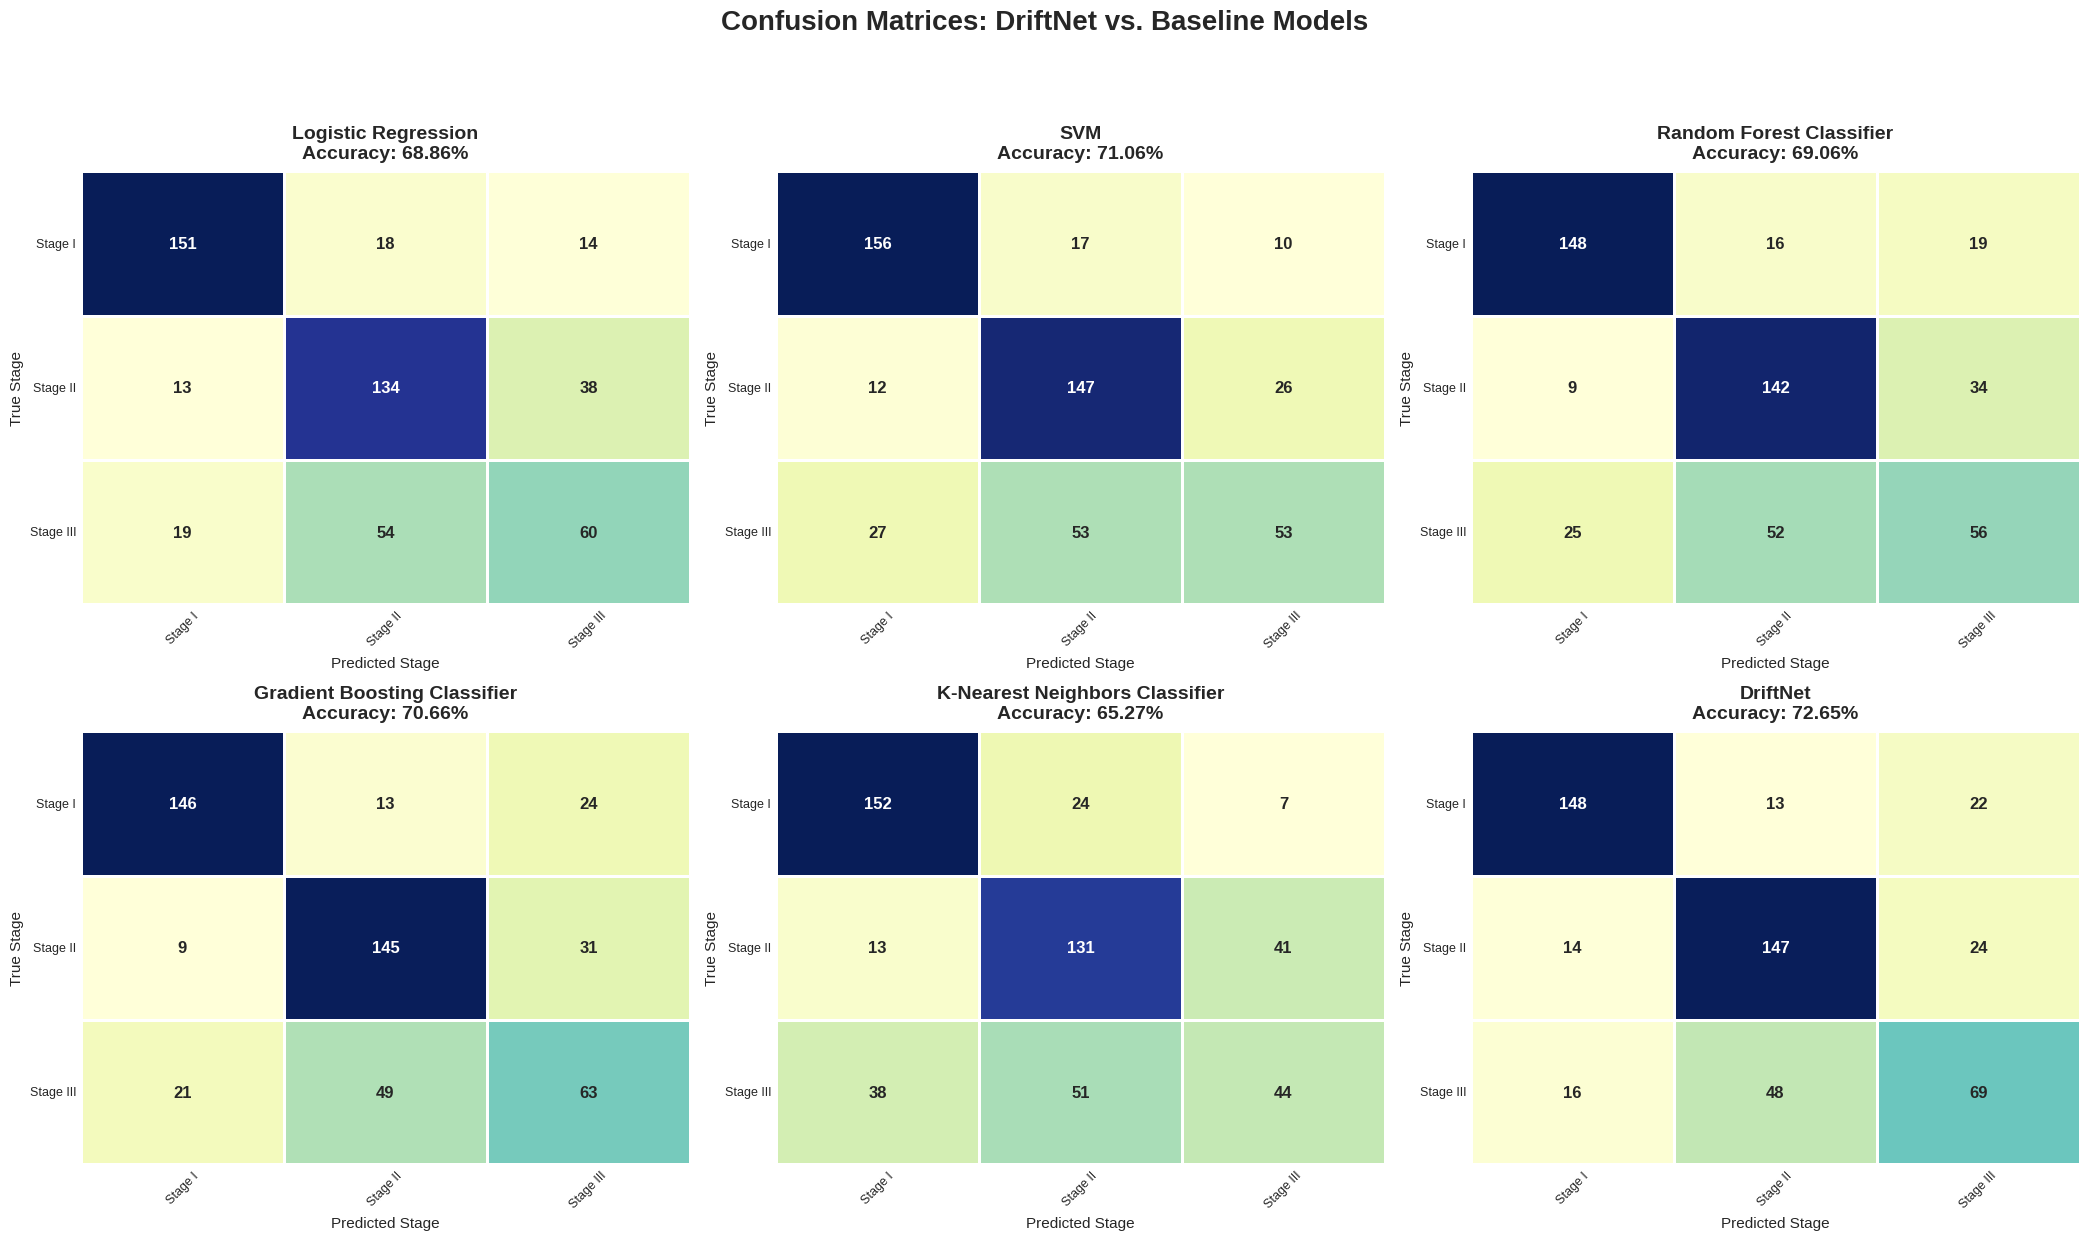


Enhanced Confusion Matrices Dashboard saved and displayed.
Saved to: /content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Baseline_Models/Confusion_Matrices_Dashboard_Enhanced.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

save_baseline_dir = '/content/drive/MyDrive/GDC TCGA DATASET/1. Capstone /processed_data/DriftNet_Classification /Baseline_Models/'
os.makedirs(save_baseline_dir, exist_ok=True)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-v0_8-whitegrid')

target_names = ['Stage I', 'Stage II', 'Stage III']

all_models = {
    **baseline_results,
    'DriftNet': {
        'accuracy': best_acc,
        'confusion_matrix': confusion_matrix(y_test, best_pred)
    }
}

num_models = len(all_models)
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 7, num_rows * 6), squeeze=False)
axes = axes.flatten()

for i, (name, data) in enumerate(all_models.items()):
    ax = axes[i]
    cm = data['confusion_matrix']
    accuracy = data['accuracy']
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=target_names, yticklabels=target_names, ax=ax,
                linewidths=0.8, linecolor='white', cbar=False, annot_kws={'size': 12, 'weight': 'bold'})

    ax.set_title(f'{name}\nAccuracy: {accuracy*100:.2f}%', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Predicted Stage', fontsize=11)
    ax.set_ylabel('True Stage', fontsize=11)
    ax.tick_params(axis='x', labelsize=9, rotation=45)
    ax.tick_params(axis='y', labelsize=9, rotation=0)

    if name == 'DriftNet':
        for spine in ax.spines.values():
            spine.set_edgecolor('gold')
            spine.set_linewidth(3)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Confusion Matrices: DriftNet vs. Baseline Models', fontsize=20, fontweight='bold', y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(f'{save_baseline_dir}Confusion_Matrices_Dashboard_Enhanced.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{save_baseline_dir}Confusion_Matrices_Dashboard_Enhanced.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nEnhanced Confusion Matrices Dashboard saved and displayed.")
print(f"Saved to: {save_baseline_dir}Confusion_Matrices_Dashboard_Enhanced.png")